# Analyzing Trace Statistics

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from MemoryAutoScaling import analysis, plotting, specs, utils

pd.set_option('display.max_columns', None)

### Function Definitions

In [2]:
def plot_utilization_cdf(stat_df, resource_name):
    """Plots a CDF of utilization for `resource_name` from `stat_df`.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        A pandas DataFrame containing the utilization statistics.
    resource_name: str
        A string representing the name of the resource to which the utilization rates apply.
    
    Returns
    -------
    None
    
    """
    utilization_vals = utils.impute_for_time_series(stat_df['utilization'].values, 0.0)
    plt.figure(figsize=(20, 10))
    x, y = plotting.get_cdf_values(utilization_vals)
    plt.plot(x, y)
    plt.title("CDF of {} Utilization Rates Across Traces".format(resource_name))
    plt.xlabel("Utilization Rate")
    plt.show()

In [3]:
def plot_all_correlations_for_lag(stat_df, stats_col, lag):
    """Plots all correlations for `stats_col` in `stat_df` at `lag`.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        A pandas DataFrame containing the correlation statistics for `stats_col`.
    stats_col: str
        A string representing the column for which the correlations are computed. Each
        correlation is another variable versus `stats_col`.
    lag: int
        An integer representing the lag used in the correlation calculations. For each
        correlation plotted, the correlation is between `stats_col` and another variable
        lagged by `lag` time steps.
    
    Returns
    -------
    None
    
    """
    plt.figure(figsize=(20, 10))
    for col_name in specs.get_trace_columns():
        x, y = plotting.get_cdf_values(stat_df["corr_{0}_lag_{1}".format(col_name, lag)].abs().values)
        plt.plot(x, y,label=col_name)
    plt.title("{0} Usage Correlations - Lag {1}".format(stats_col, lag))
    plt.legend()
    plt.show()

In [4]:
def plot_all_correlations_across_all_lags(stat_df, stats_col):
    """Plots all correlations for `stats_col` in `stat_df` across all lags.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        A pandas DataFrame containing the correlation statistics for `stats_col`.
    stats_col: str
        A string representing the column for which the correlations are computed. Each
        correlation is another variable versus `stats_col`.
    
    Returns
    -------
    None
    
    """
    for lag in [1, 2, 3]:
        plot_all_correlations_for_lag(stat_df, stats_col, lag)

In [5]:
def print_stationarity_results(stat_df):
    """Prints the results of the stationarity tests in `stat_df`.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        A pandas DataFrame containing the statistics for traces, including
        tests for stationarity in columns `adf_p_val`, `adf_p_val_diff` and
        `adf_p_val_diff_2`.
    
    Returns
    -------
    None
    
    """
    print("Stationarity Results")
    stationary_dict = analysis.stationary_results_from_stats_df(stat_df)
    print("Number of Stationary Traces: {}%".format(stationary_dict['diff_0']))
    print("Number of Stationary Traces after 1 Level Differencing: {}%".format(stationary_dict['diff_1']))
    print("Number of Stationary Traces after 2 Level Differencing: {}%".format(stationary_dict['diff_2']))
    print("Other: {}%".format(stationary_dict['other']))

In [6]:
def print_correlation_results(stat_df, target_col, corr_cols):
    """Prints a summary of correlation results for `target_col` vs other time series.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        A pandas DataFrame containing the statistics for traces.
    target_col: str
        A string representing the name of the target column for which the correlations are generated.
    corr_cols: list
        A list of columns for which the correlation results are retrieved.
    
    Returns
    -------
    None
    
    """
    print("Correlation Results")
    for col_name in corr_cols:
        corr_count = len(stat_df[stat_df["corr_{}_ts".format(col_name)].abs() >= 0.7])
        print("Number of traces with correlation of {0} and {1} >= 0.7 or <= -0.7: {2}".format(
            target_col, col_name, corr_count))

In [7]:
def print_statistical_analysis_summary(stat_df, target_col, corr_cols):
    """Prints a summary of the results of `stat_df` for `target_col`.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        A pandas DataFrame containing the statistics for traces.
    target_col: str
        A string representing the name of the target column for which the statistics are generated.
    corr_cols: list
        A list of columns for which the correlation results are retrieved.
    
    Returns
    -------
    None
    
    """
    print("Total Trace Count: {}".format(len(stat_df)))
    print()
    print_stationarity_results(stat_df)
    print()
    print_correlation_results(stat_df, target_col, corr_cols)

In [8]:
def plot_lagged_cdfs(data_df, col_name, col_title, stats_col):
    """Plots the lagged CDFs for `col_name`.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas DataFrame containing the distributions for the CDFs
    col_name: str
        A string representing the column for which the CDFs are generated.
    col_title: str
        A string representing the column title for the CDFs.
    stats_col: str
        A string representing the name of the column for which all statistics
        are generated.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(2, 2, figsize=(20, 8))
    lags = [0, 1, 2, 3]
    col_names = ["corr_{}".format(col_name)] + ["corr_{0}_lag_{1}".format(col_name, lag) for lag in lags[1:]]
    colors = ["blue", "black", "green", "red"]
    for idx in range(4):
        row = idx // 2
        col = idx % 2
        data_vals = data_df[col_names[idx]].abs().values
        data_vals = data_vals[~np.isnan(data_vals)]
        plotting.plot_cumulative_distribution_function(data_vals, axes[row, col],
                                                       "{0} Lag {1}".format(col_title, lags[idx]), colors[idx],
                                                       "CDF of Correlation of {} Usage".format(stats_col))
    plt.show()

In [9]:
def print_all_cdfs_for_stats(data_df, col_name, col_title, stats_col, is_max=True):
    """Prints all of the CDFs for the correlations for `col_name` across all stats.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas DataFrame containing the distributions for the CDFs
    col_name: str
        A string representing the column for which the CDFs are generated.
    col_title: str
        A string representing the column title for the CDFs.
    stats_col: str
        A string representing the name of the column for which all statistics
        are generated.
    is_max: bool
        A boolean indicating whether `col_name` corresponds to a maximum column.
    
    Returns
    -------
    None
    
    """
    if is_max:
        col_names = ["{0}_{1}".format(col_name, stat) for stat in specs.MAX_STATS_COLS]
    else:
        col_names = ["{0}_{1}".format(col_name, stat) for stat in specs.AVG_STATS_COLS]
    for name in col_names:
        print(name)
        plot_lagged_cdfs(data_df, name, col_title, stats_col)
        print("------------------------------------------------------------------------")

In [10]:
def plot_all_lagged_correlation_cdfs(stat_df, stats_col):
    """Plots all of the CDFs for the correlations in `stat_df`.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        The pandas DataFrame containing the distributions for the CDFs.
    stats_col: str
        A string representing the name of the column for which all statistics
        are generated.
    
    Returns
    -------
    None
    
    """
    for idx in range(len(specs.RAW_TIME_SERIES_COLS)):
        col_name = specs.RAW_TIME_SERIES_NAMES[idx]
        is_max = (col_name.split()[0] == "Maximum")
        print_all_cdfs_for_stats(stat_df, specs.RAW_TIME_SERIES_COLS[idx], col_name, stats_col, is_max)

In [11]:
def plot_causal_cdfs(data_df, col_name, test_name, col_title):
    """Plots the causal CDFs for `col_name`.
    
    Parameters
    ----------
    data_df: pd.DataFrame
        The pandas DataFrame containing the distributions for the CDFs
    col_name: str
        A string representing the column for which the CDFs are generated.
    test_name: str
        A string representing the name of the causality test.
    col_title: str
        A string representing the column title for the CDFs.
    
    Returns
    -------
    None
    
    """
    fig, axes = plt.subplots(3, figsize=(20, 20))
    lags = [1, 2, 3]
    col_names = ["causal_{0}_{1}_{2}".format(col_name, test_name, lag) for lag in lags]
    colors = ["blue", "black", "green"]
    for idx in range(3):
        data_vals = data_df[col_names[idx]].abs().values
        data_vals = data_vals[~np.isnan(data_vals)]
        plotting.plot_cumulative_distribution_function(data_df[col_names[idx]].abs().values, axes[idx],
                                                       "{0} Lag {1}".format(col_title, lags[idx]), colors[idx],
                                                       "CDF of Causation P-Values")
    plt.show()

In [12]:
def plot_all_causal_cdfs(stat_df, causal_cols, causal_titles, test_name):
    """Plots all causal CDFs for the columns in `causal_cols`.
    
    Parameters
    ----------
    stat_df: pd.DataFrame
        The pandas DataFrame containing the distributions for the CDFs
    causal_cols: list
        A list of strings denoting the names of the columns used in the causality tests.
    causal_titles: list
        A list of strings representing the titles for the CDFs.
    test_name: str
        A string representing the name of the causality test.
    
    Returns
    -------
    None
    
    """
    for idx in range(len(causal_cols)):
        print(causal_cols[idx])
        plot_causal_cdfs(stat_df, "{}_ts".format(causal_cols[idx]), test_name, causal_titles[idx])

In [13]:
def summarize_statistical_results(input_dir, target_col, causal_test, stats_col):
    """Summarizes the statistical results in `input_dir` for `target_col`.
    
    Parameters
    ----------
    input_dir: str
        A string representing the path of the directory containing the results.
    target_col: str
        A string representing the name of the column serving as the target variable for analysis.
    causal_test: str
        A string representing the name of the causality test being summarized.
    stats_col: str
        A string representing the name of the column for which all statistics
        are generated.
    
    Returns
    -------
    None
    
    """
    stats_data = pd.read_csv(os.path.join(input_dir, "trace_stats.csv"))
    target_idx = specs.RAW_TIME_SERIES_COLS.index(target_col)
    causal_cols = [specs.RAW_TIME_SERIES_COLS[idx] 
                   for idx in range(len(specs.RAW_TIME_SERIES_COLS)) if idx != target_idx]
    causal_titles = [specs.RAW_TIME_SERIES_NAMES[idx]
                     for idx in range(len(specs.RAW_TIME_SERIES_NAMES)) if idx != target_idx]
    print_statistical_analysis_summary(stats_data, target_col, causal_cols)
    print()
    plot_utilization_cdf(stats_data, stats_col.split()[-1])
    plot_all_correlations_across_all_lags(stats_data, stats_col)
    plot_all_lagged_correlation_cdfs(stats_data, stats_col)
    print()
    plot_all_causal_cdfs(stats_data, causal_cols, causal_titles, causal_test)
    return stats_data

In [14]:
stats_dfs = {}

### Maximum Memory Usage - 3 Period Aggregation

Total Trace Count: 1427

Stationarity Results
Number of Stationary Traces: 35.81%
Number of Stationary Traces after 1 Level Differencing: 62.44%
Number of Stationary Traces after 2 Level Differencing: 0.77%
Other: 0.98%

Correlation Results
Number of traces with correlation of maximum_usage.memory and average_usage.memory >= 0.7 or <= -0.7: 1264
Number of traces with correlation of maximum_usage.memory and maximum_usage.cpus >= 0.7 or <= -0.7: 476
Number of traces with correlation of maximum_usage.memory and average_usage.cpus >= 0.7 or <= -0.7: 436



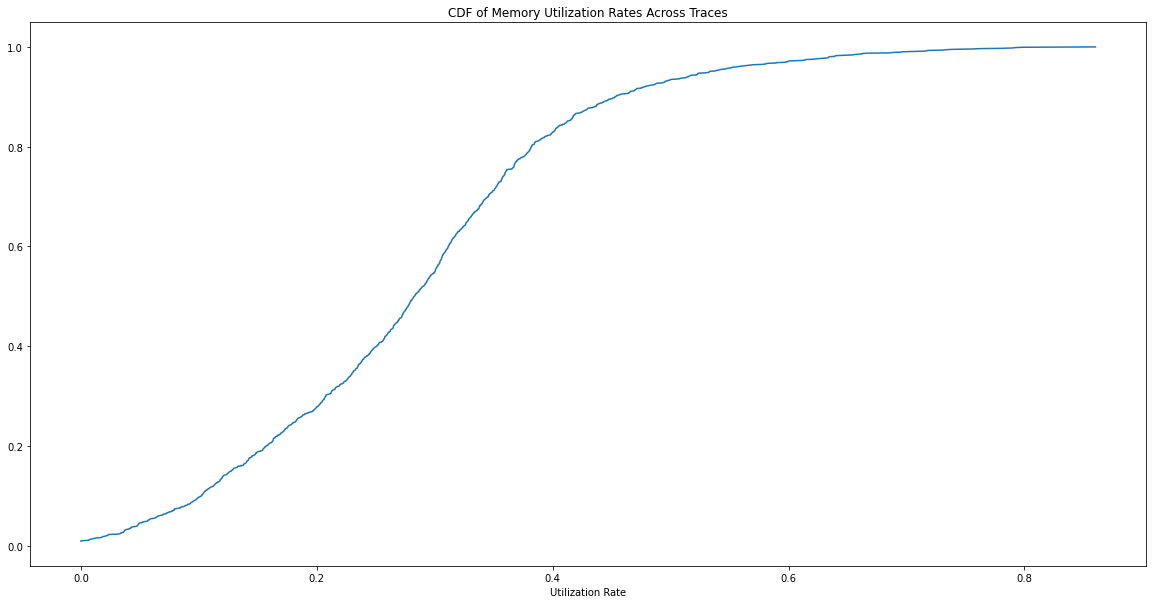

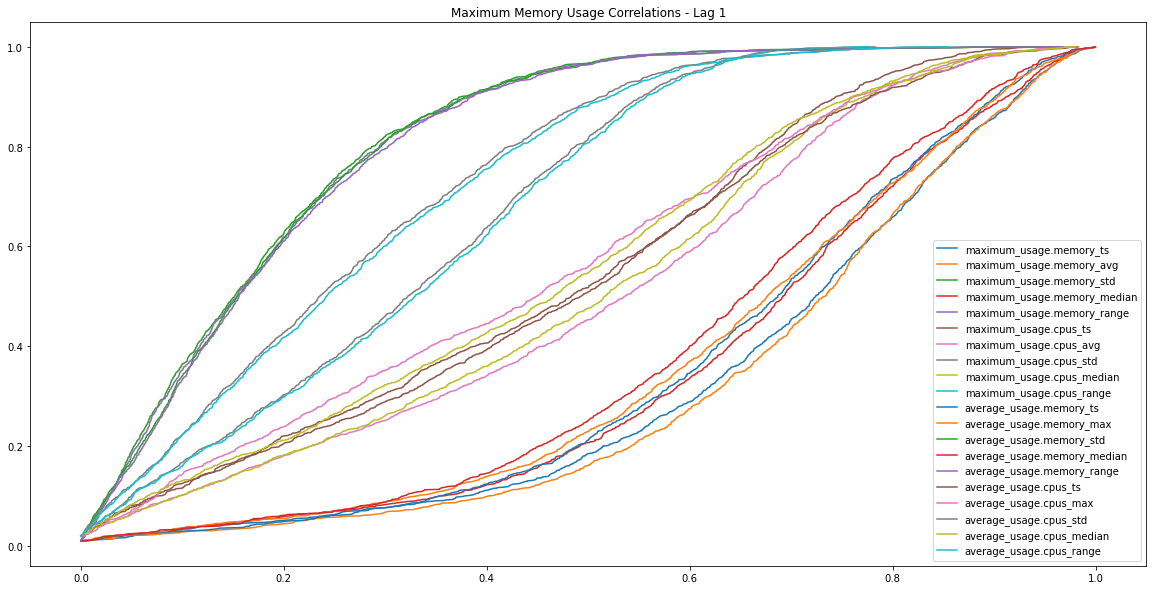

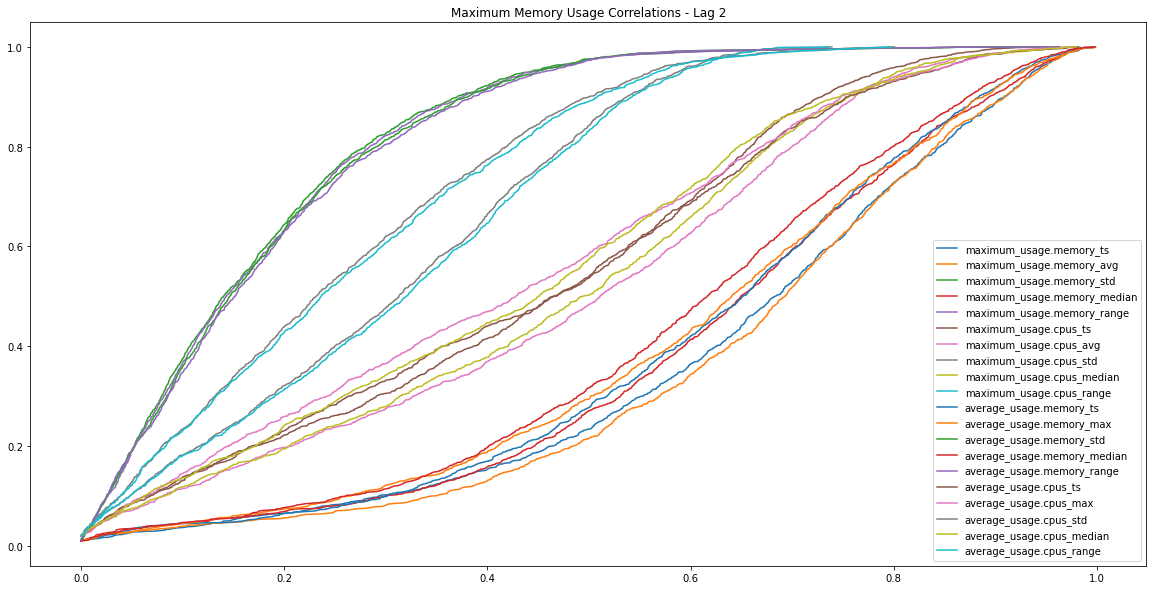

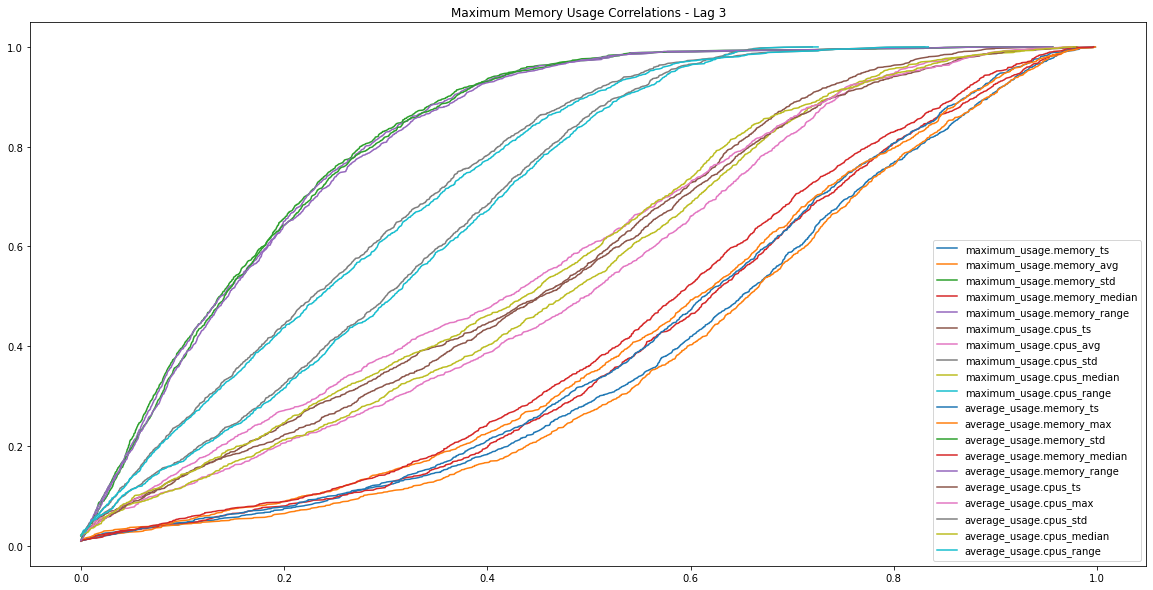

maximum_usage.memory_ts


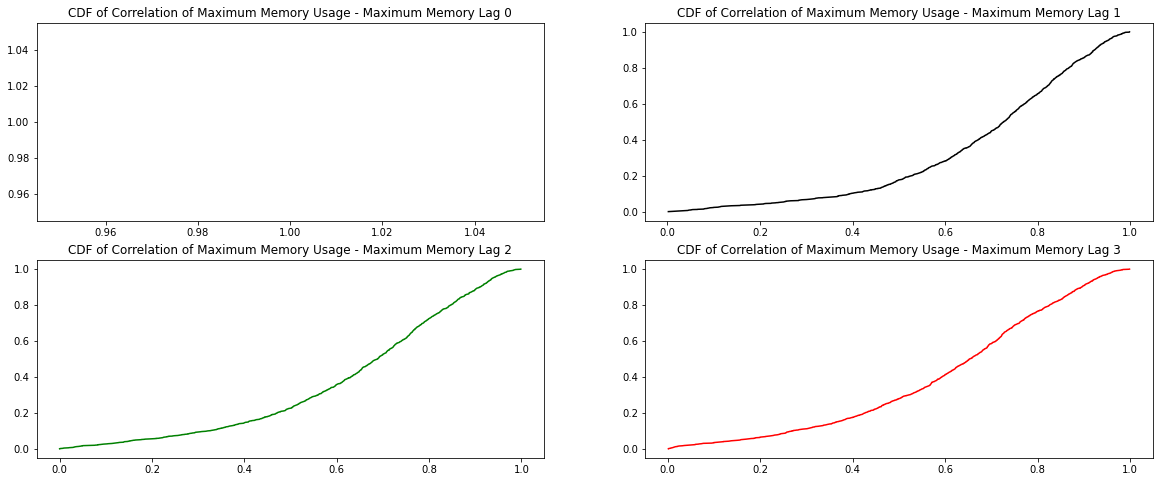

------------------------------------------------------------------------
maximum_usage.memory_avg


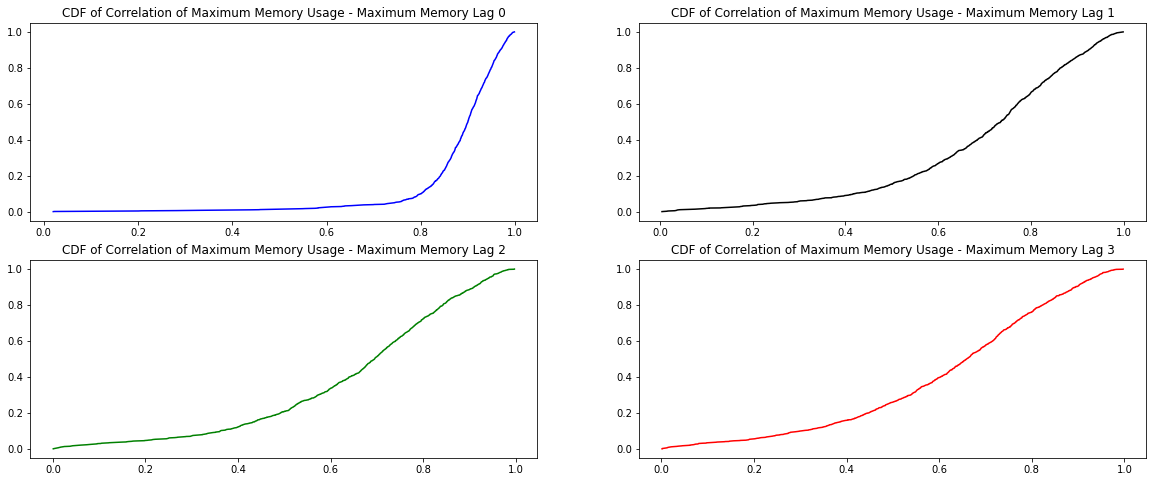

------------------------------------------------------------------------
maximum_usage.memory_std


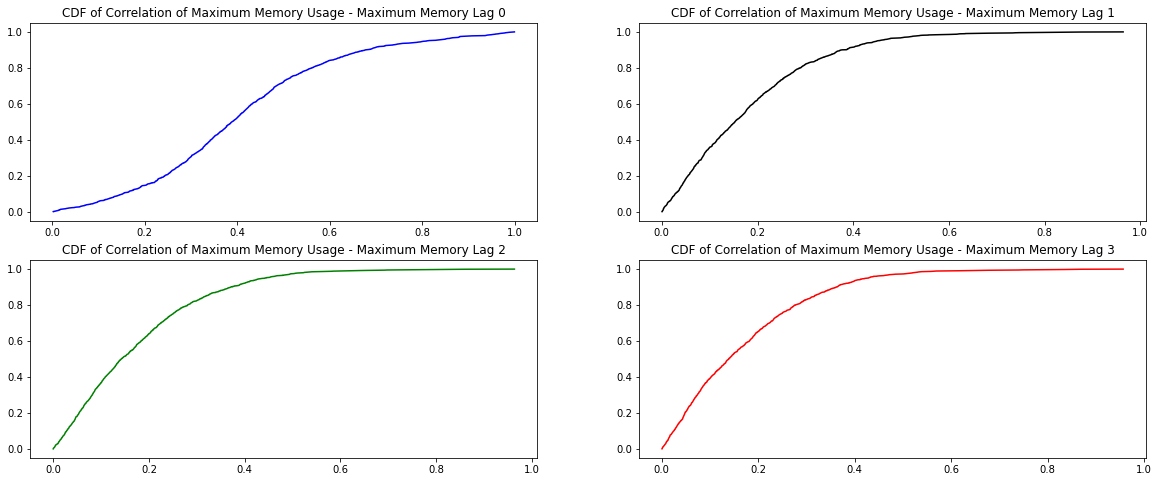

------------------------------------------------------------------------
maximum_usage.memory_median


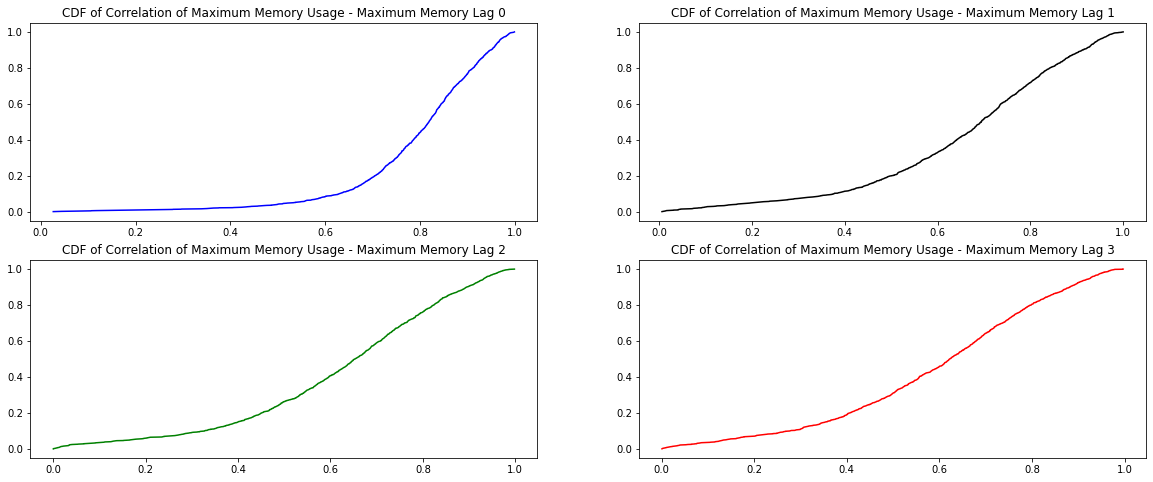

------------------------------------------------------------------------
maximum_usage.memory_range


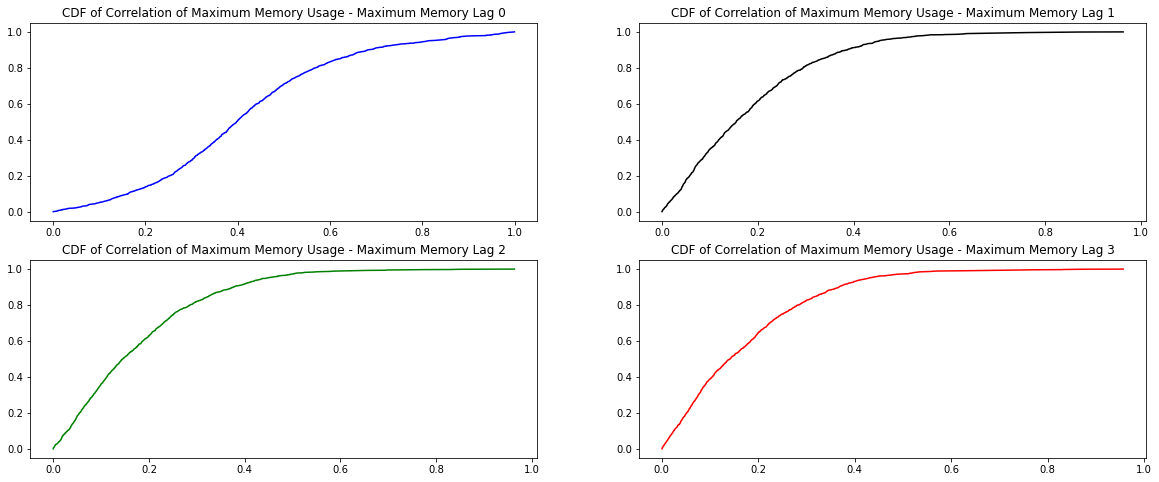

------------------------------------------------------------------------
average_usage.memory_ts


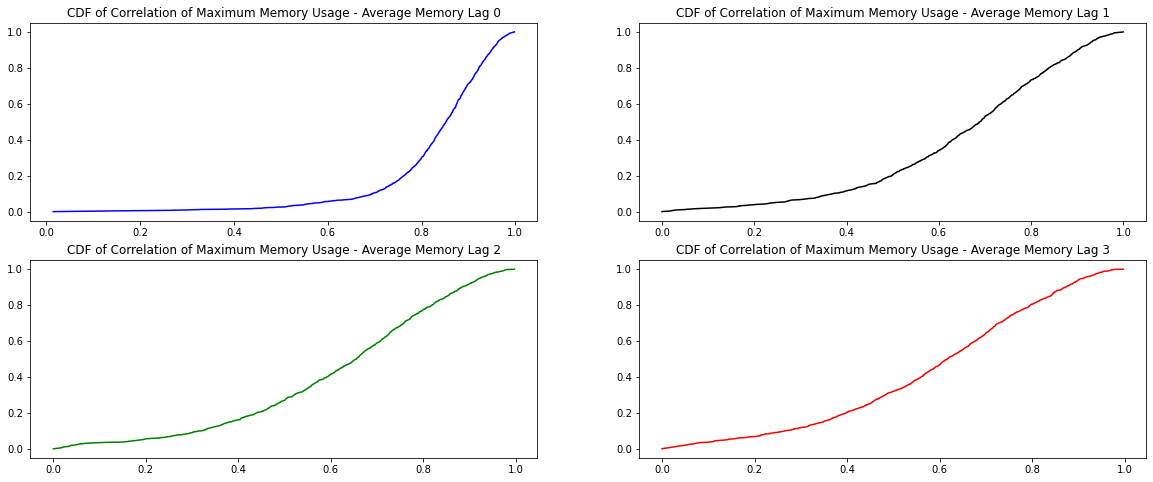

------------------------------------------------------------------------
average_usage.memory_max


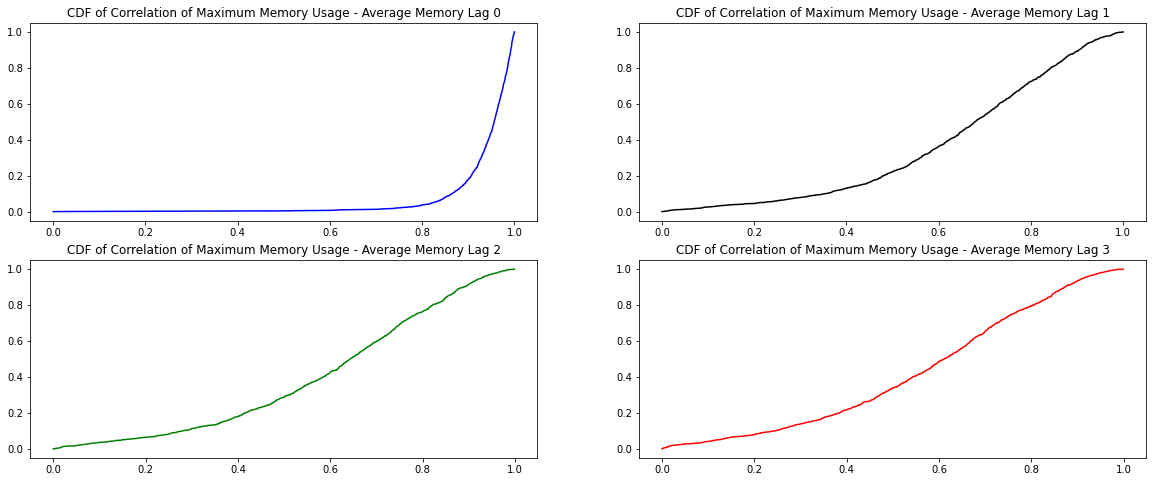

------------------------------------------------------------------------
average_usage.memory_std


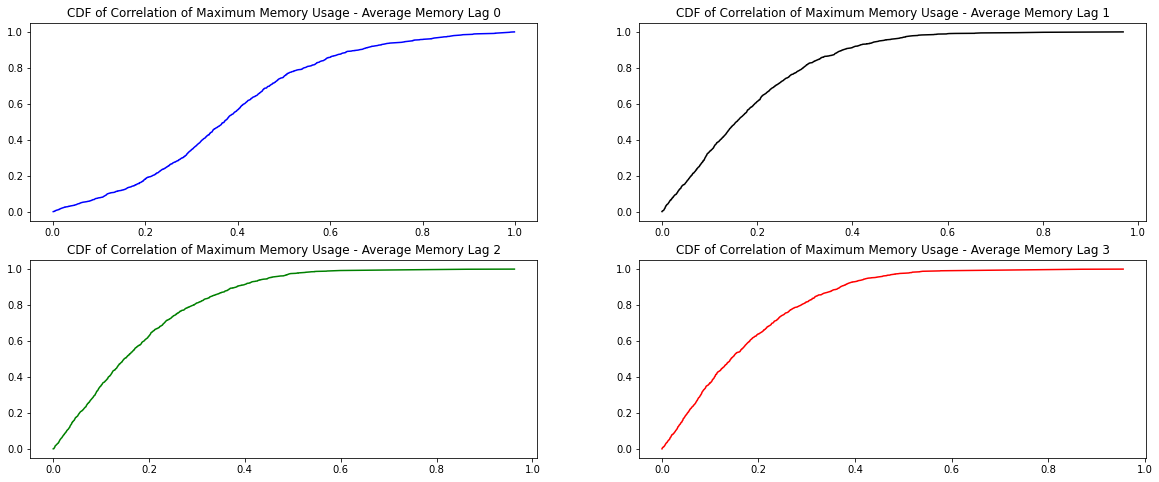

------------------------------------------------------------------------
average_usage.memory_median


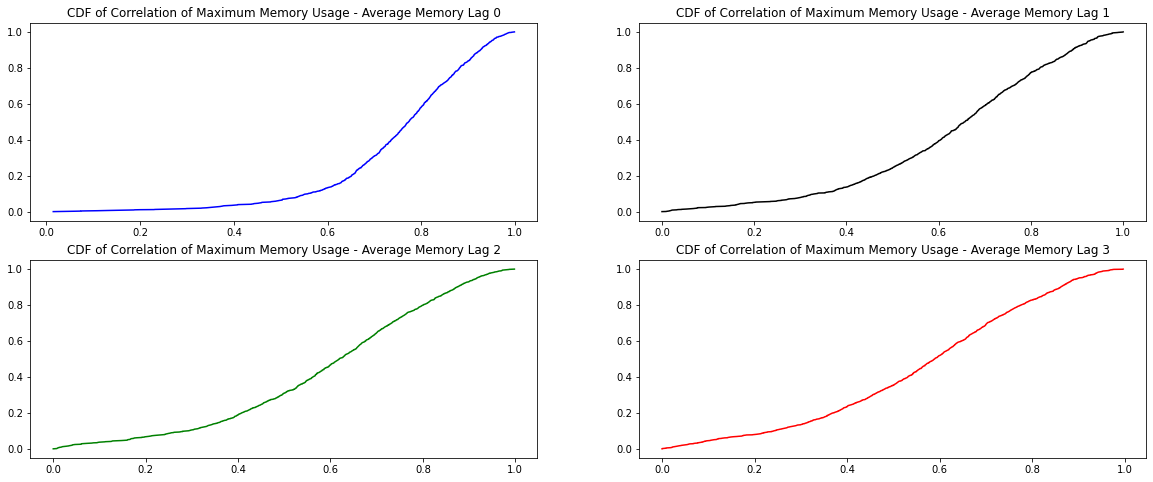

------------------------------------------------------------------------
average_usage.memory_range


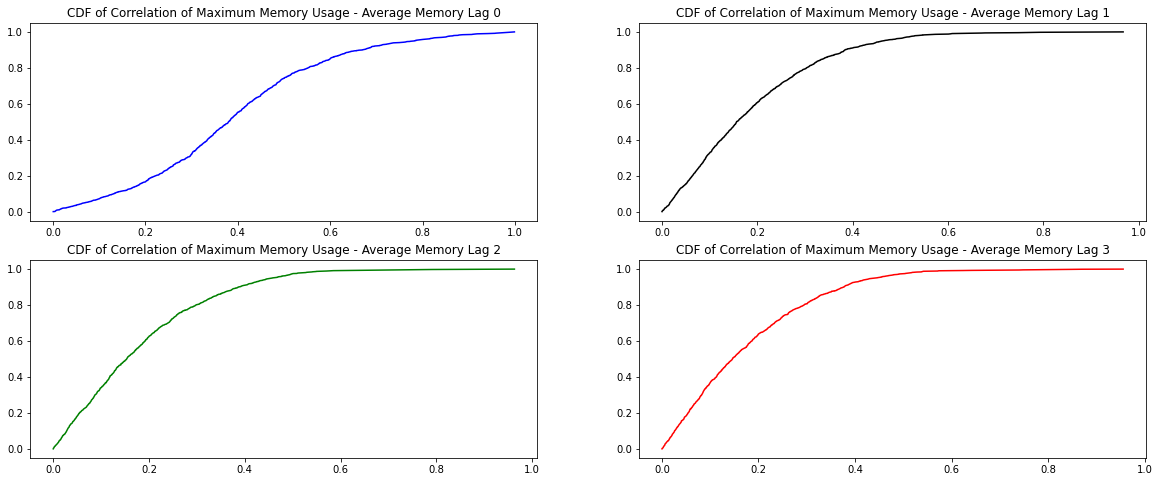

------------------------------------------------------------------------
maximum_usage.cpus_ts


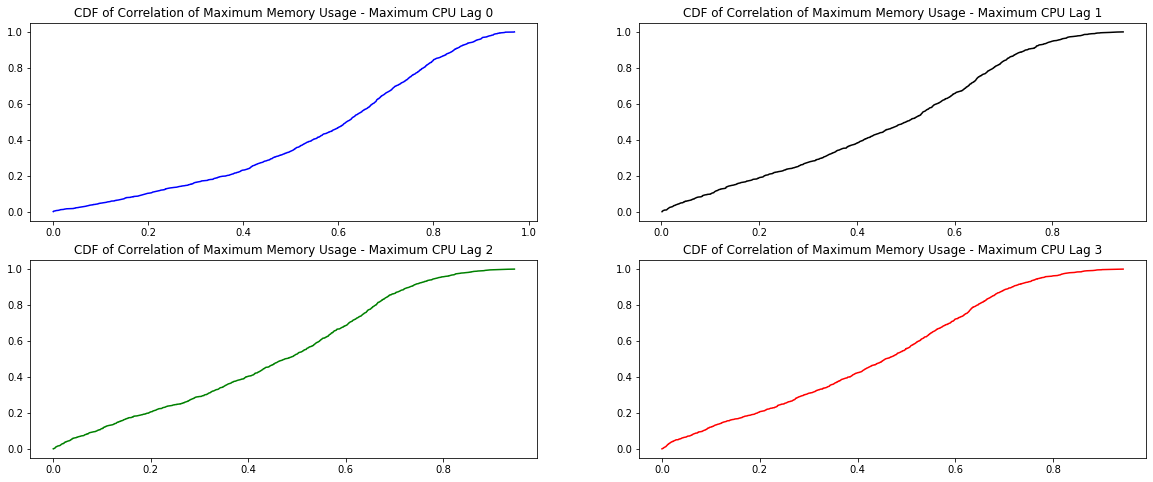

------------------------------------------------------------------------
maximum_usage.cpus_avg


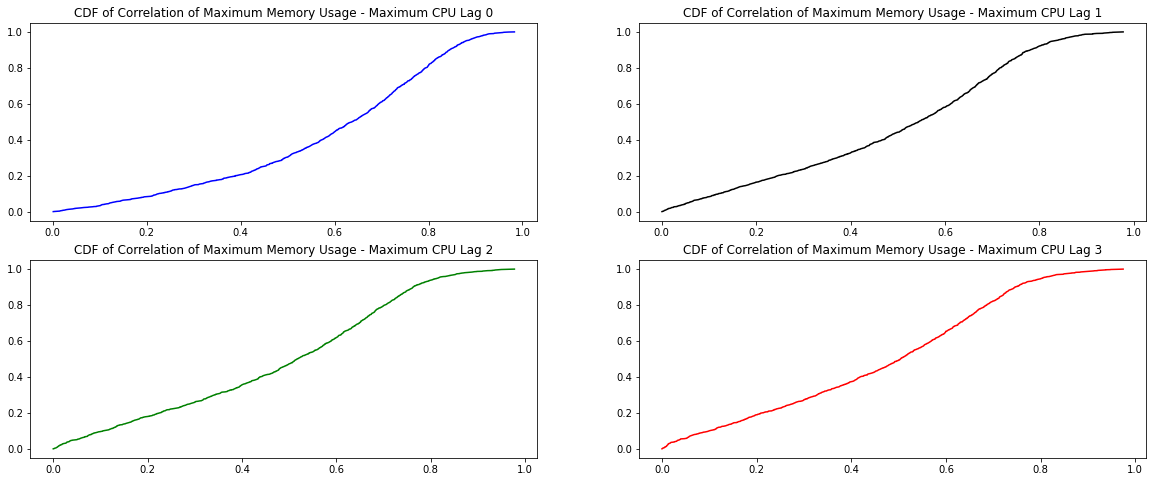

------------------------------------------------------------------------
maximum_usage.cpus_std


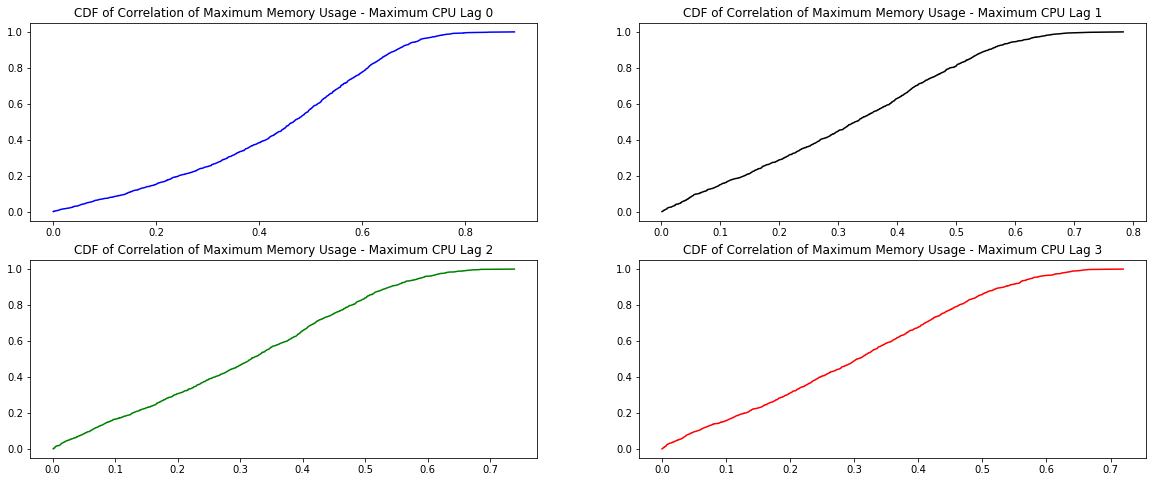

------------------------------------------------------------------------
maximum_usage.cpus_median


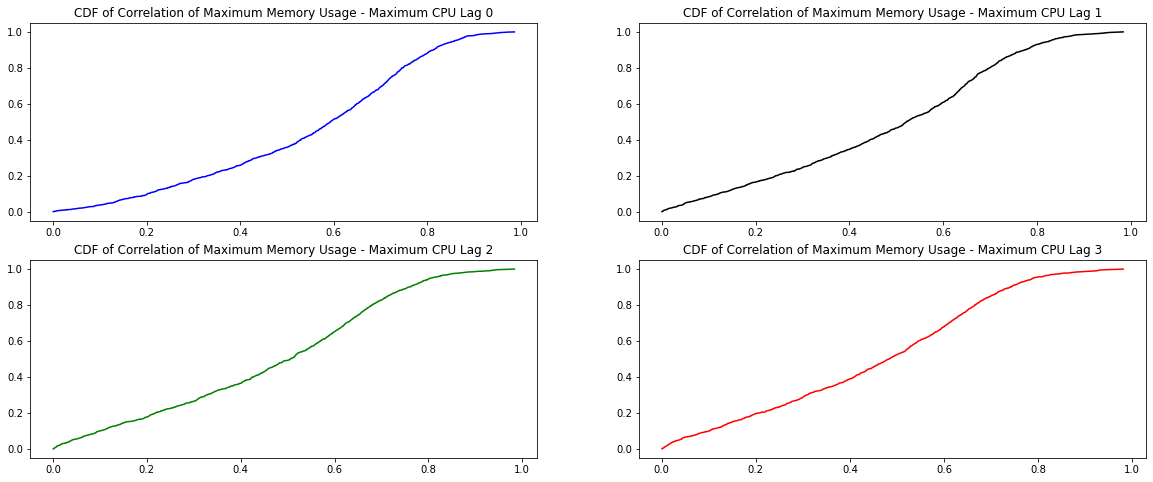

------------------------------------------------------------------------
maximum_usage.cpus_range


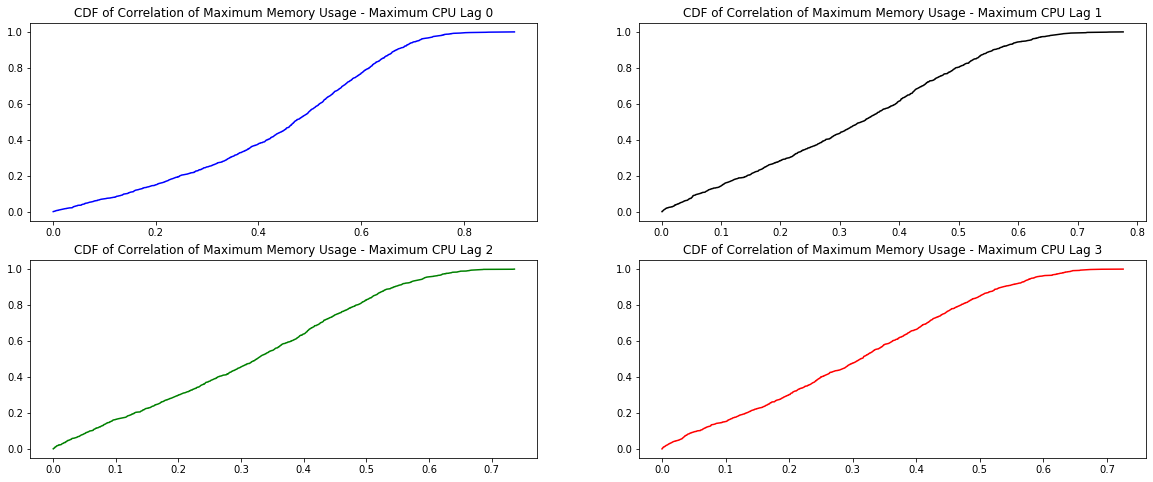

------------------------------------------------------------------------
average_usage.cpus_ts


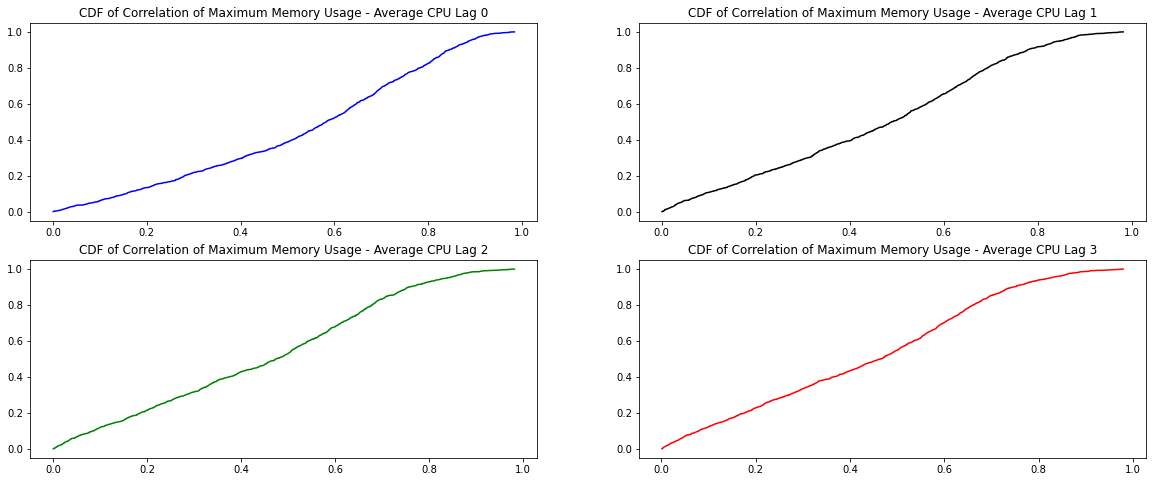

------------------------------------------------------------------------
average_usage.cpus_max


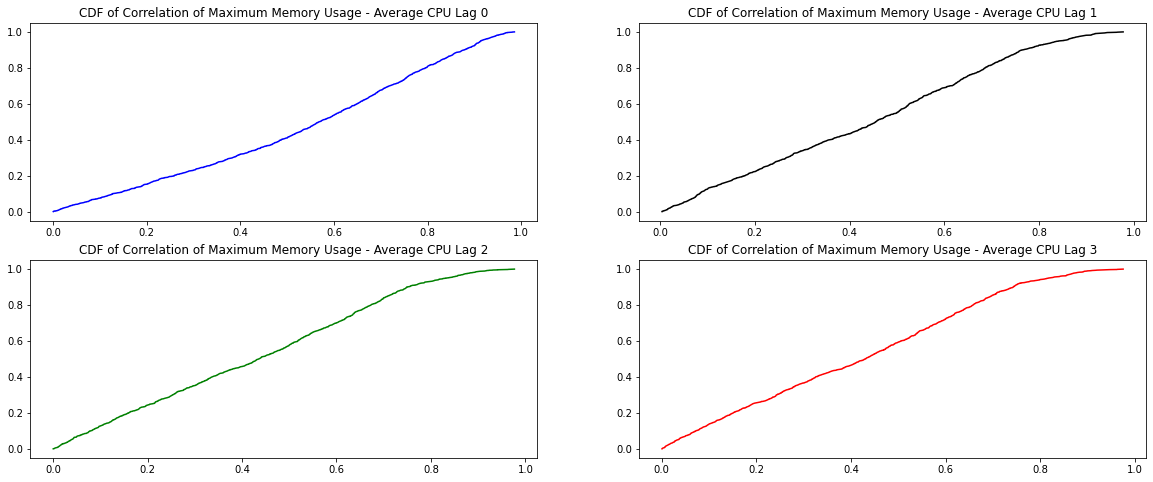

------------------------------------------------------------------------
average_usage.cpus_std


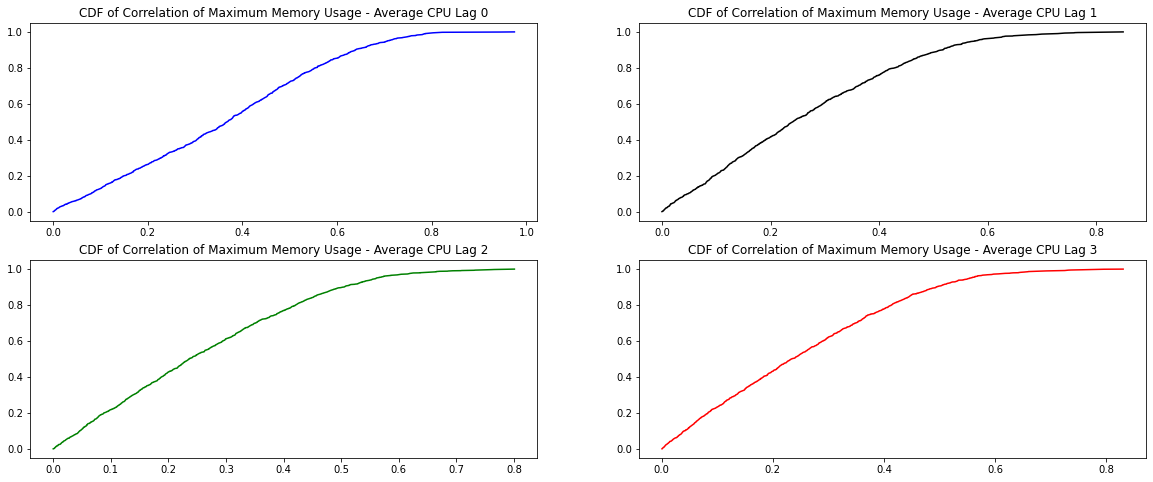

------------------------------------------------------------------------
average_usage.cpus_median


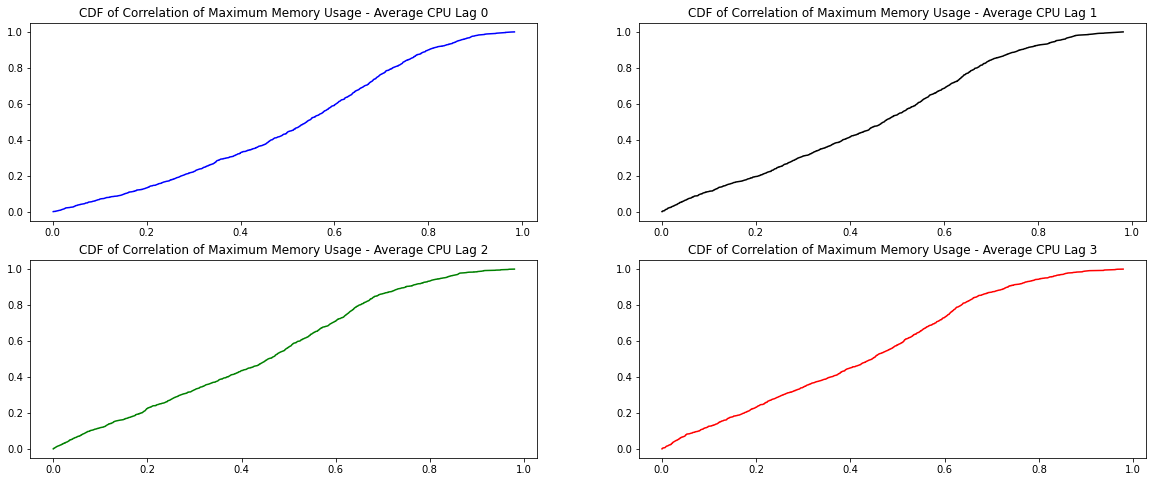

------------------------------------------------------------------------
average_usage.cpus_range


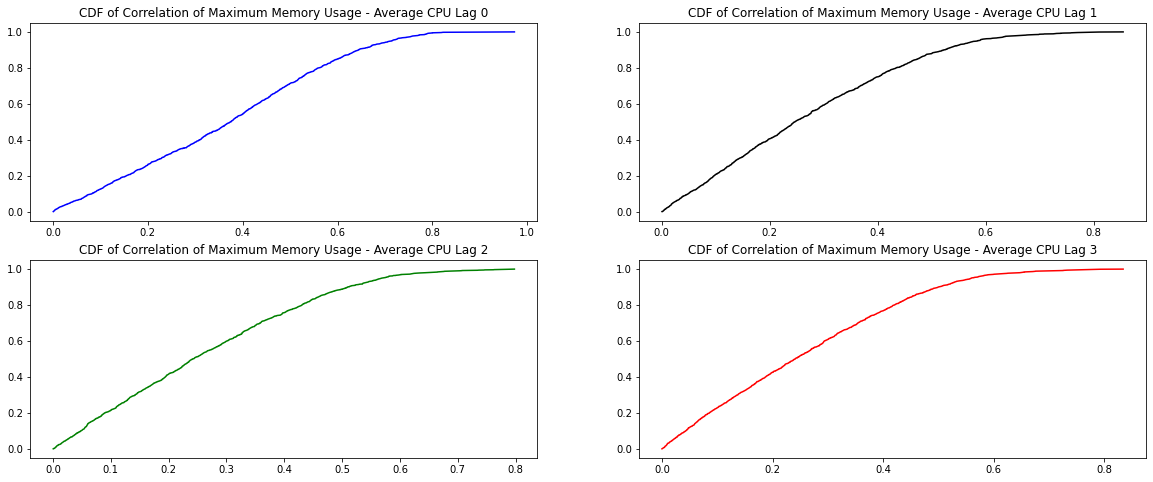

------------------------------------------------------------------------

average_usage.memory


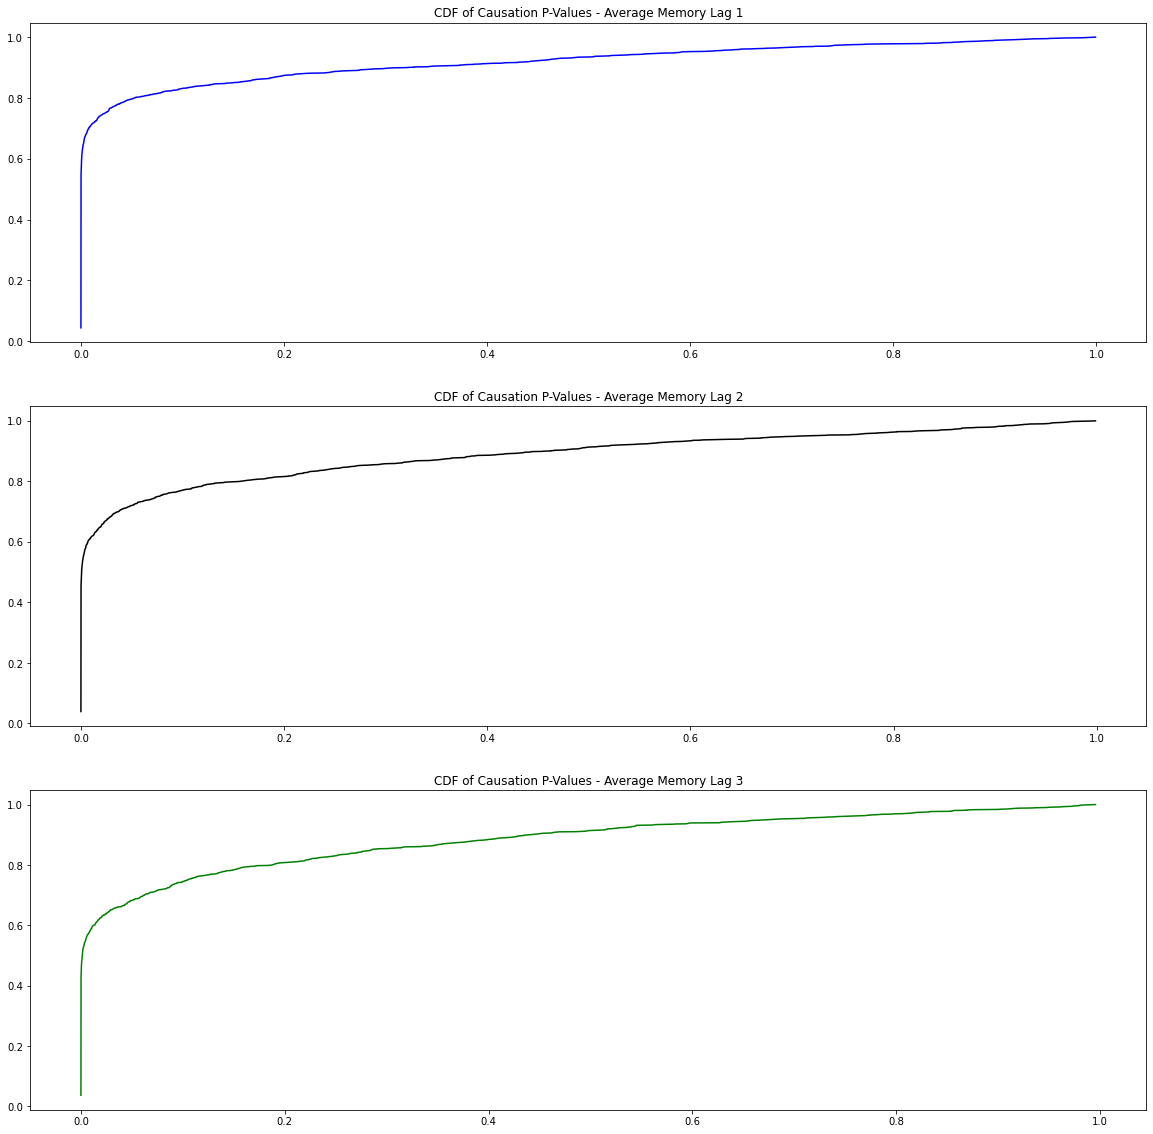

maximum_usage.cpus


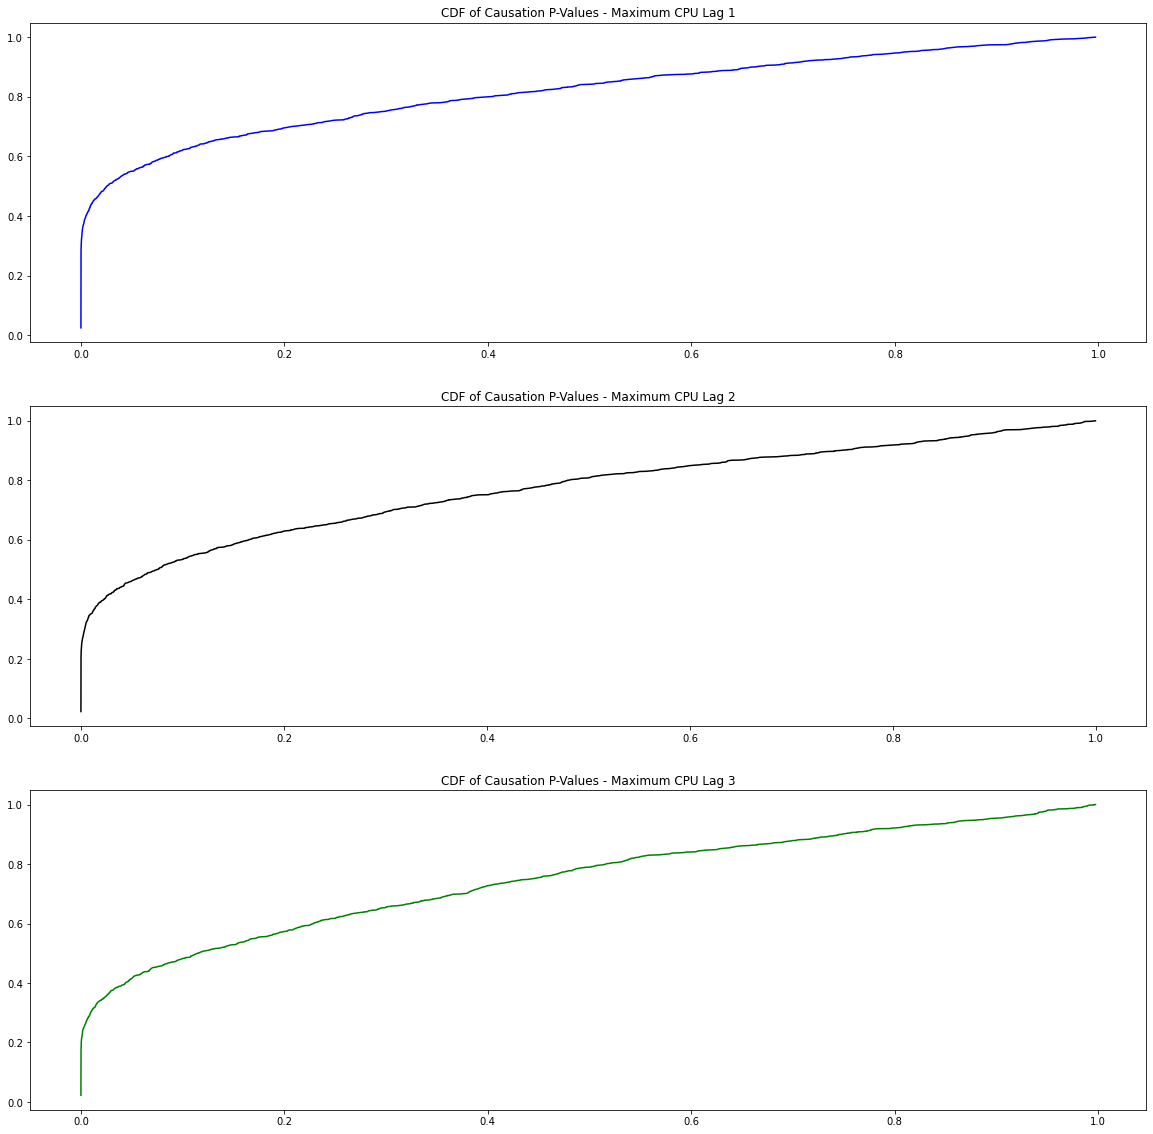

average_usage.cpus


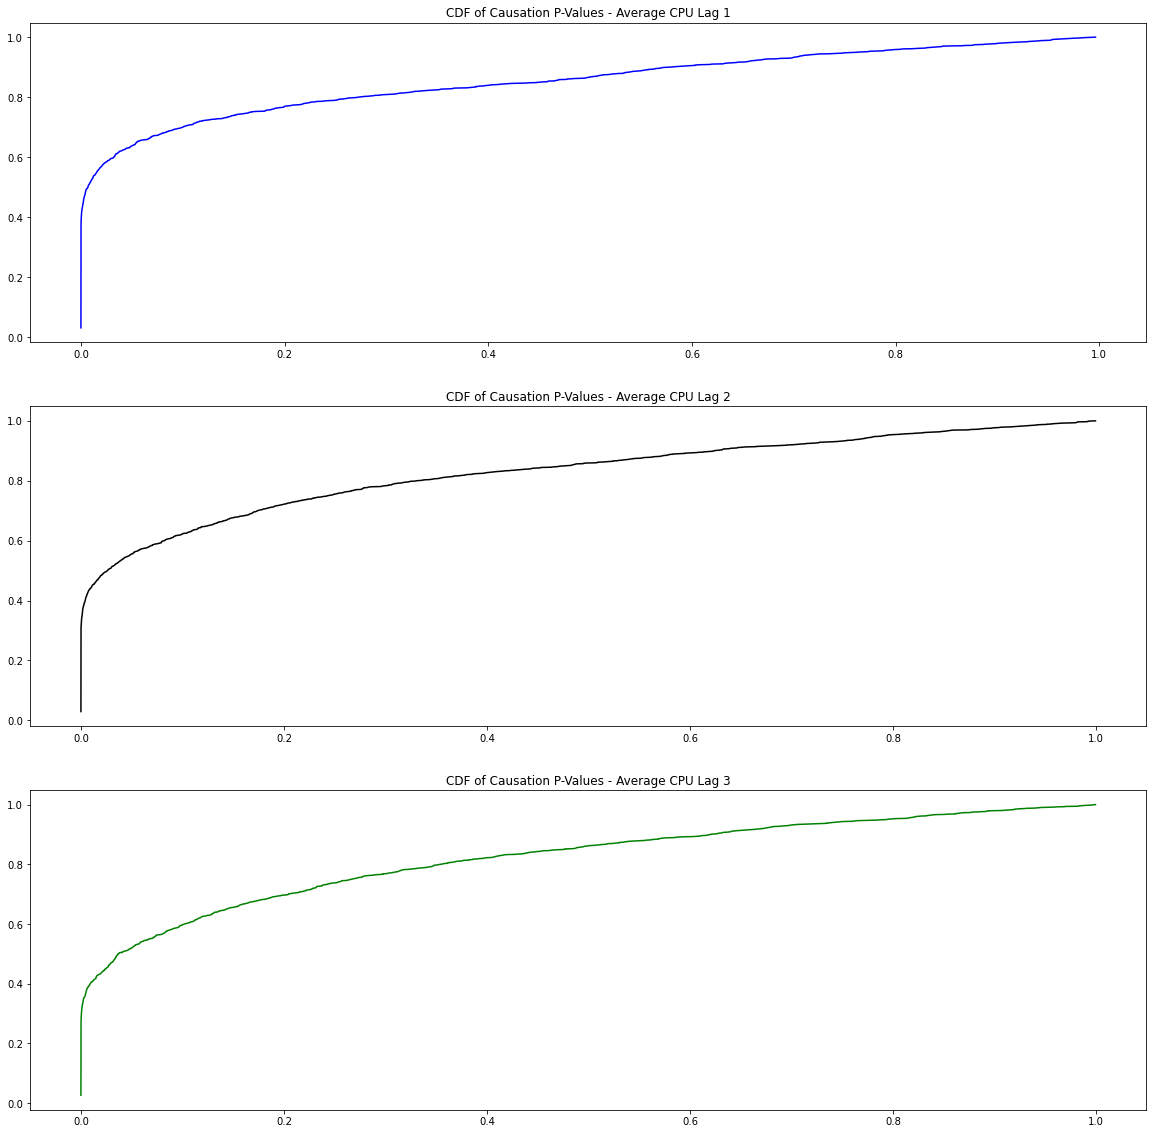

In [15]:
max_mem_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_mem_3"
stats_dfs['max_mem_agg_3'] = summarize_statistical_results(max_mem_3_dir, specs.MAX_MEM_COL, "ssr_chi2test", "Maximum Memory")

### Maximum CPU Usage - 3 Period Aggregation

Total Trace Count: 1423

Stationarity Results
Number of Stationary Traces: 38.93%
Number of Stationary Traces after 1 Level Differencing: 59.1%
Number of Stationary Traces after 2 Level Differencing: 0.91%
Other: 1.05%

Correlation Results
Number of traces with correlation of maximum_usage.cpus and maximum_usage.memory >= 0.7 or <= -0.7: 476
Number of traces with correlation of maximum_usage.cpus and average_usage.memory >= 0.7 or <= -0.7: 256
Number of traces with correlation of maximum_usage.cpus and average_usage.cpus >= 0.7 or <= -0.7: 922



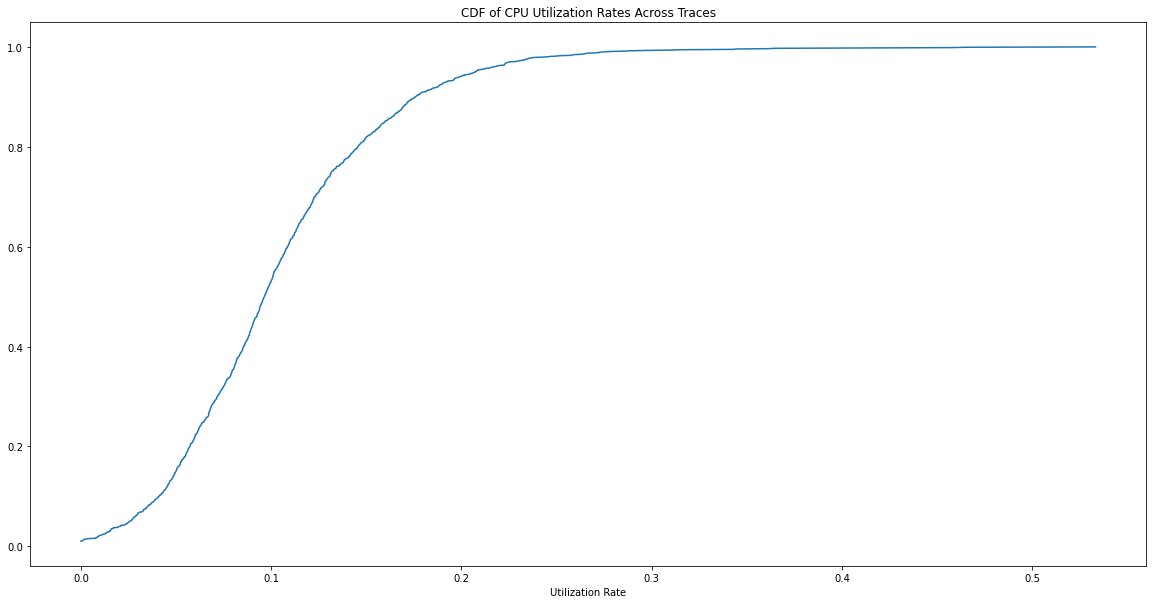

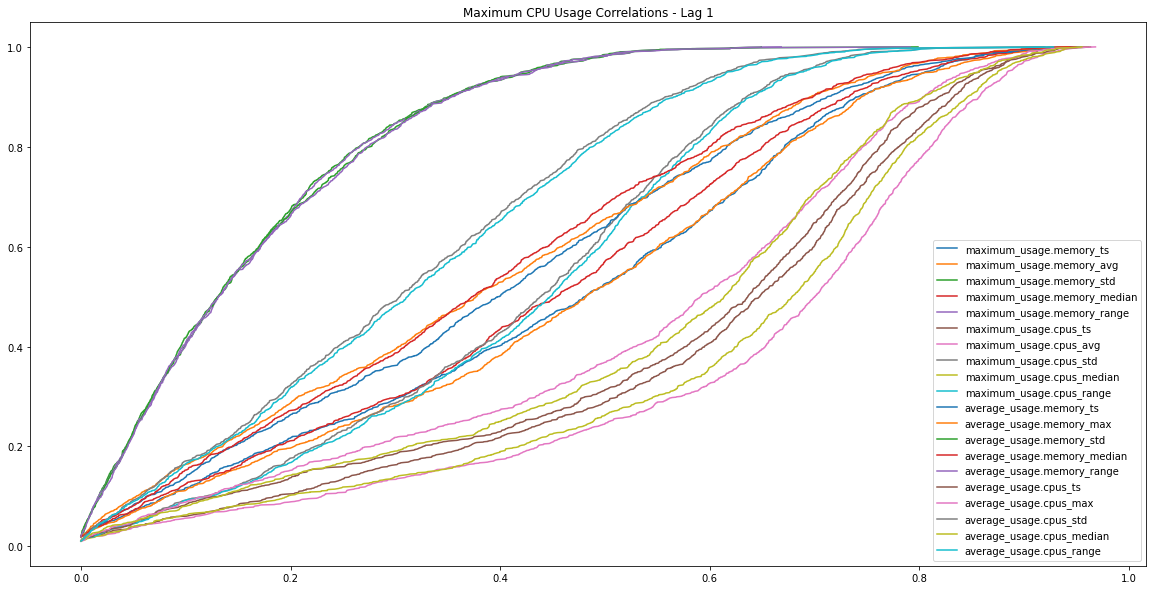

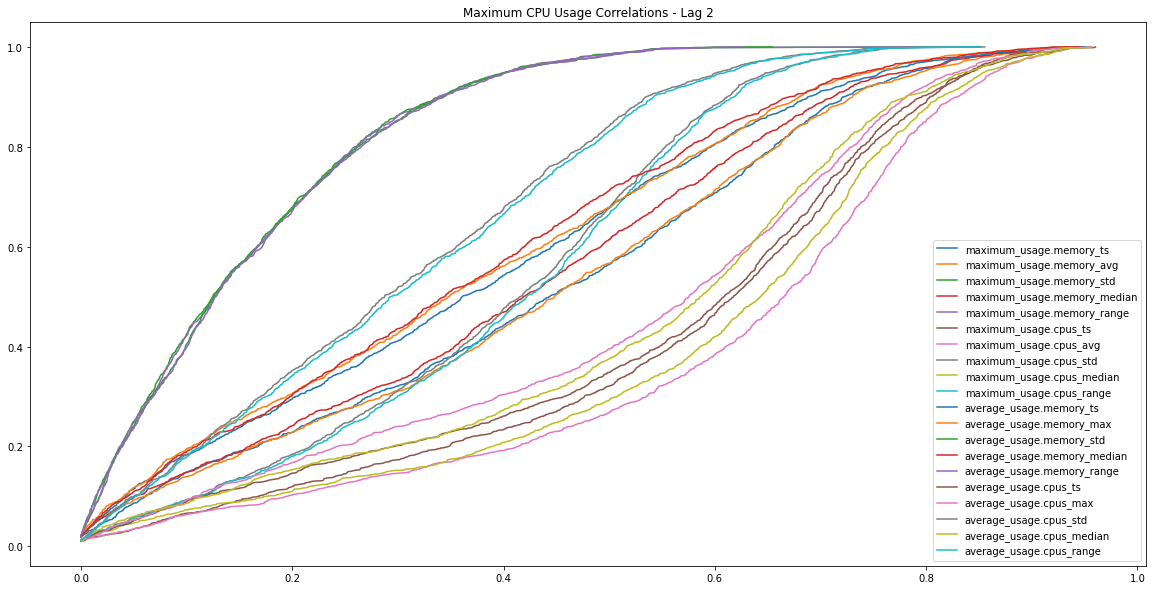

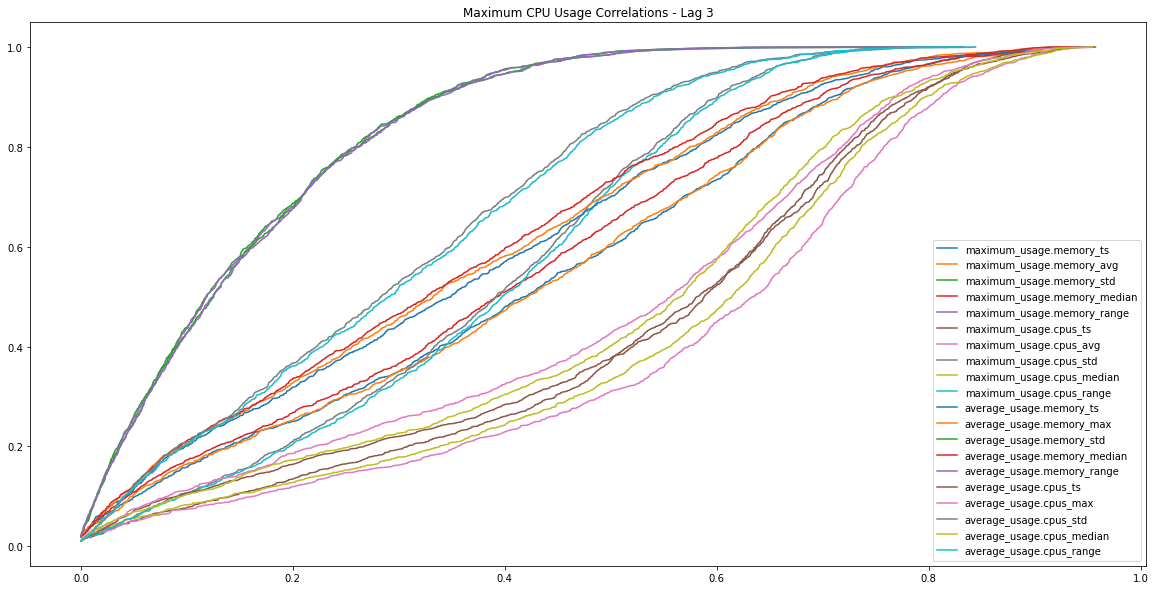

maximum_usage.memory_ts


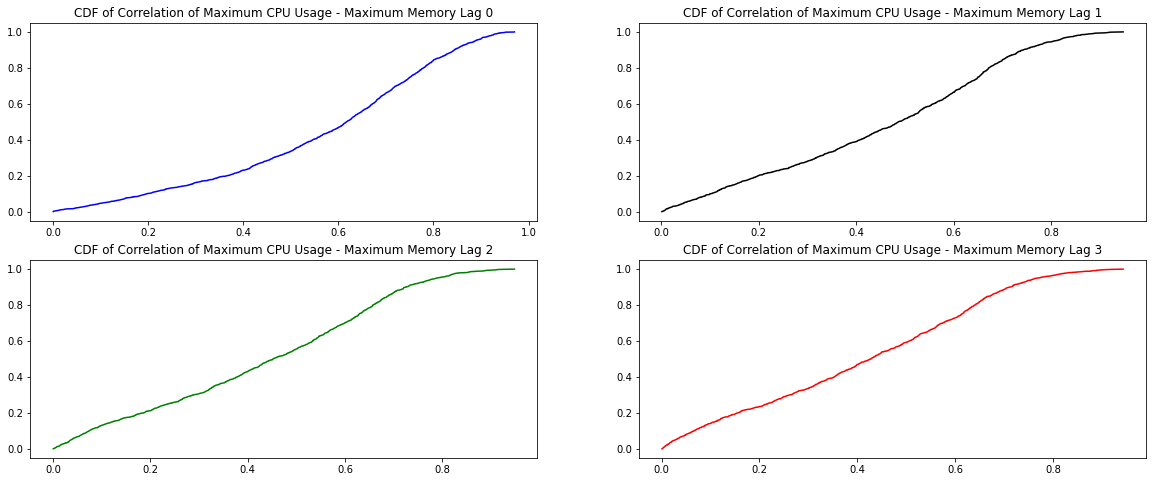

------------------------------------------------------------------------
maximum_usage.memory_avg


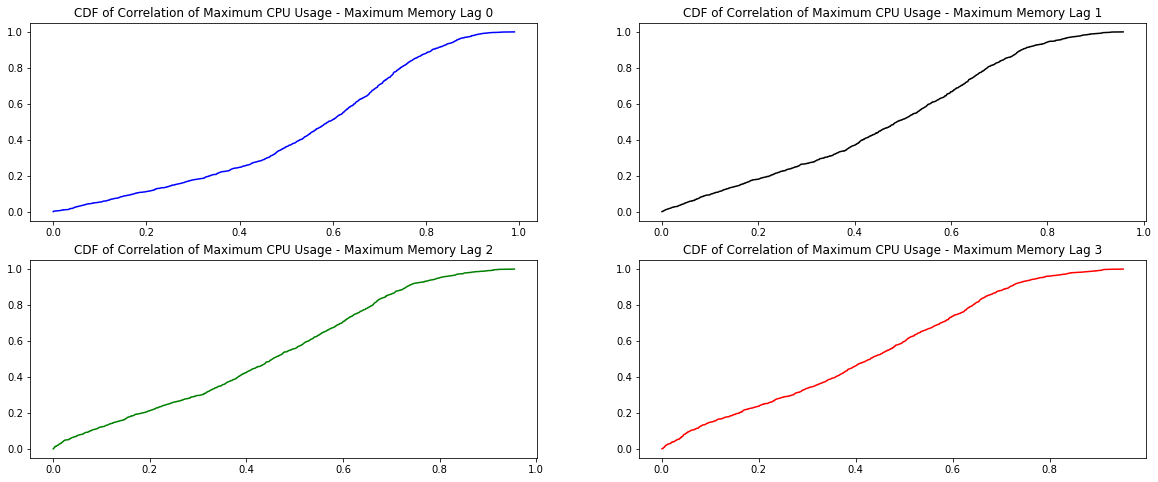

------------------------------------------------------------------------
maximum_usage.memory_std


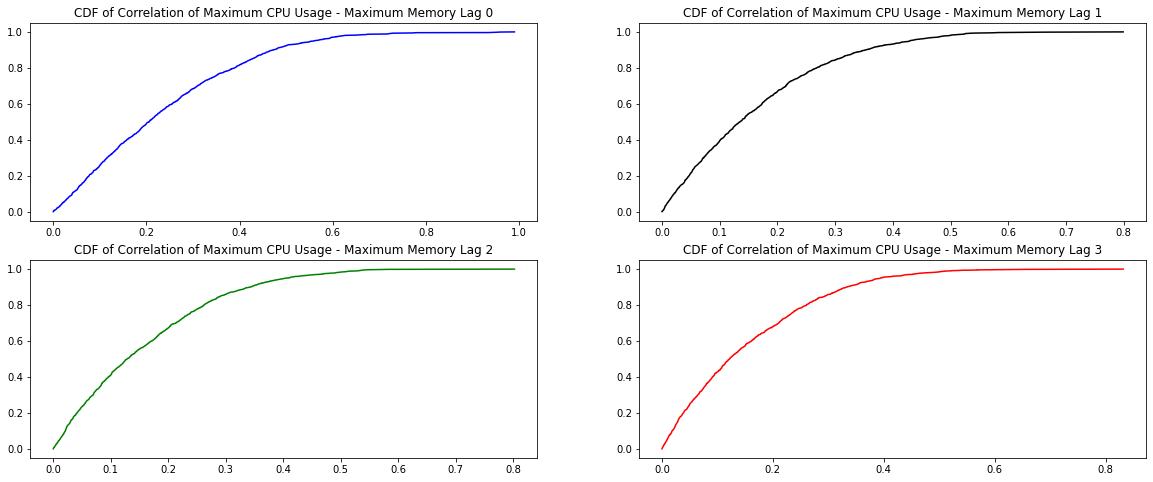

------------------------------------------------------------------------
maximum_usage.memory_median


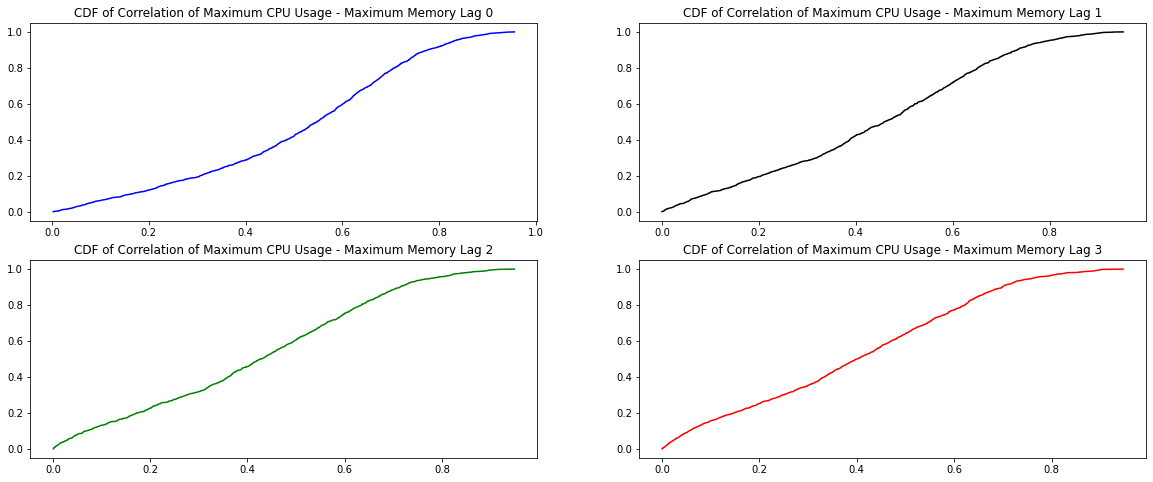

------------------------------------------------------------------------
maximum_usage.memory_range


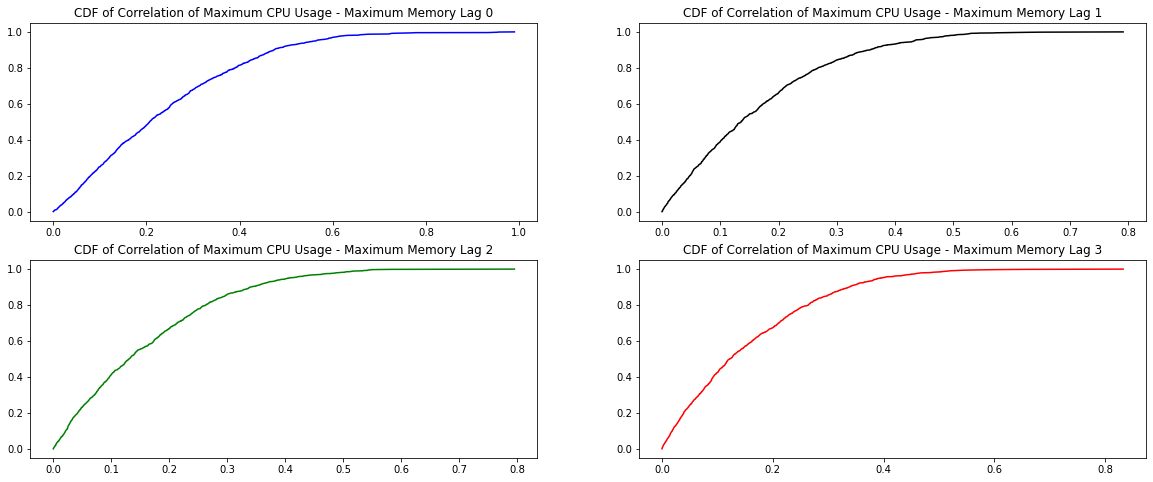

------------------------------------------------------------------------
average_usage.memory_ts


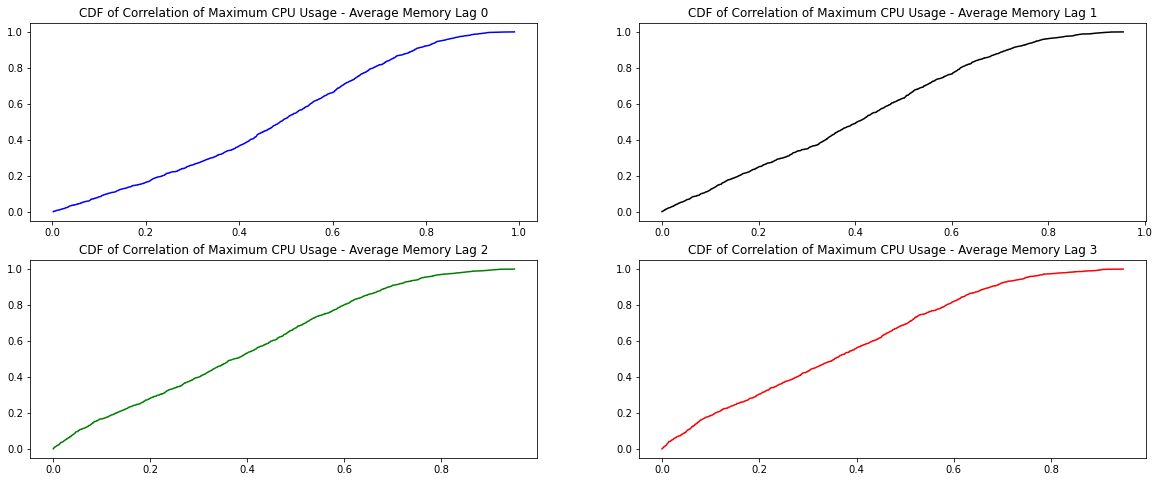

------------------------------------------------------------------------
average_usage.memory_max


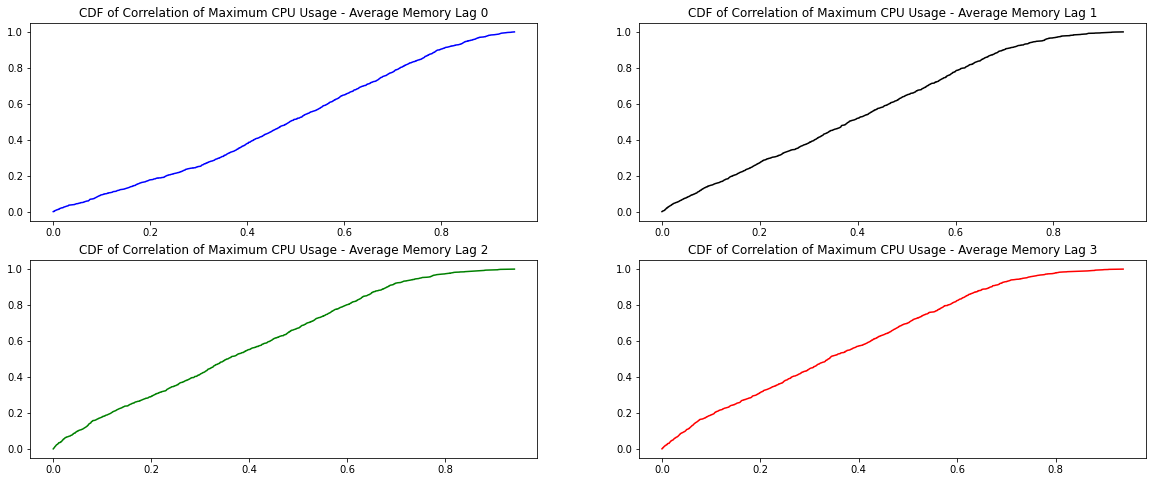

------------------------------------------------------------------------
average_usage.memory_std


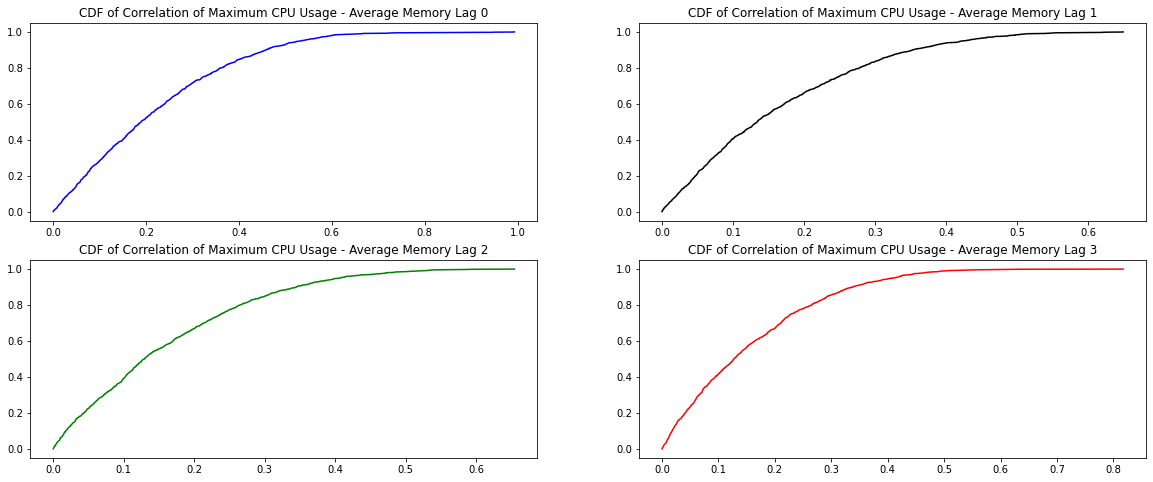

------------------------------------------------------------------------
average_usage.memory_median


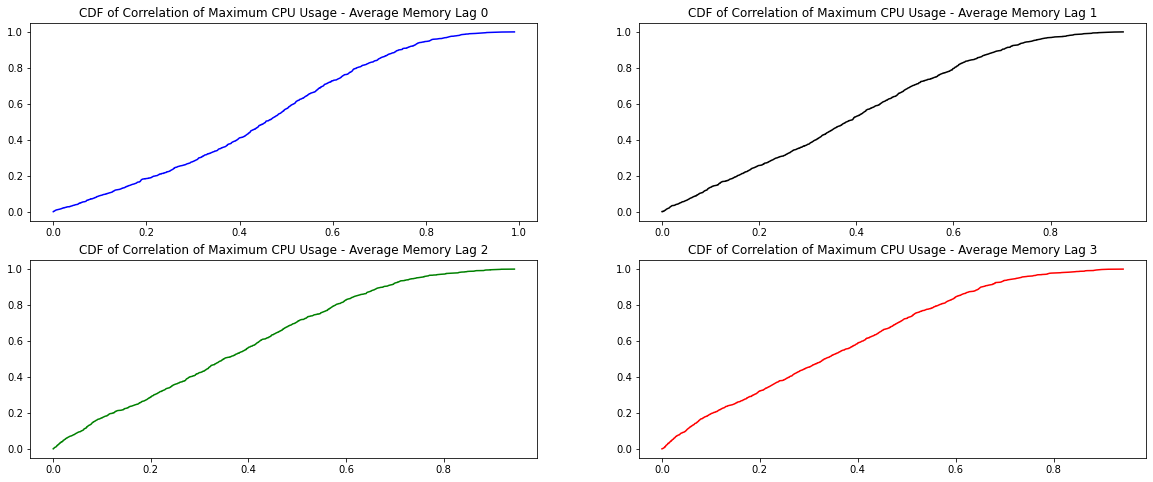

------------------------------------------------------------------------
average_usage.memory_range


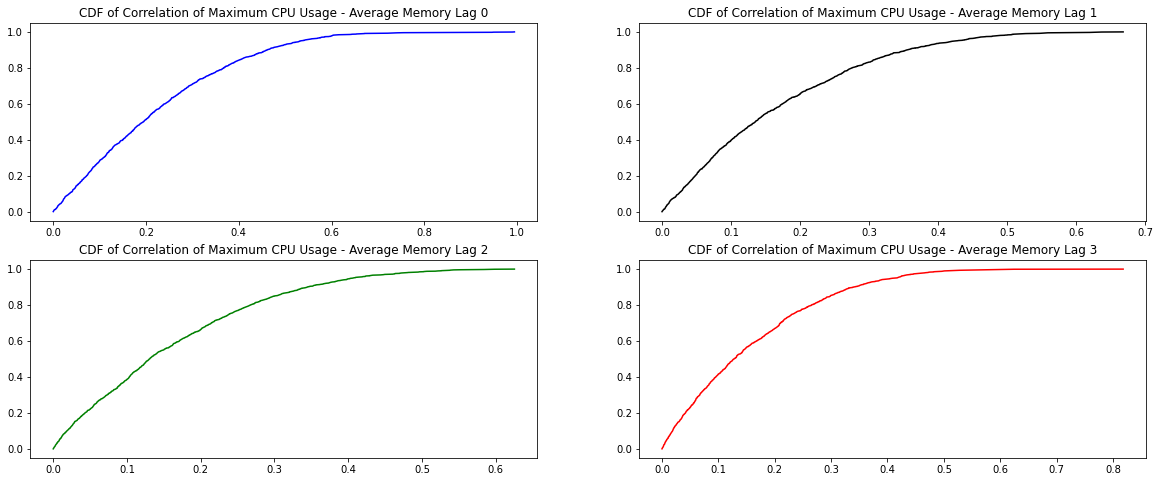

------------------------------------------------------------------------
maximum_usage.cpus_ts


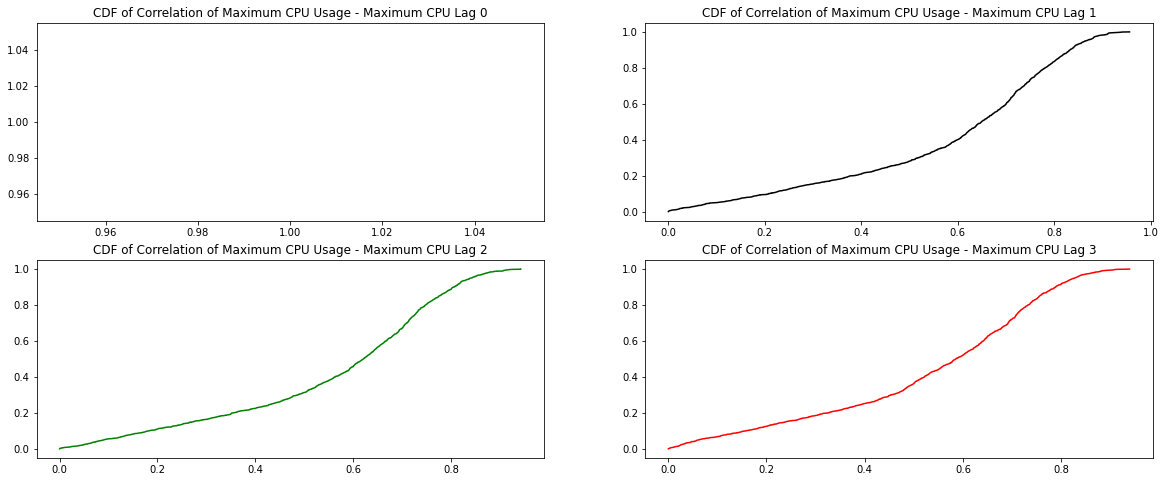

------------------------------------------------------------------------
maximum_usage.cpus_avg


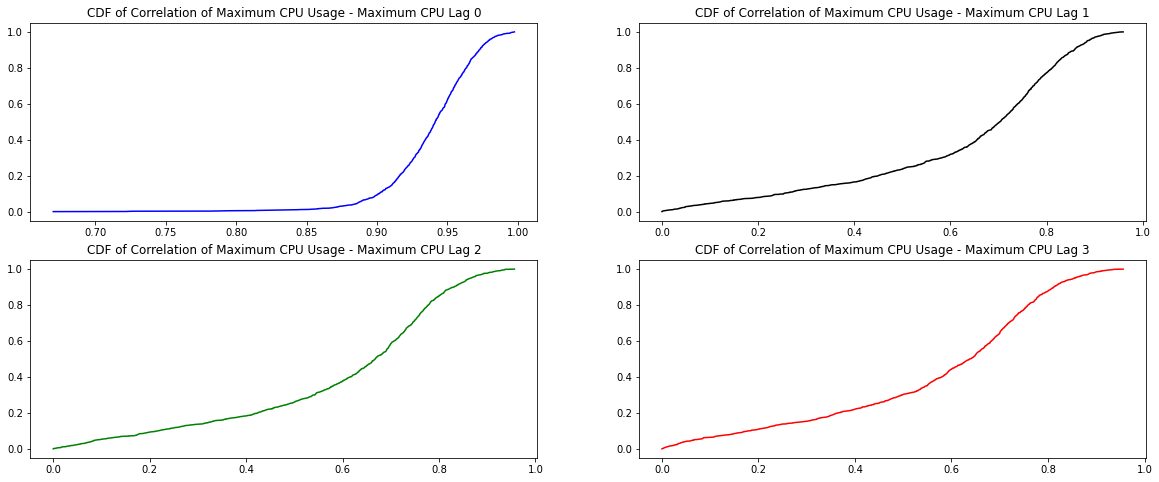

------------------------------------------------------------------------
maximum_usage.cpus_std


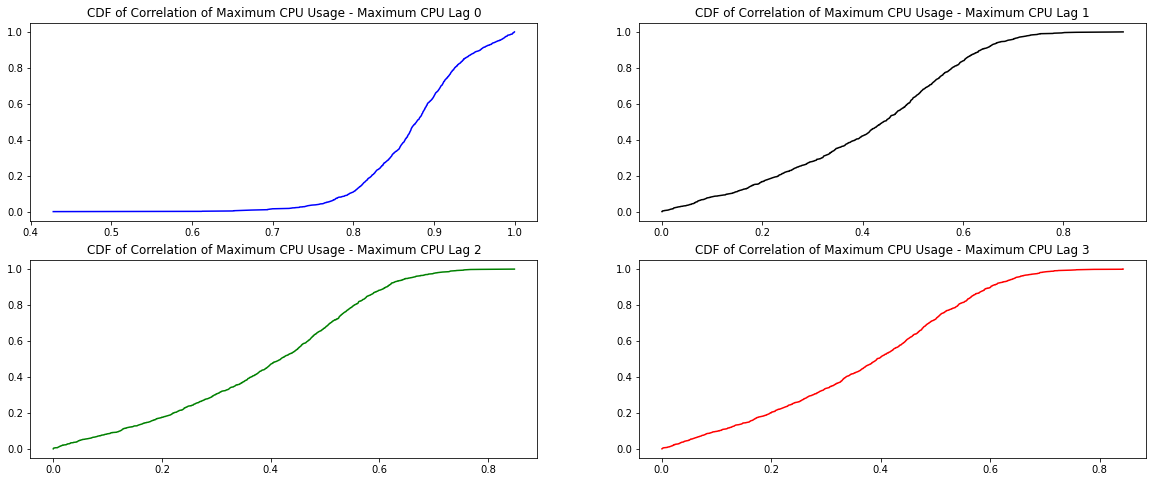

------------------------------------------------------------------------
maximum_usage.cpus_median


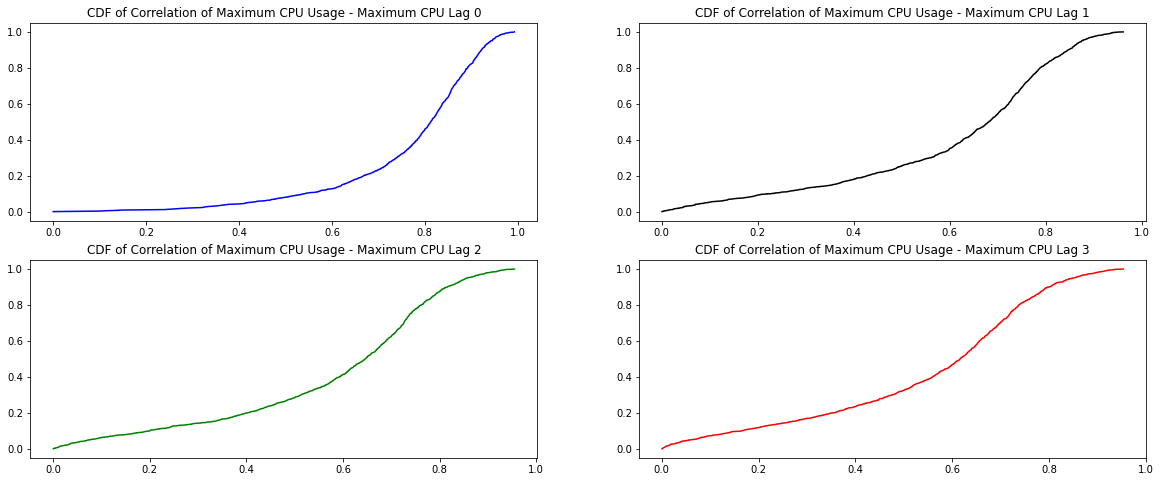

------------------------------------------------------------------------
maximum_usage.cpus_range


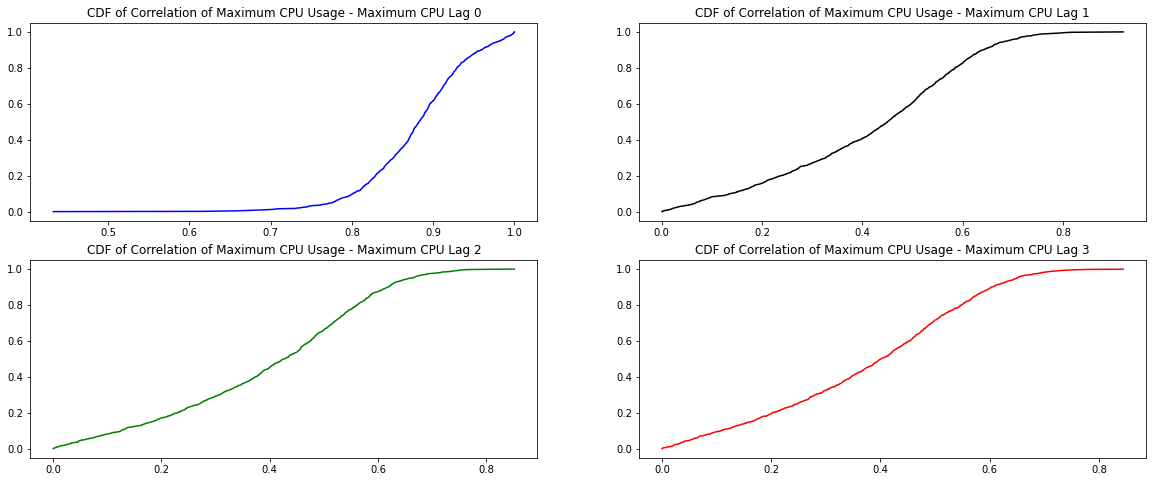

------------------------------------------------------------------------
average_usage.cpus_ts


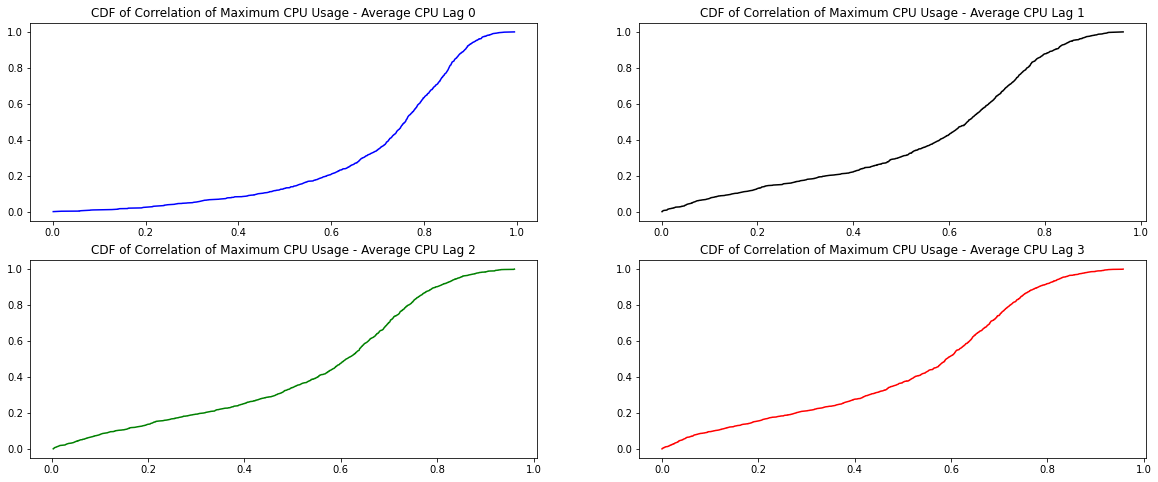

------------------------------------------------------------------------
average_usage.cpus_max


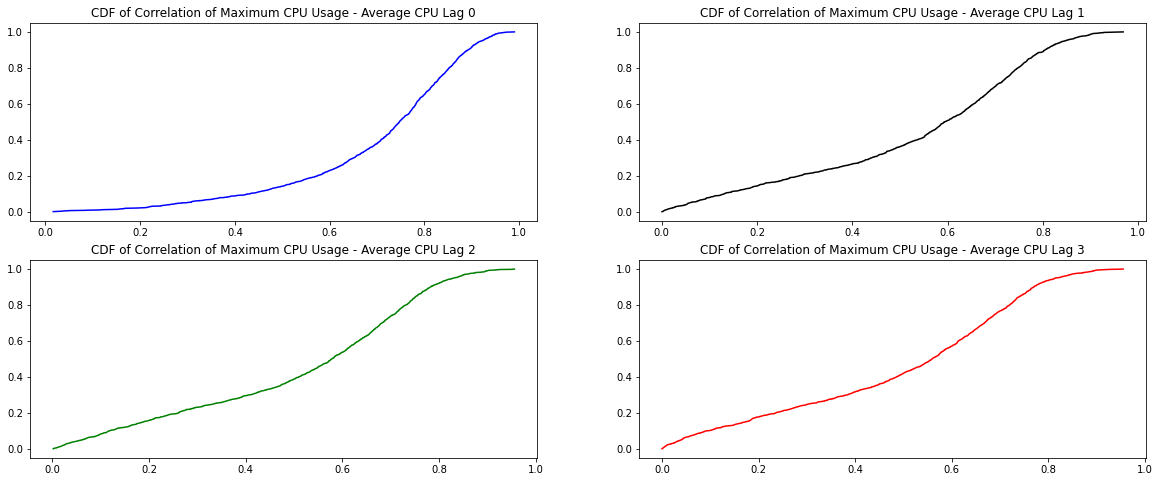

------------------------------------------------------------------------
average_usage.cpus_std


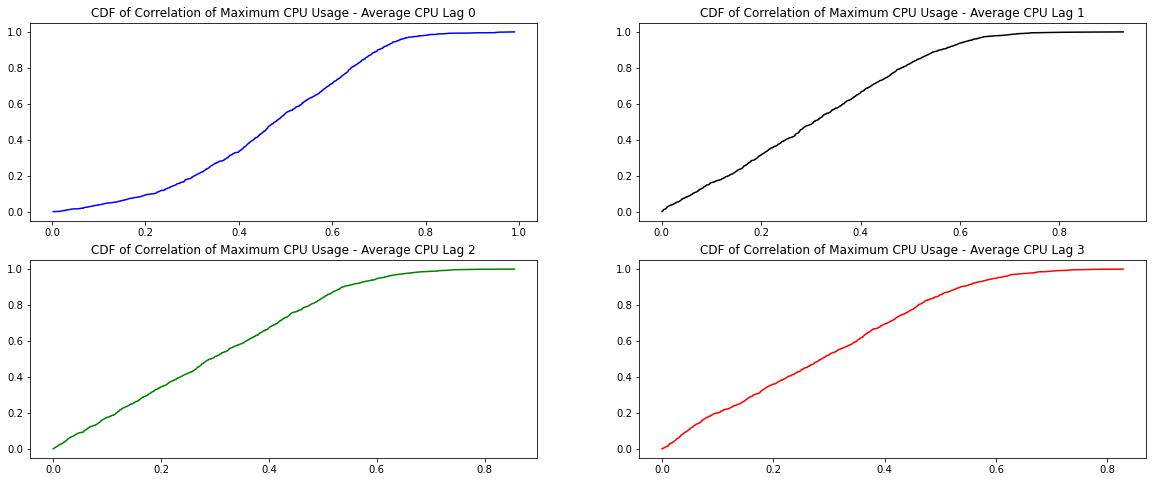

------------------------------------------------------------------------
average_usage.cpus_median


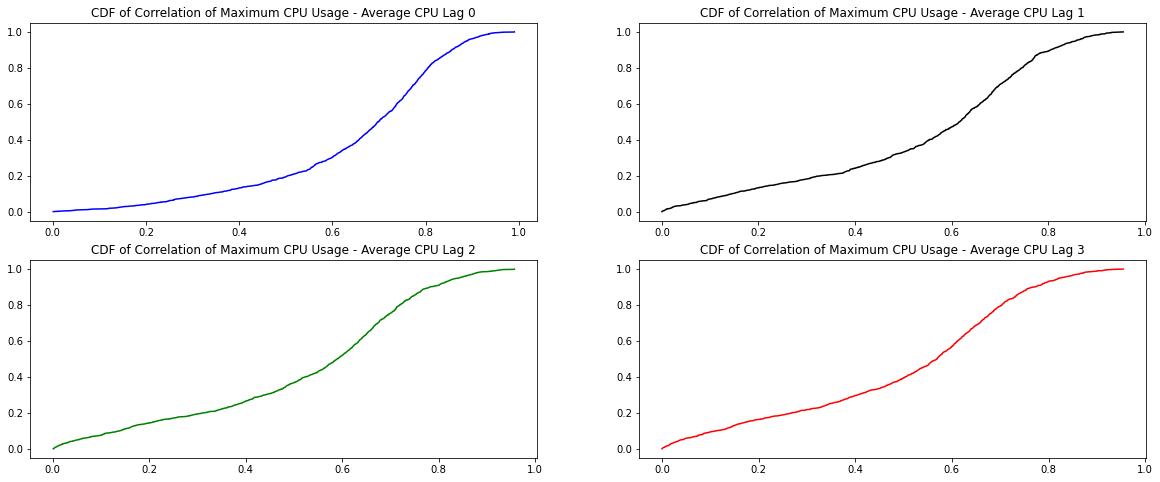

------------------------------------------------------------------------
average_usage.cpus_range


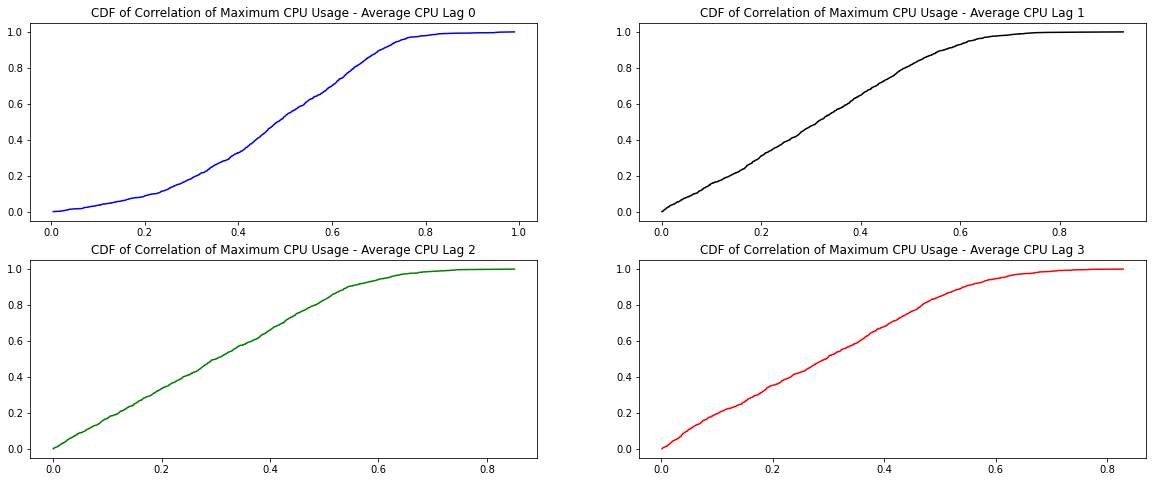

------------------------------------------------------------------------

maximum_usage.memory


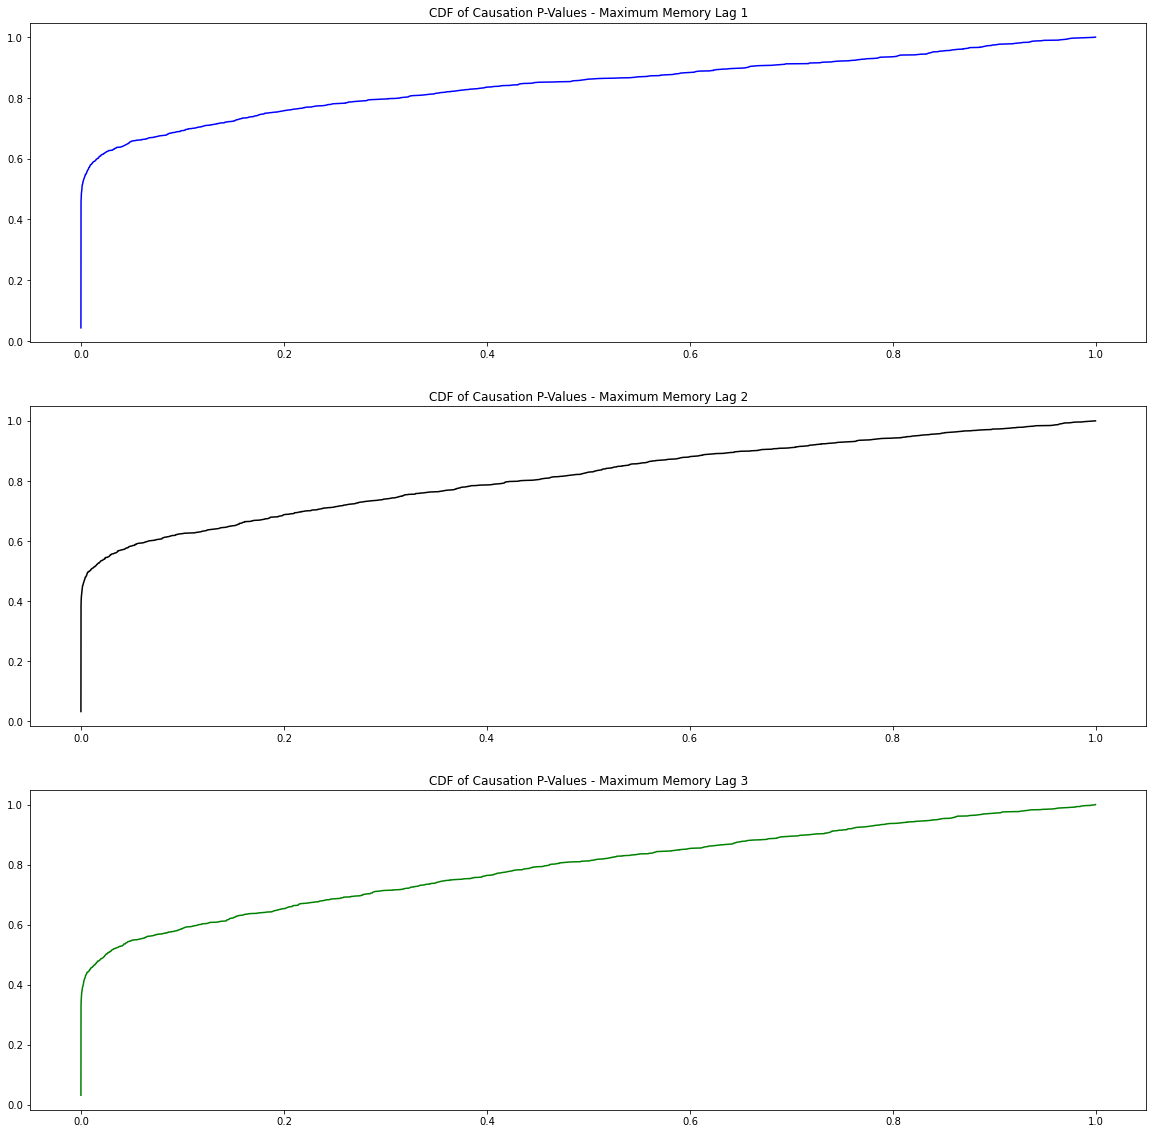

average_usage.memory


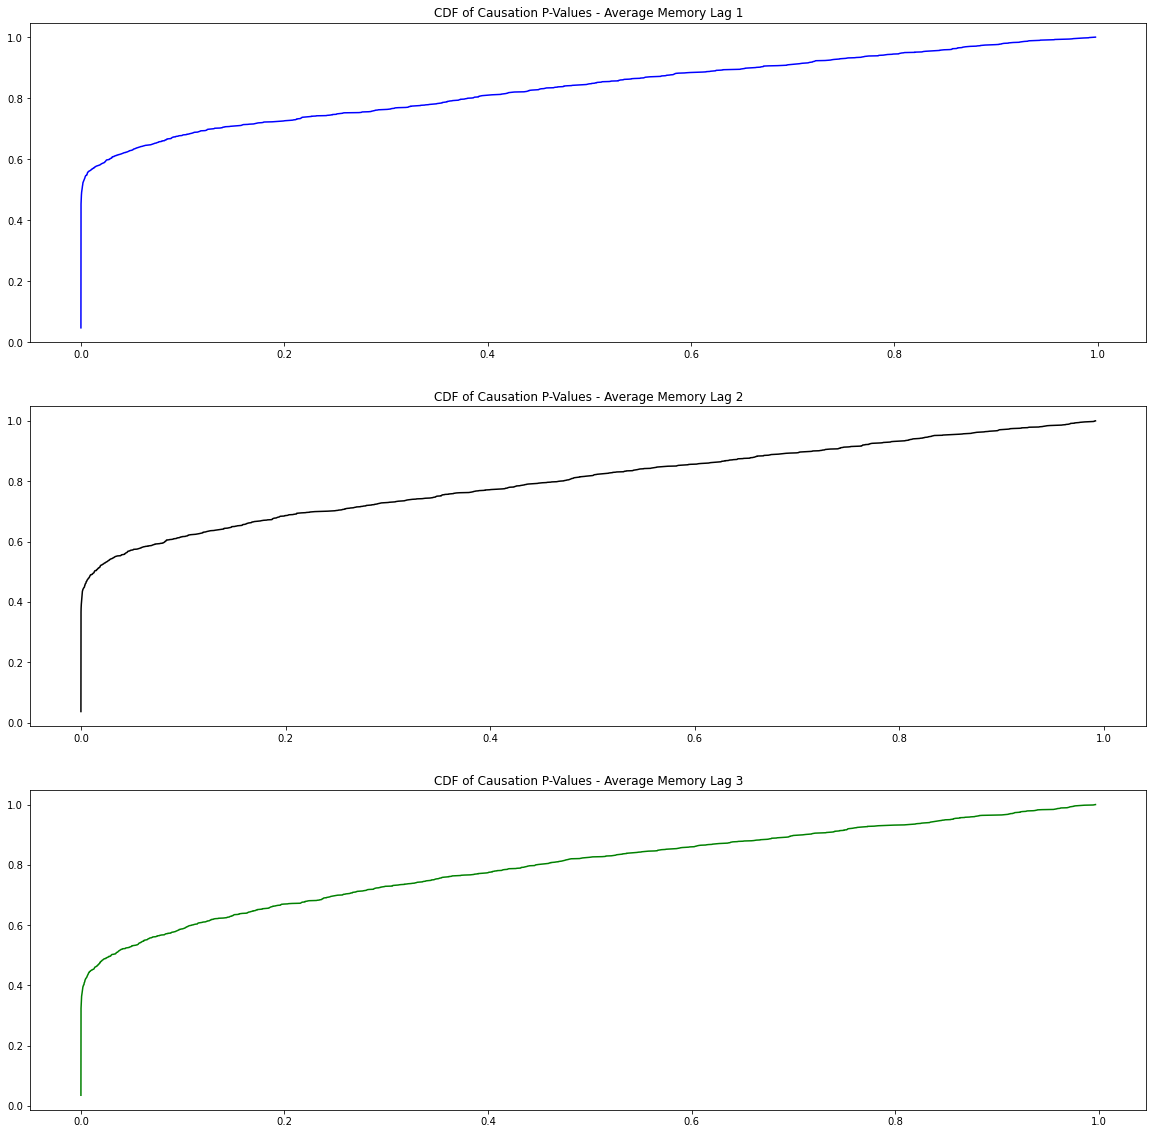

average_usage.cpus


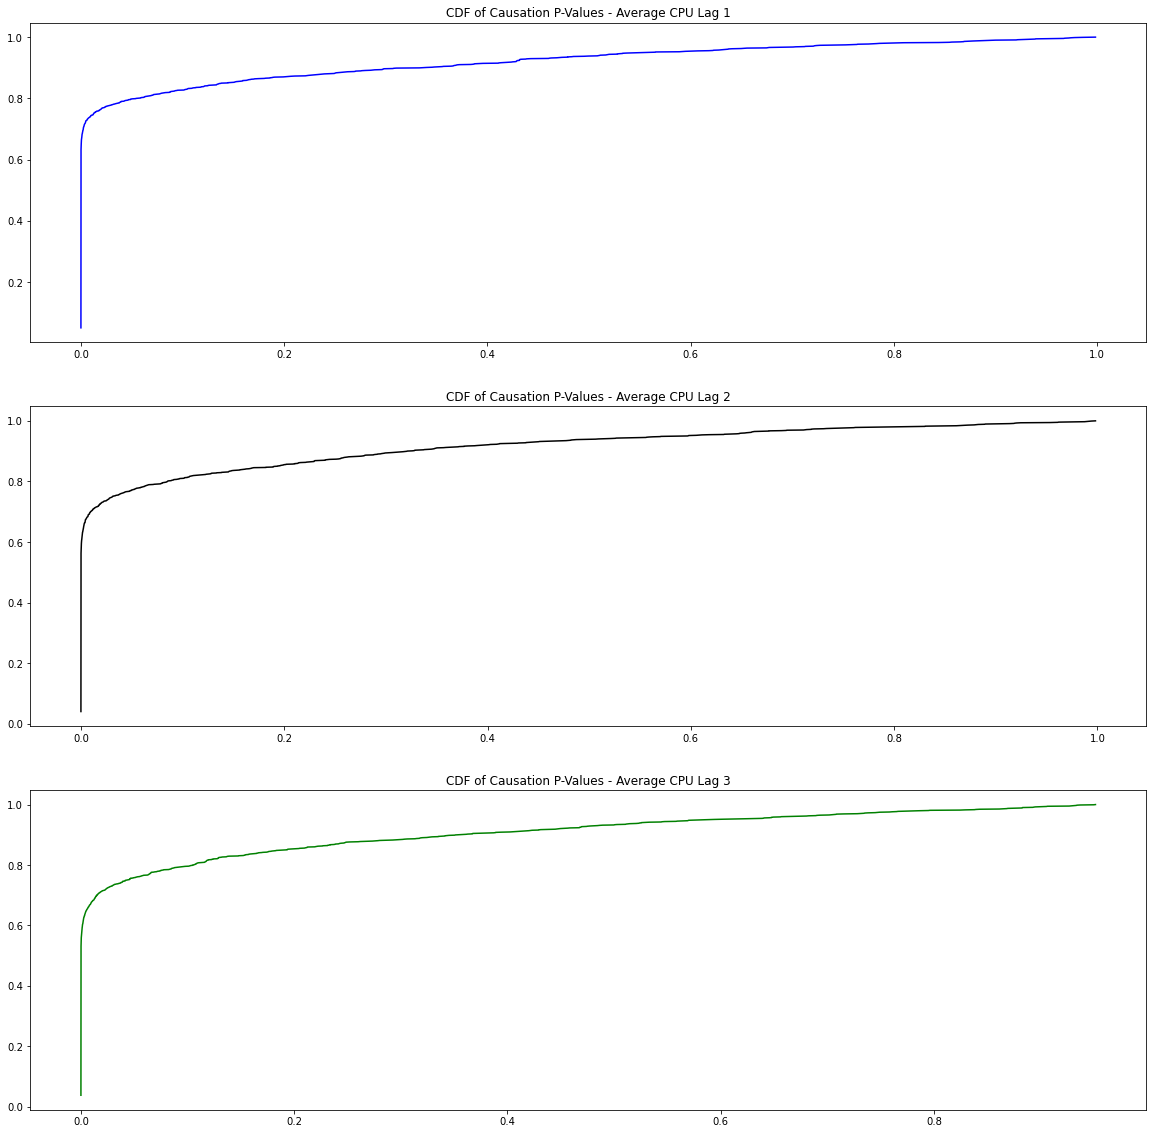

In [16]:
max_cpu_3_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_cpu_3"
stats_dfs['max_cpu_agg_3'] = summarize_statistical_results(max_cpu_3_dir, specs.MAX_CPU_COL, "ssr_chi2test", "Maximum CPU")

### Maximum Memory Usage - 24 Period Aggregation

Total Trace Count: 732

Stationarity Results
Number of Stationary Traces: 30.19%
Number of Stationary Traces after 1 Level Differencing: 66.94%
Number of Stationary Traces after 2 Level Differencing: 1.09%
Other: 1.78%

Correlation Results
Number of traces with correlation of maximum_usage.memory and average_usage.memory >= 0.7 or <= -0.7: 366
Number of traces with correlation of maximum_usage.memory and maximum_usage.cpus >= 0.7 or <= -0.7: 266
Number of traces with correlation of maximum_usage.memory and average_usage.cpus >= 0.7 or <= -0.7: 228



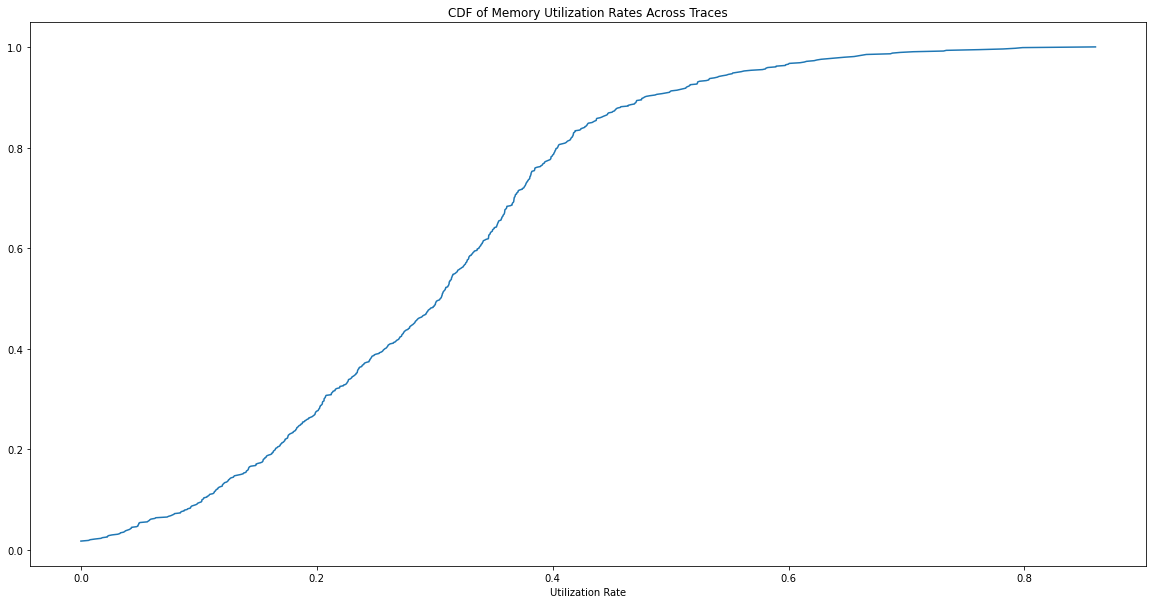

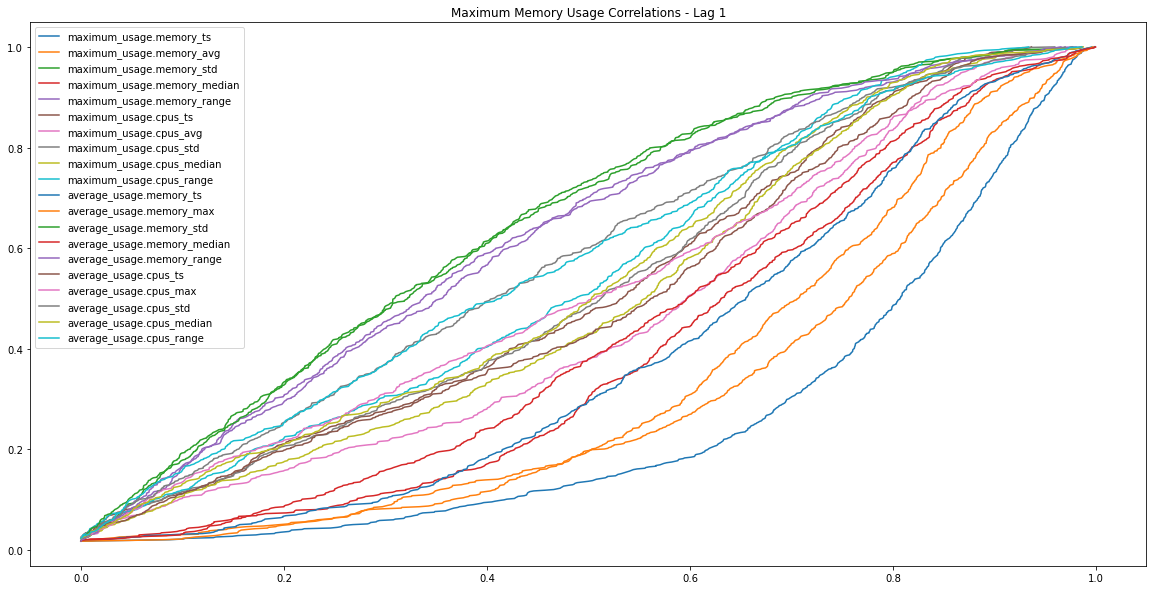

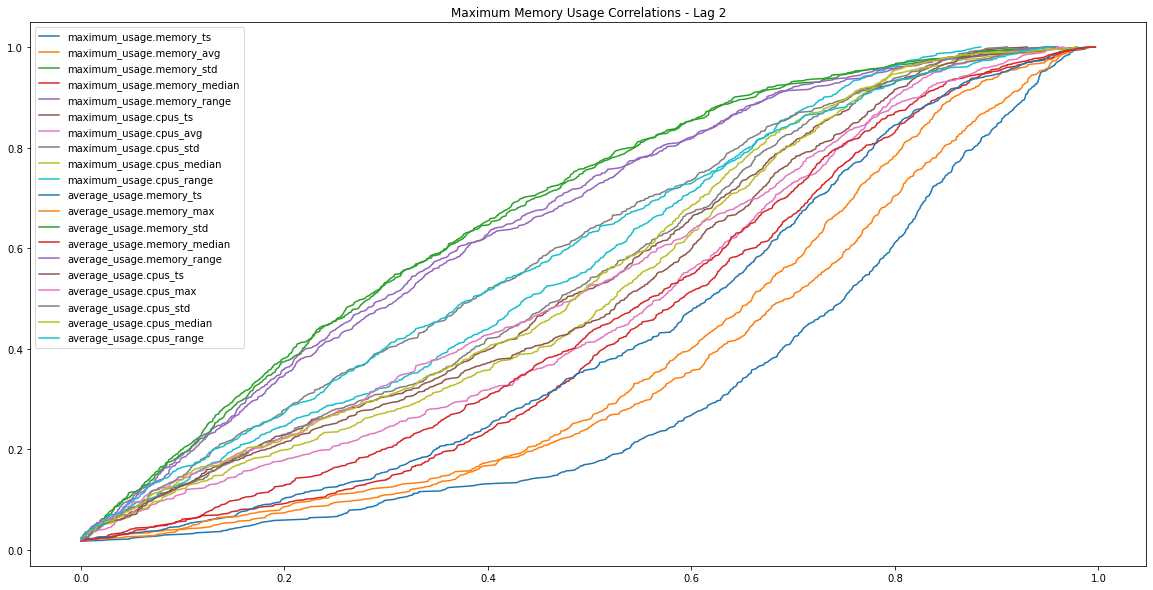

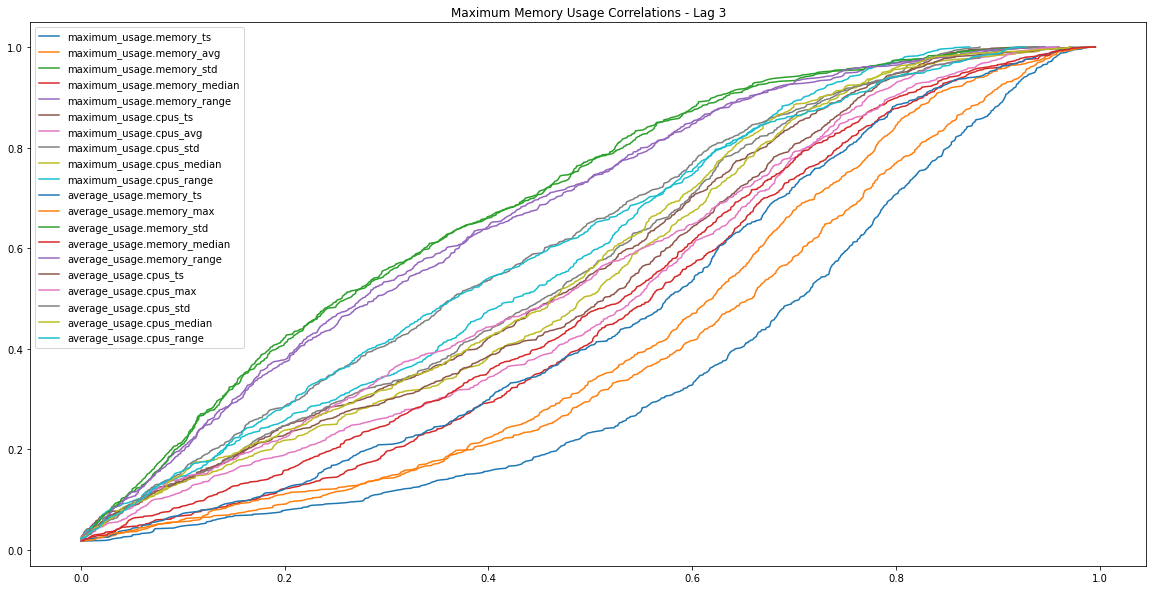

maximum_usage.memory_ts


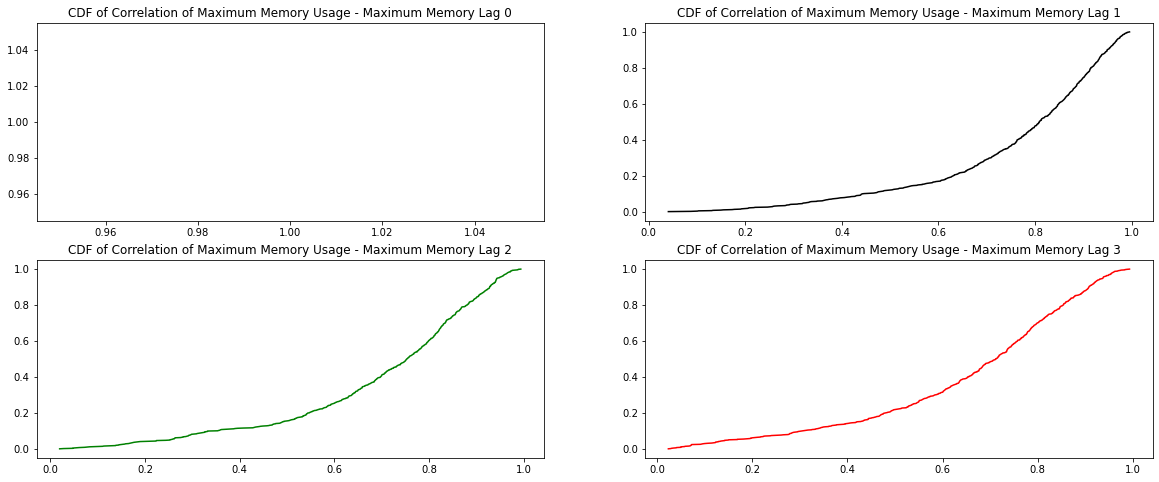

------------------------------------------------------------------------
maximum_usage.memory_avg


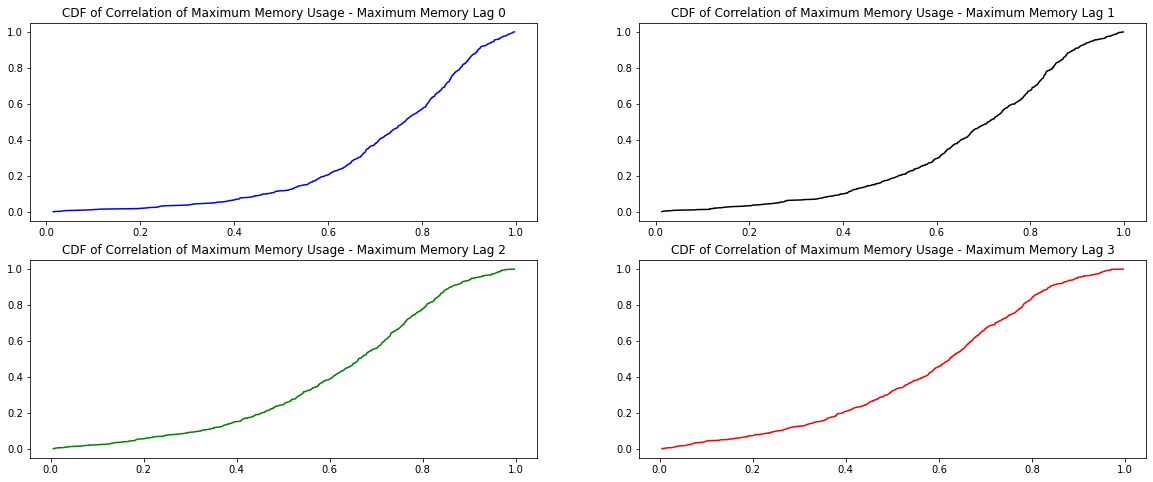

------------------------------------------------------------------------
maximum_usage.memory_std


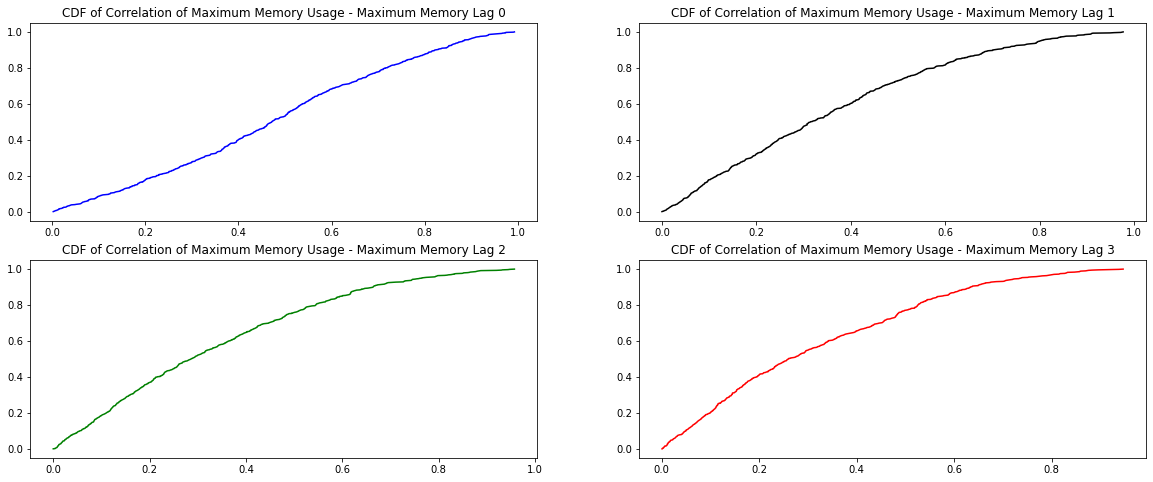

------------------------------------------------------------------------
maximum_usage.memory_median


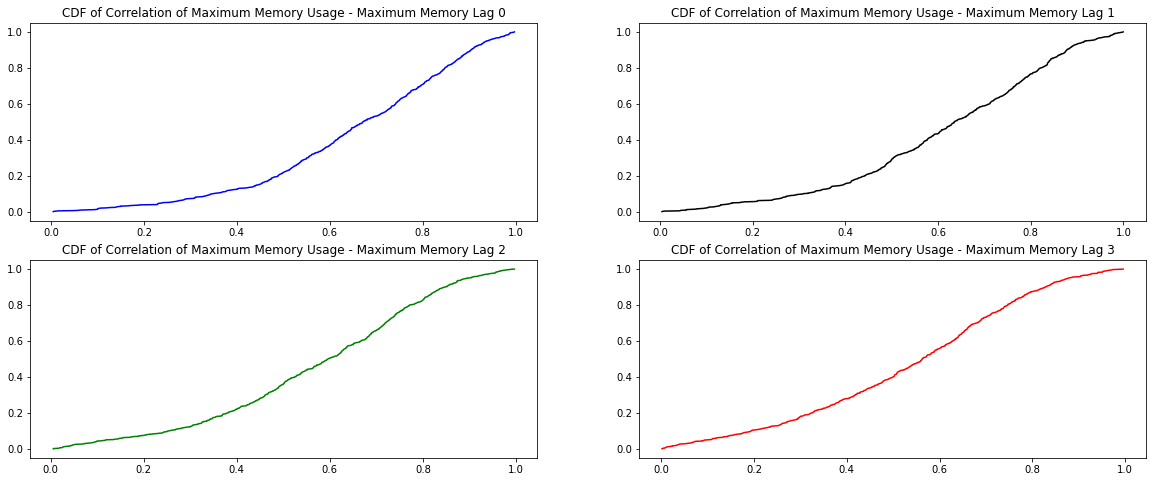

------------------------------------------------------------------------
maximum_usage.memory_range


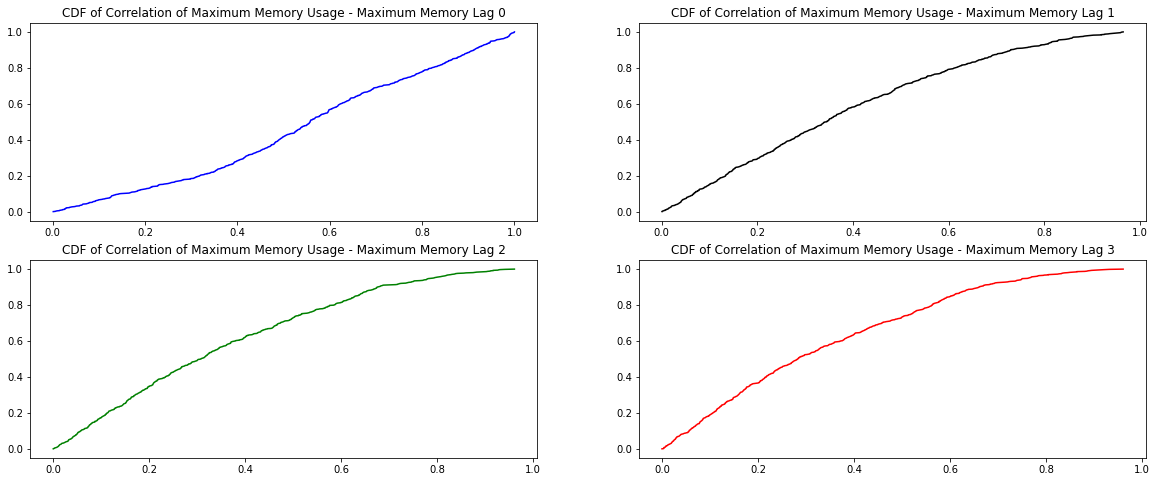

------------------------------------------------------------------------
average_usage.memory_ts


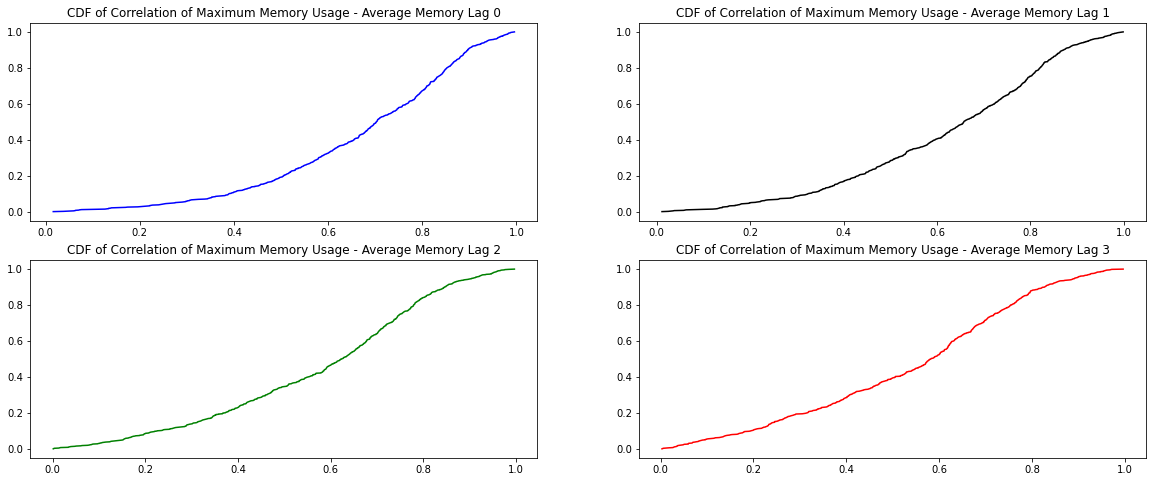

------------------------------------------------------------------------
average_usage.memory_max


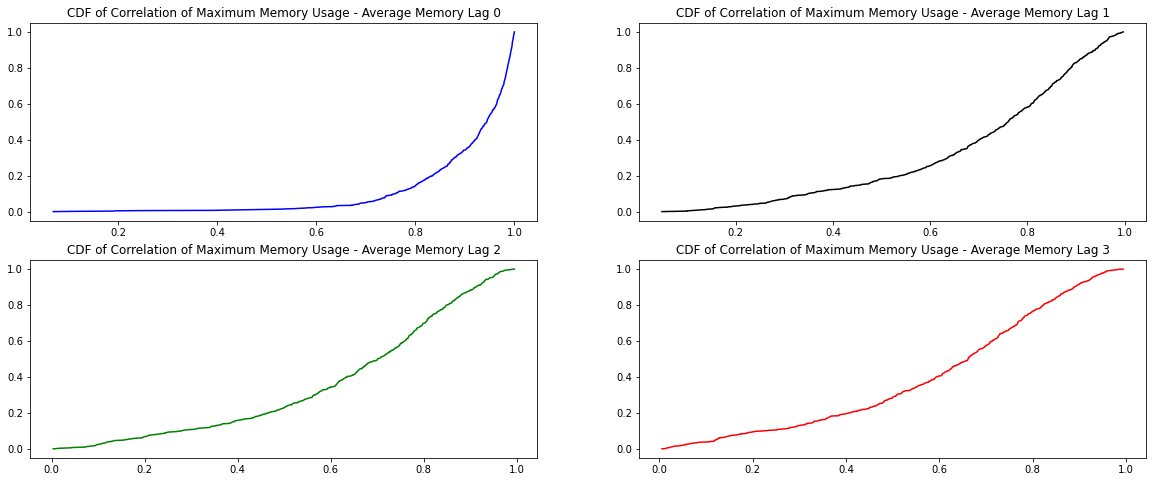

------------------------------------------------------------------------
average_usage.memory_std


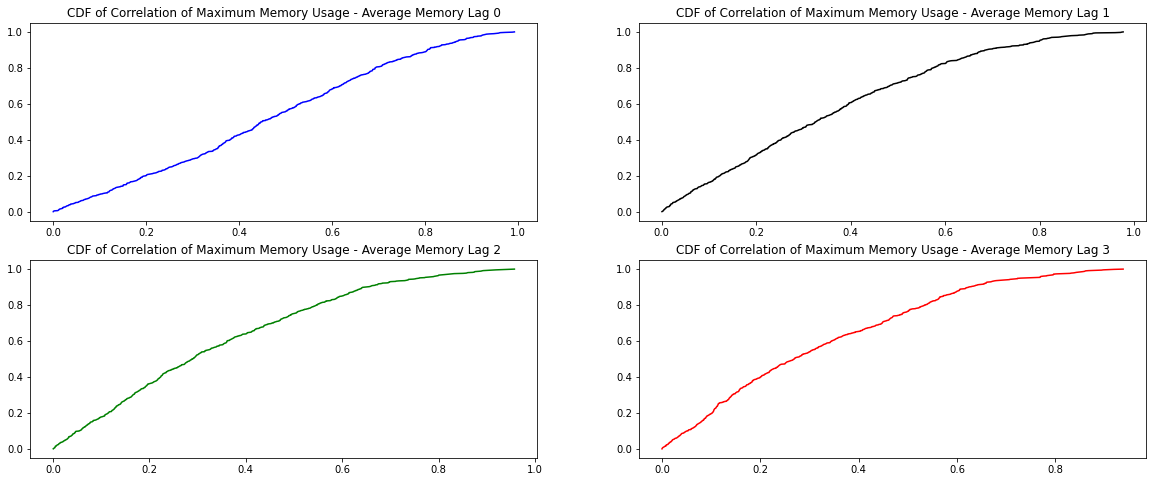

------------------------------------------------------------------------
average_usage.memory_median


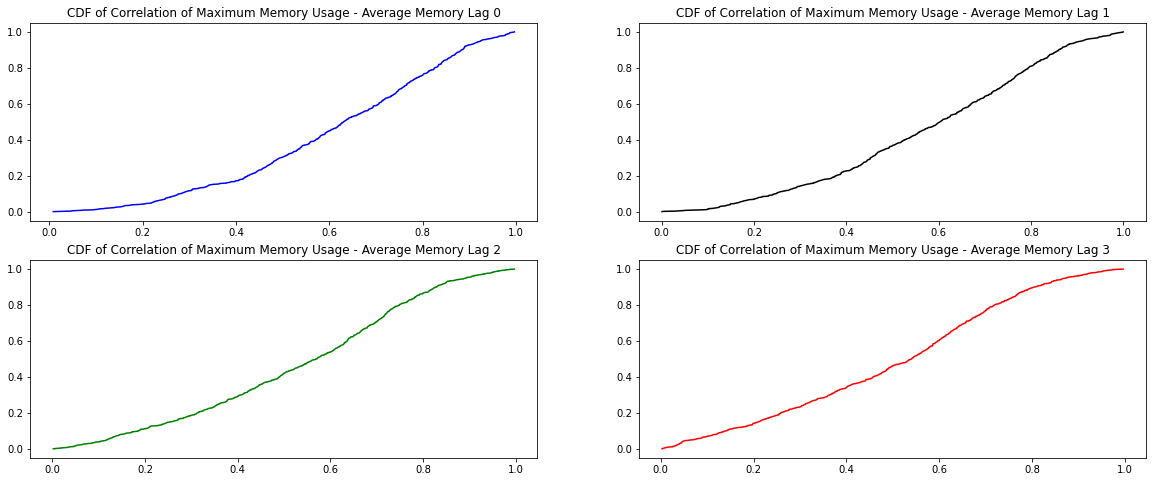

------------------------------------------------------------------------
average_usage.memory_range


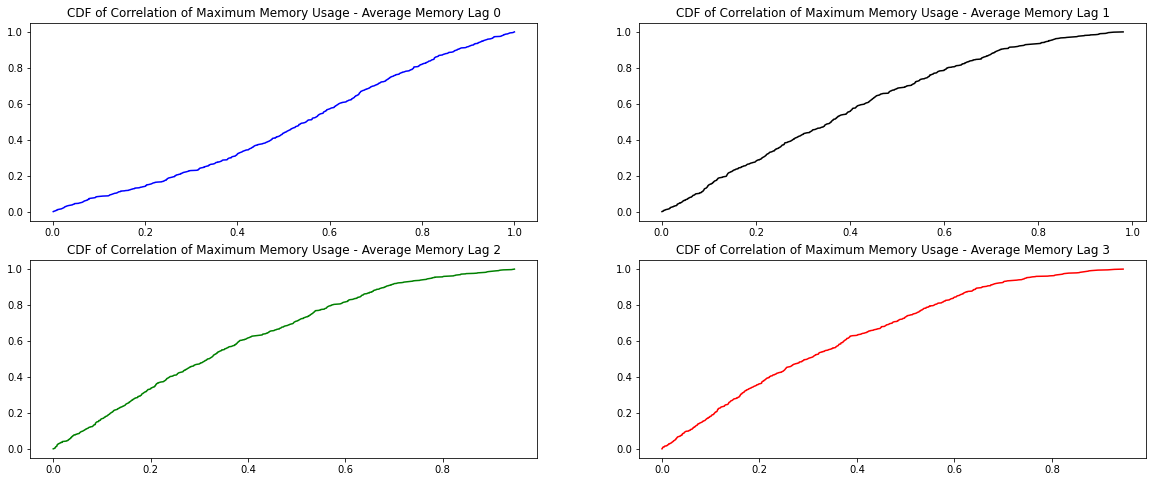

------------------------------------------------------------------------
maximum_usage.cpus_ts


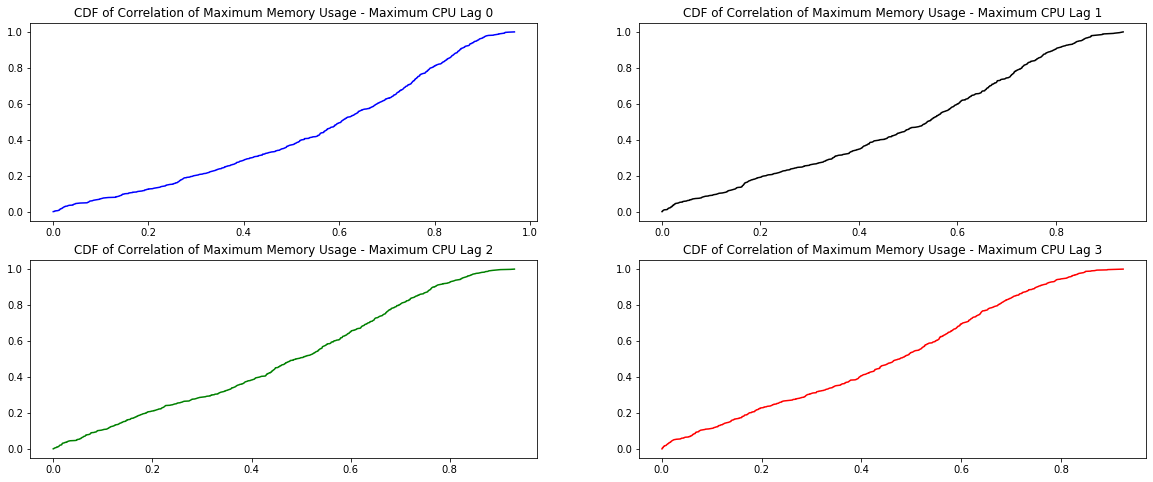

------------------------------------------------------------------------
maximum_usage.cpus_avg


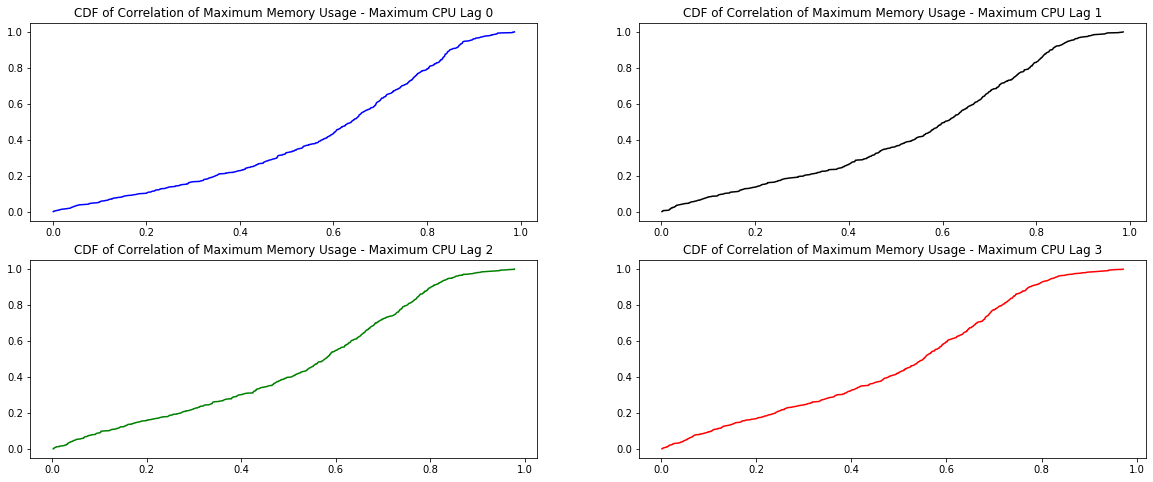

------------------------------------------------------------------------
maximum_usage.cpus_std


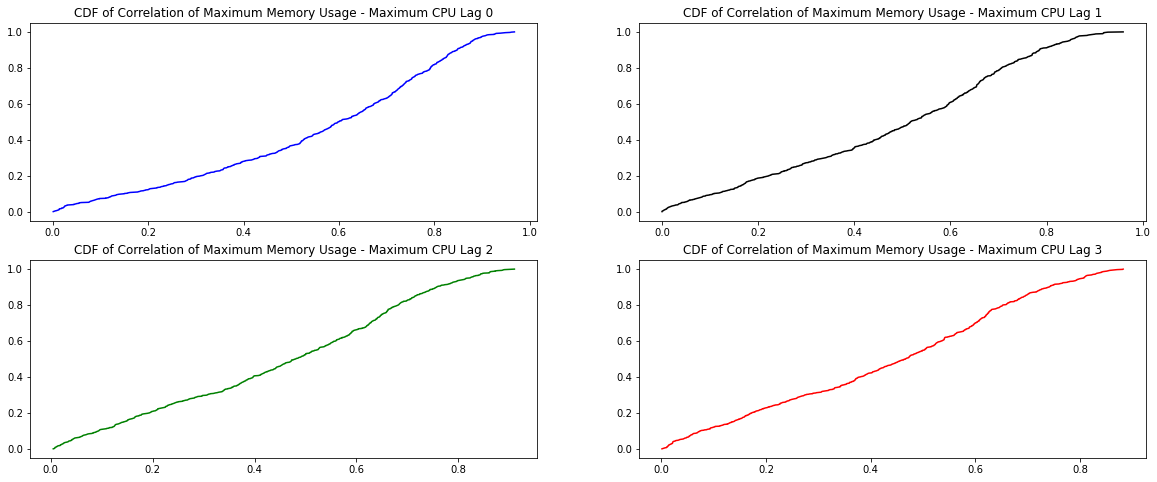

------------------------------------------------------------------------
maximum_usage.cpus_median


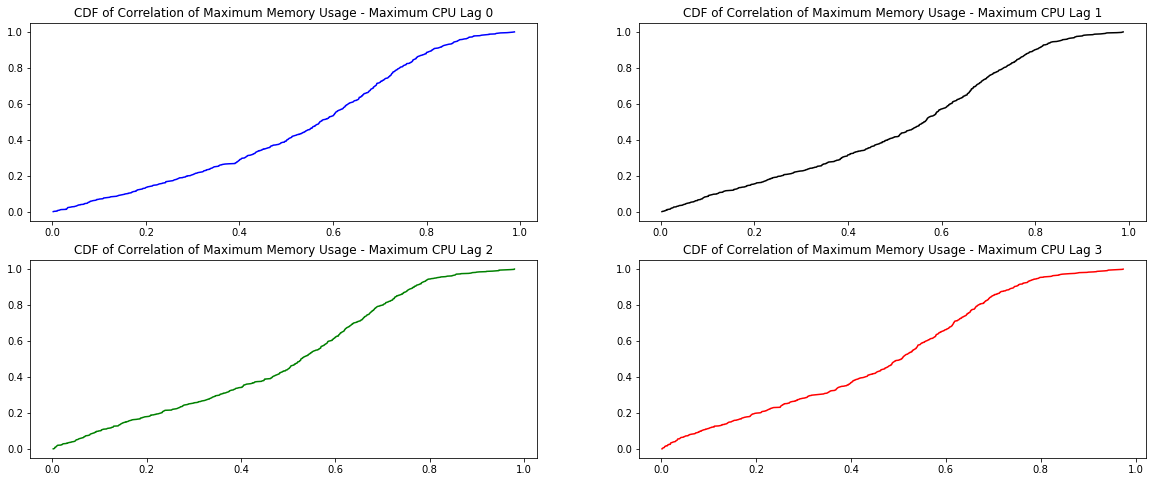

------------------------------------------------------------------------
maximum_usage.cpus_range


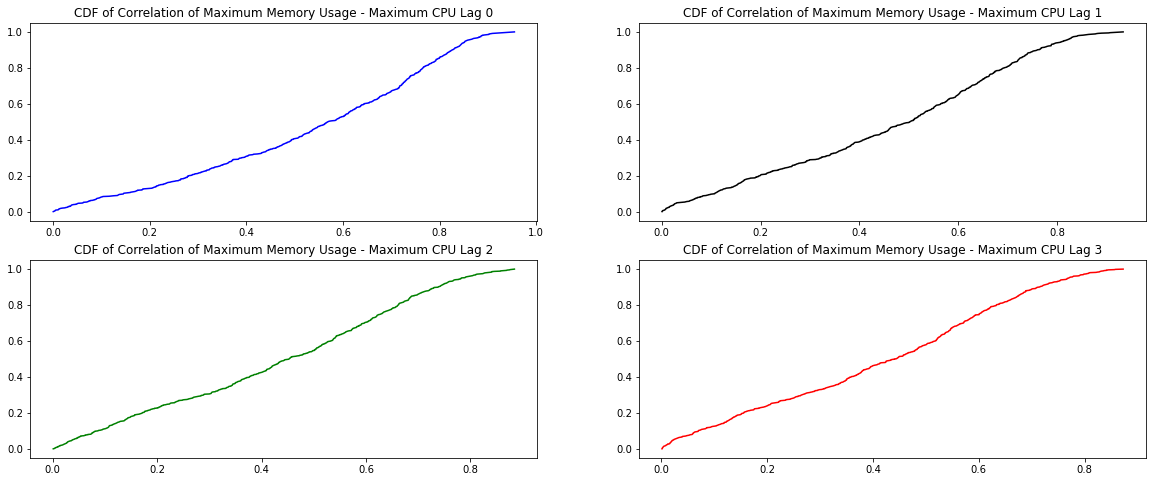

------------------------------------------------------------------------
average_usage.cpus_ts


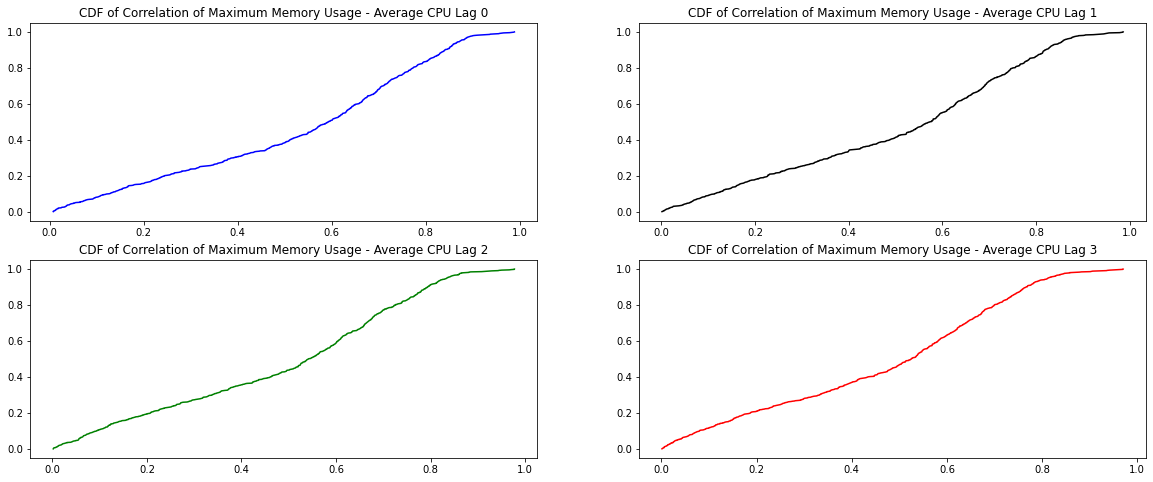

------------------------------------------------------------------------
average_usage.cpus_max


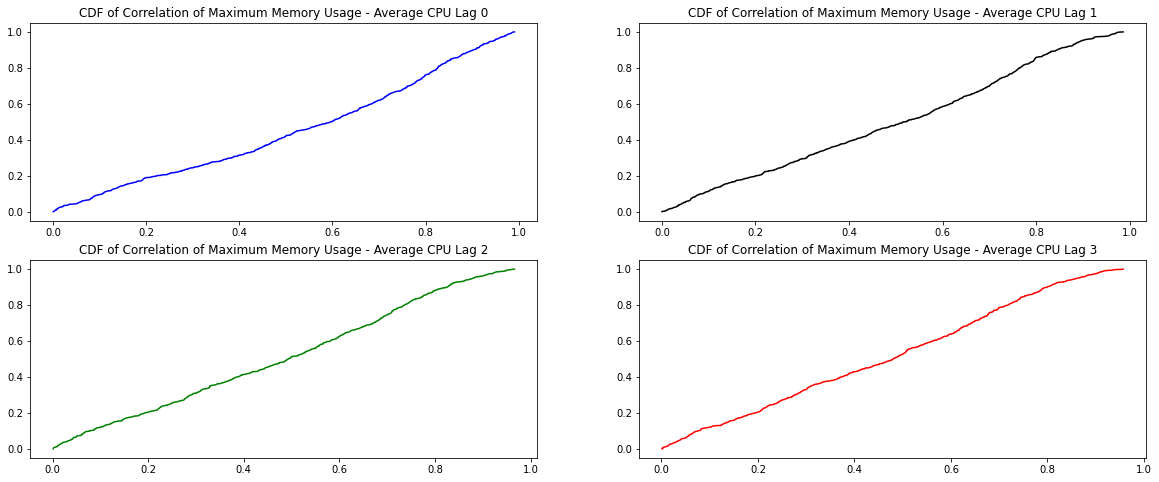

------------------------------------------------------------------------
average_usage.cpus_std


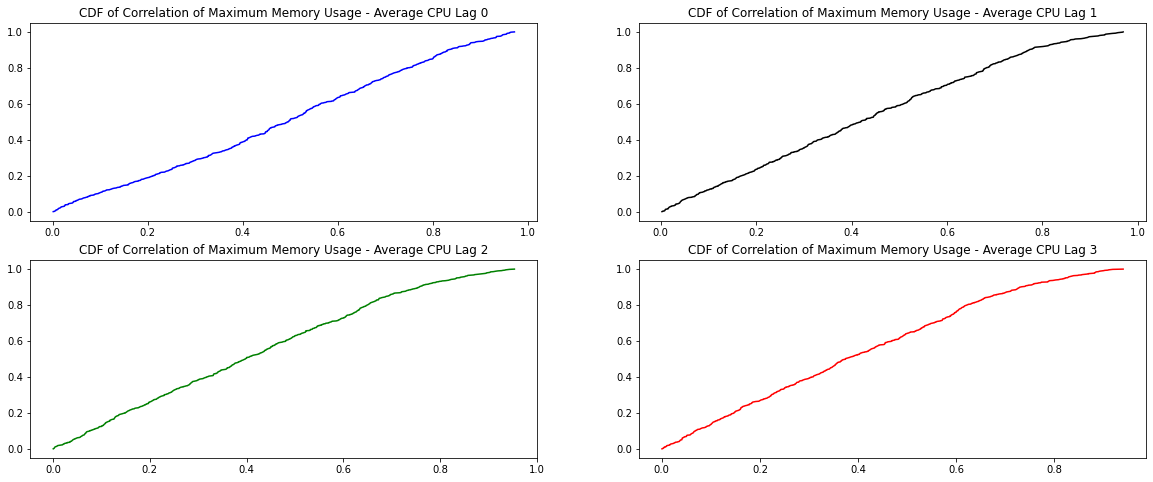

------------------------------------------------------------------------
average_usage.cpus_median


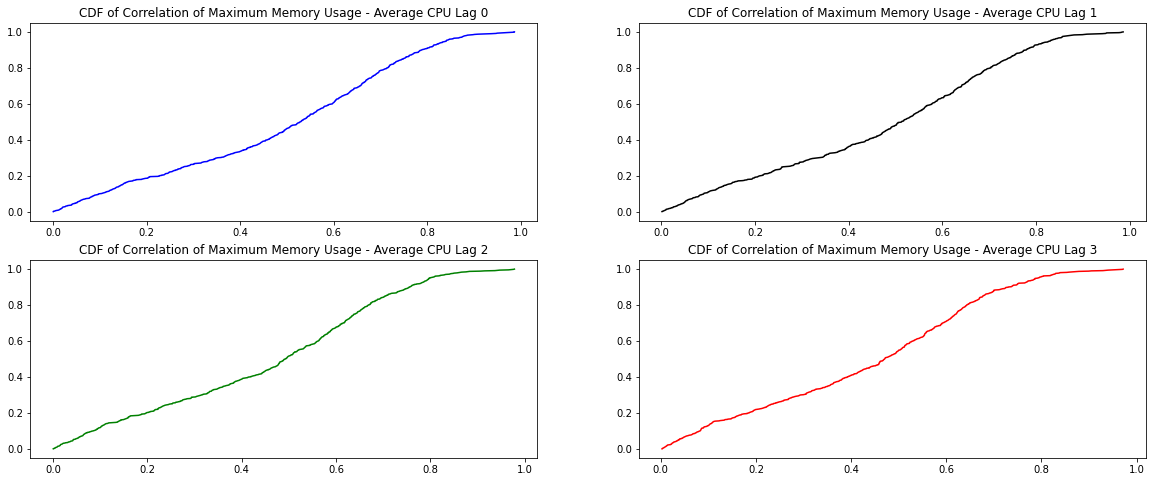

------------------------------------------------------------------------
average_usage.cpus_range


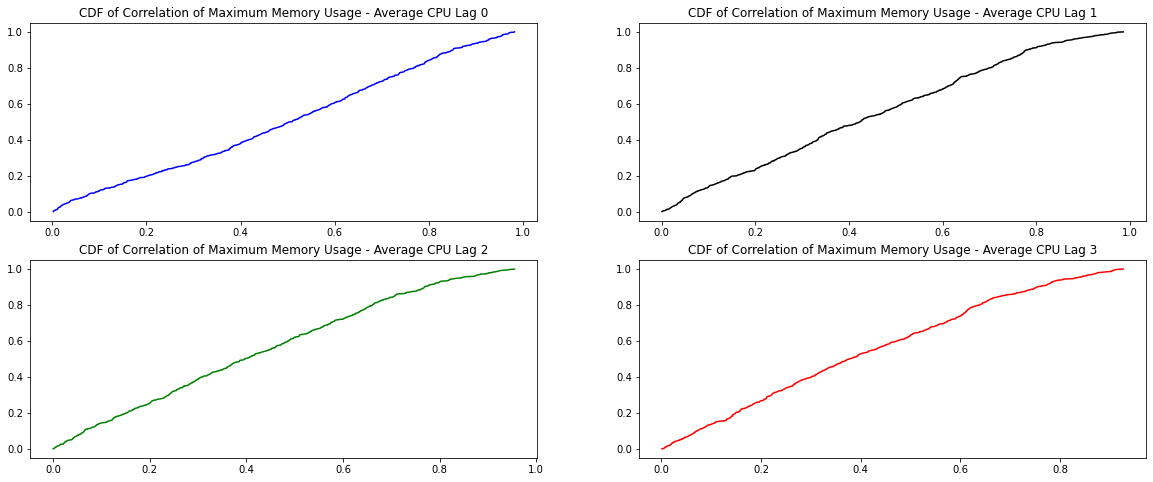

------------------------------------------------------------------------

average_usage.memory


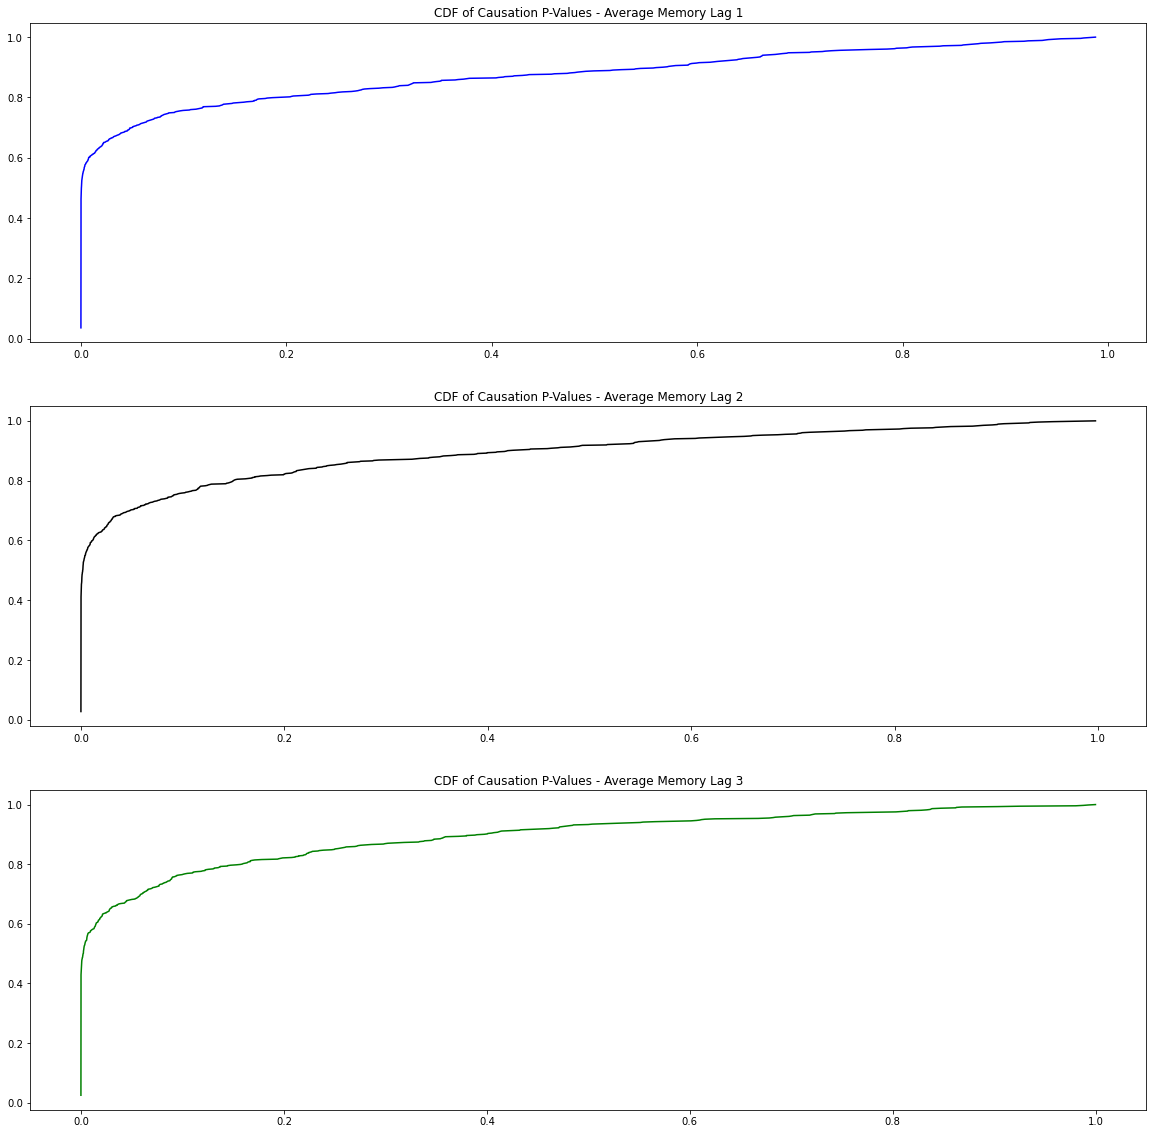

maximum_usage.cpus


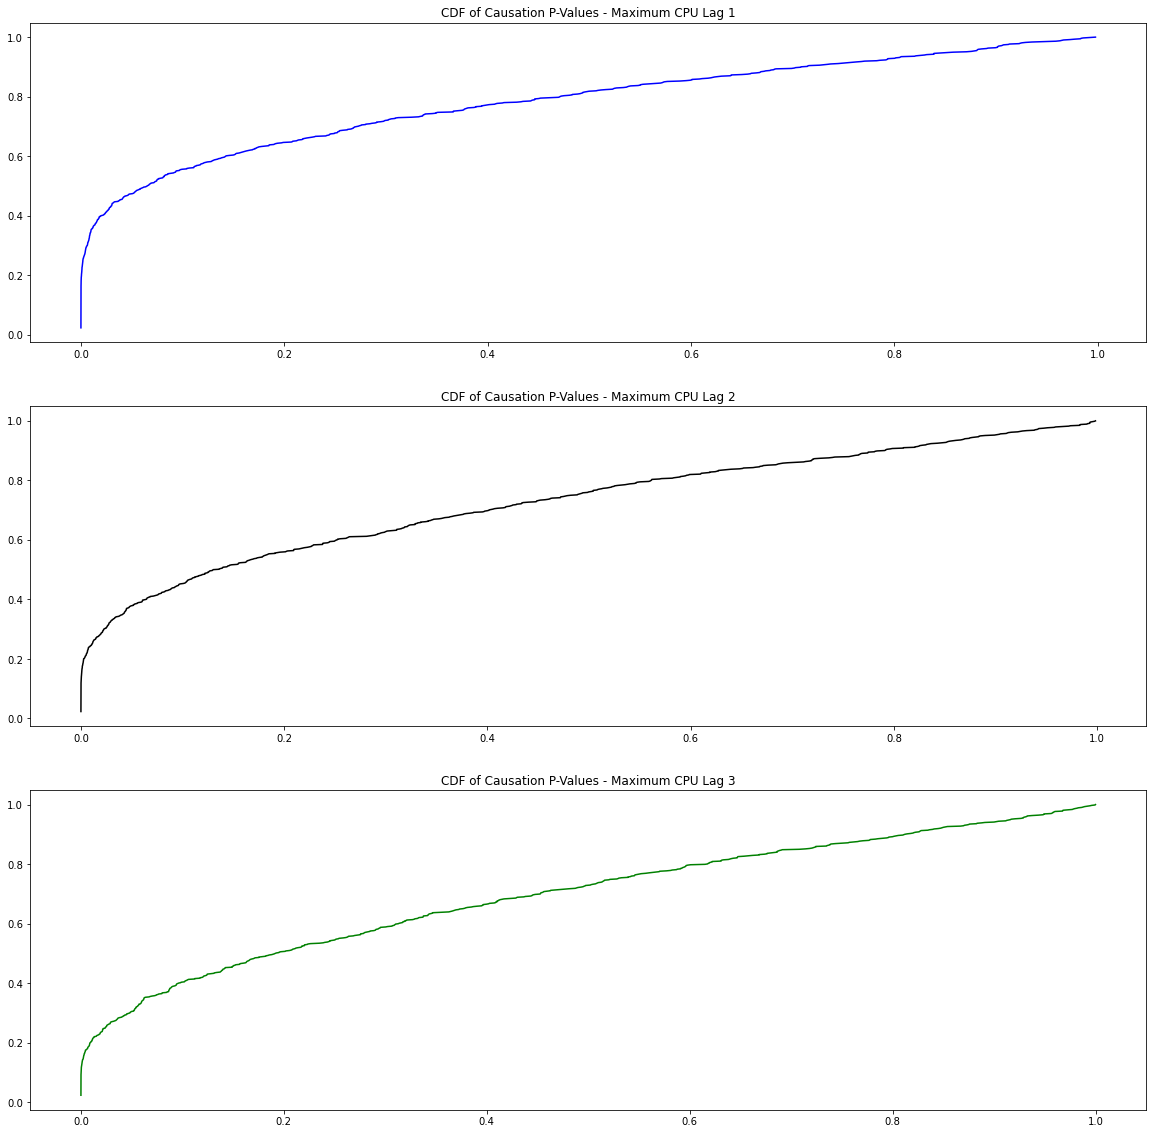

average_usage.cpus


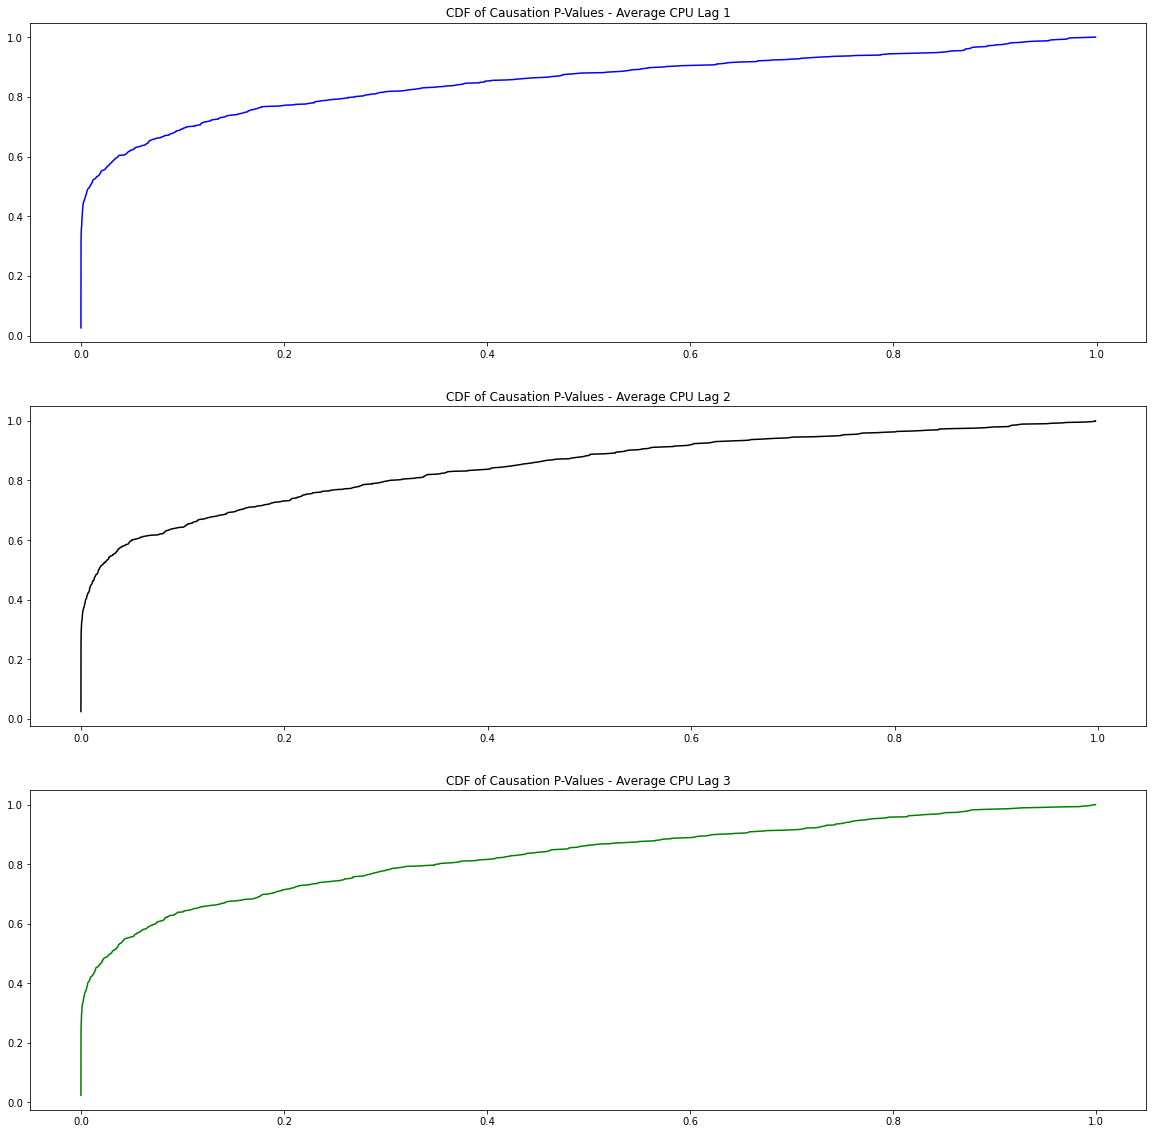

In [17]:
max_mem_24_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_mem_24"
stats_dfs['max_mem_agg_24'] = summarize_statistical_results(max_mem_24_dir, specs.MAX_MEM_COL, "ssr_chi2test", "Maximum Memory")

### Maximum CPU Usage - 24 Period Aggregation

Total Trace Count: 732

Stationarity Results
Number of Stationary Traces: 40.44%
Number of Stationary Traces after 1 Level Differencing: 57.24%
Number of Stationary Traces after 2 Level Differencing: 1.78%
Other: 0.55%

Correlation Results
Number of traces with correlation of maximum_usage.cpus and maximum_usage.memory >= 0.7 or <= -0.7: 266
Number of traces with correlation of maximum_usage.cpus and average_usage.memory >= 0.7 or <= -0.7: 112
Number of traces with correlation of maximum_usage.cpus and average_usage.cpus >= 0.7 or <= -0.7: 357



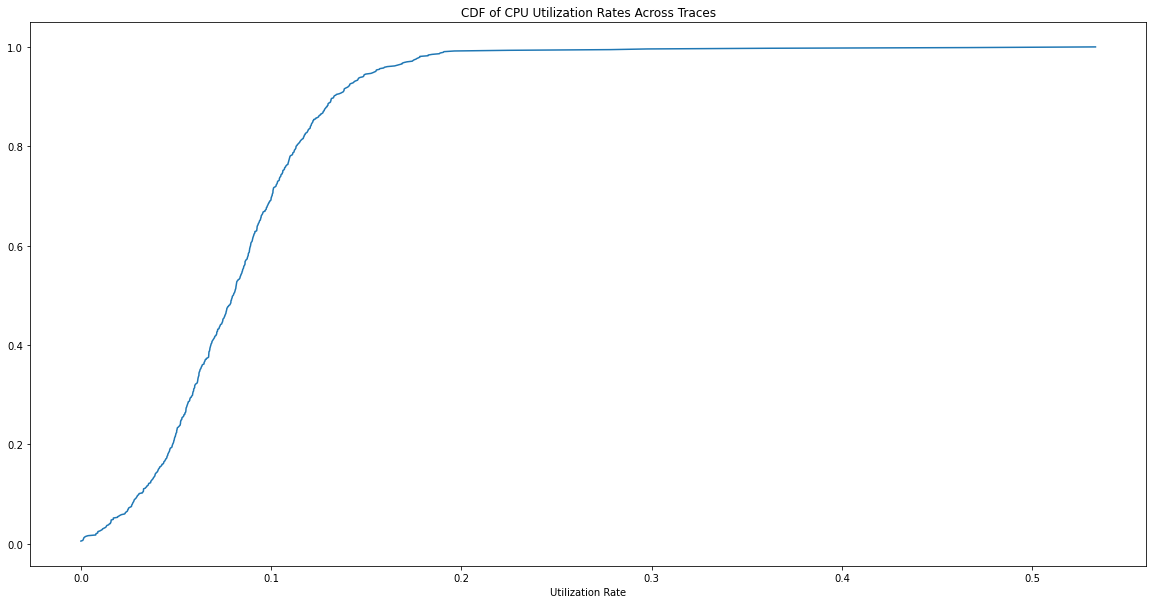

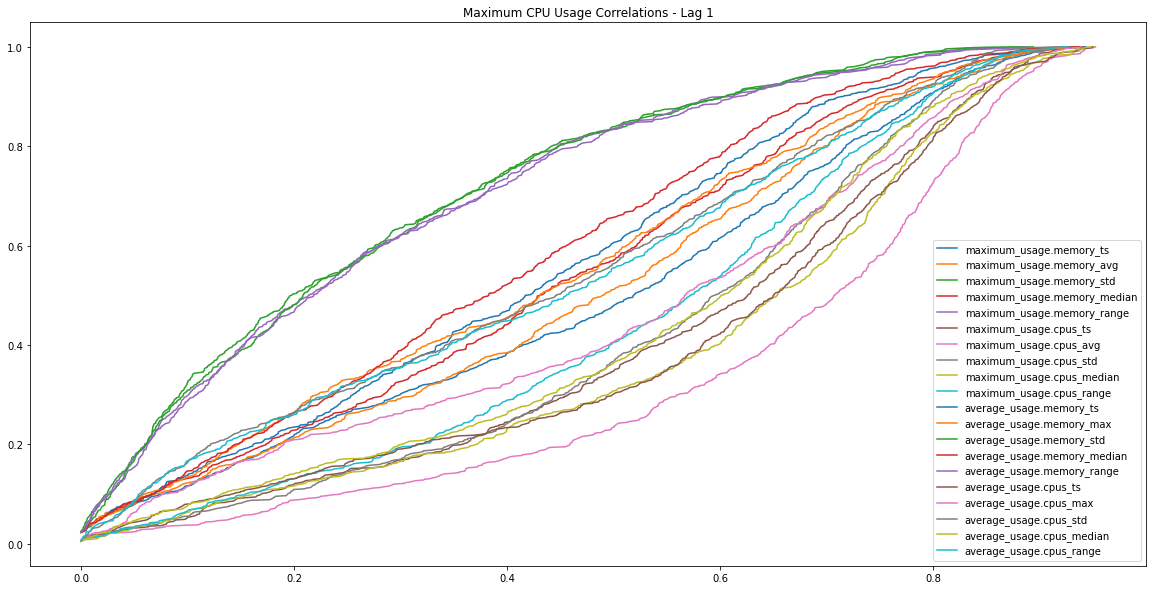

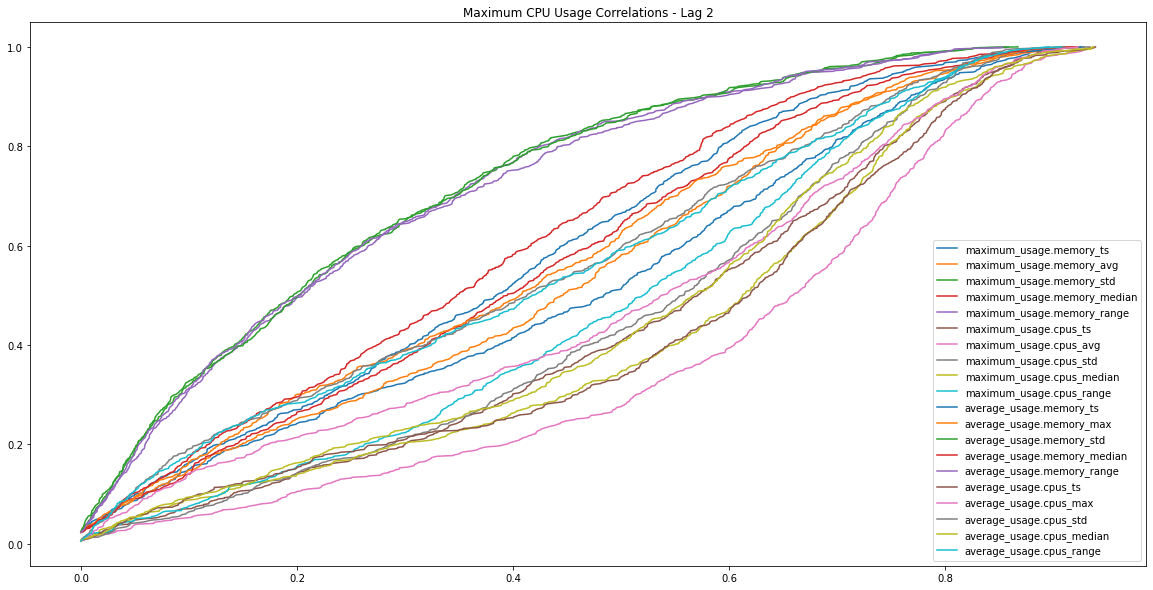

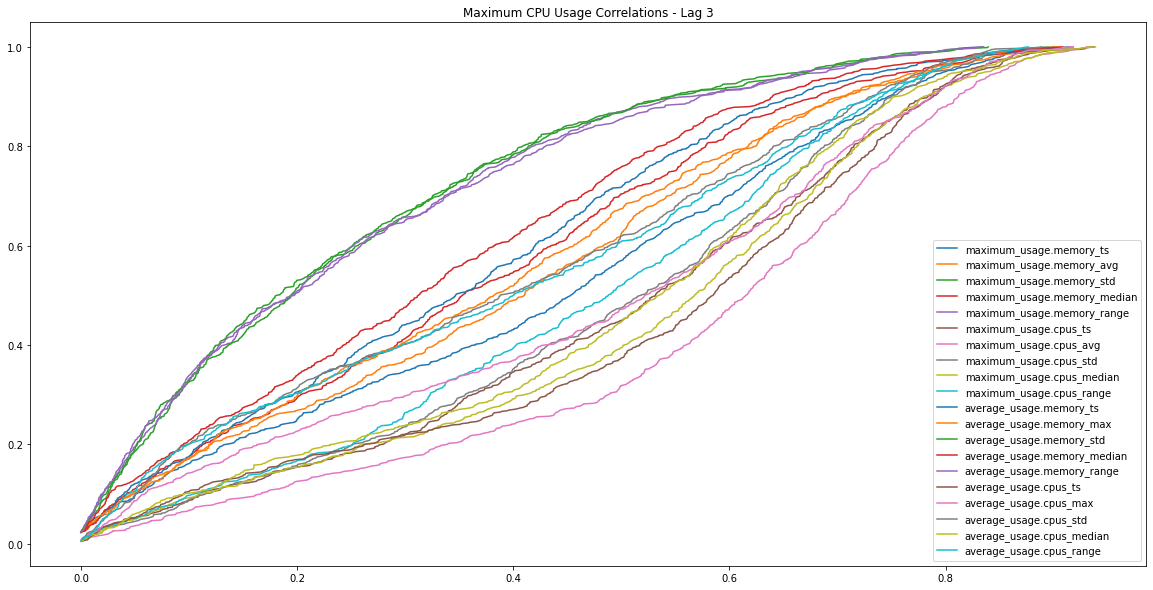

maximum_usage.memory_ts


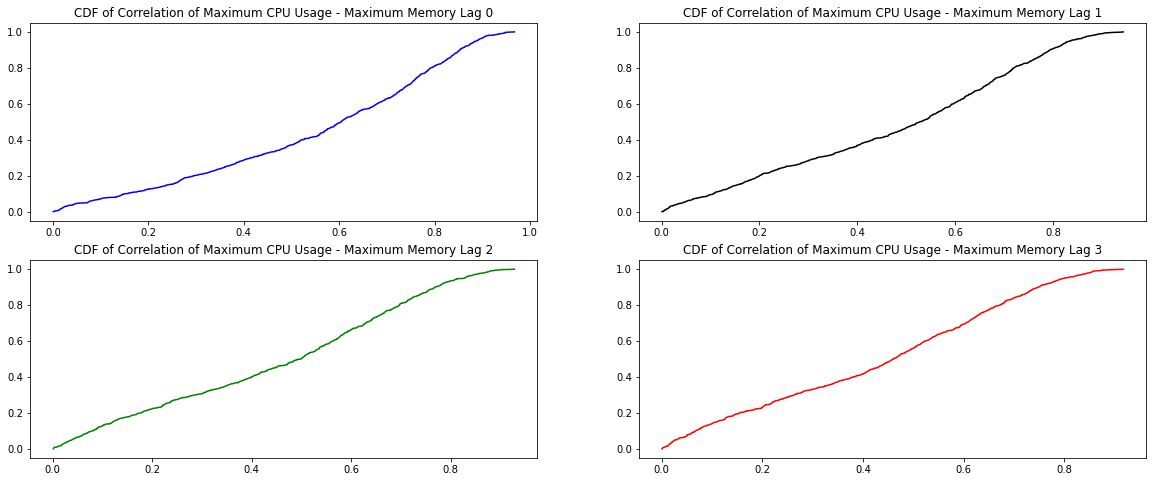

------------------------------------------------------------------------
maximum_usage.memory_avg


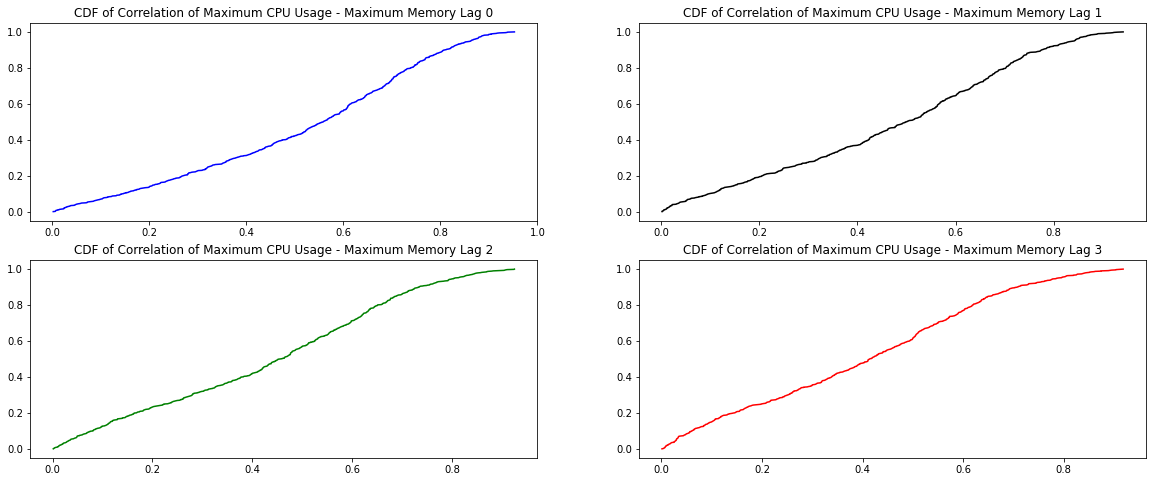

------------------------------------------------------------------------
maximum_usage.memory_std


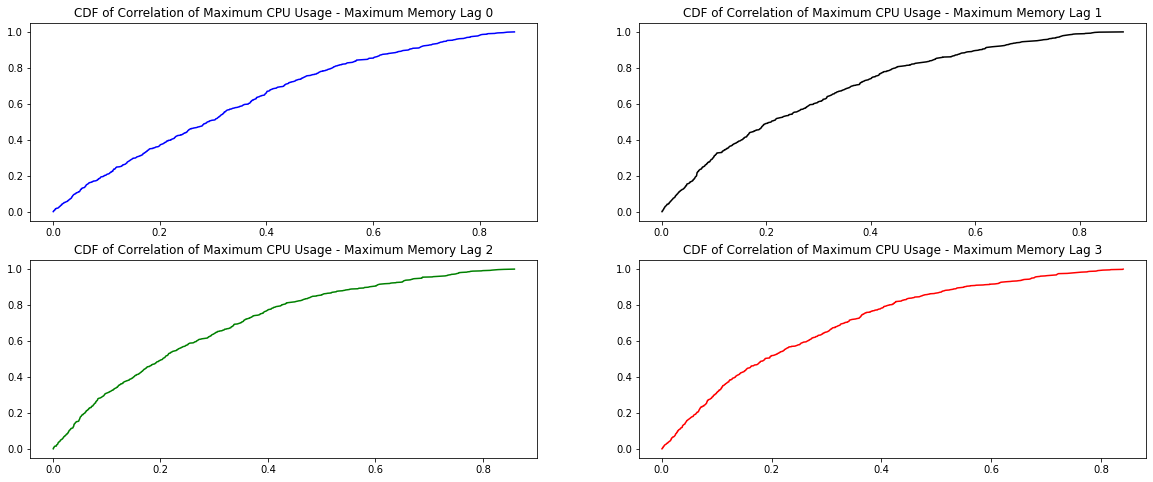

------------------------------------------------------------------------
maximum_usage.memory_median


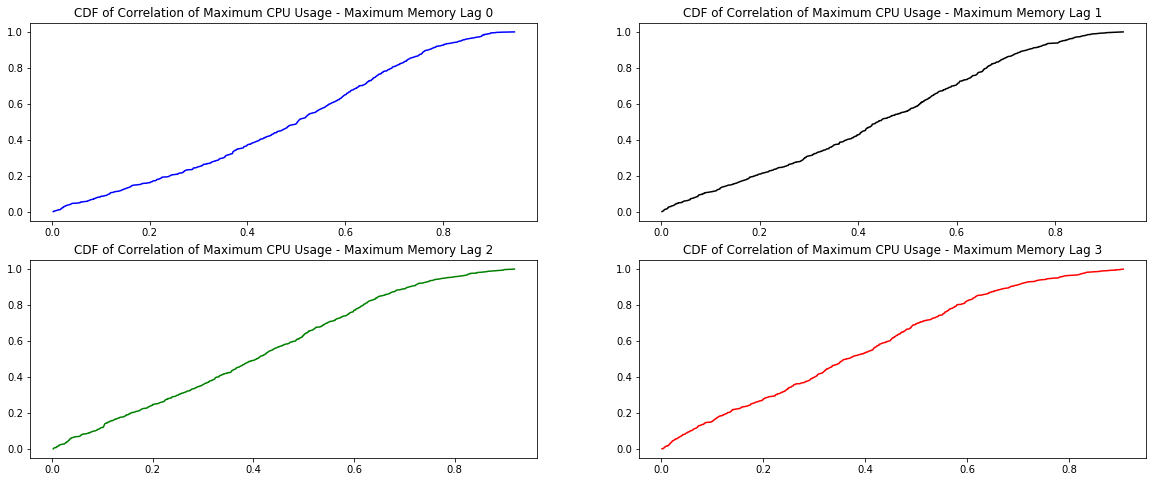

------------------------------------------------------------------------
maximum_usage.memory_range


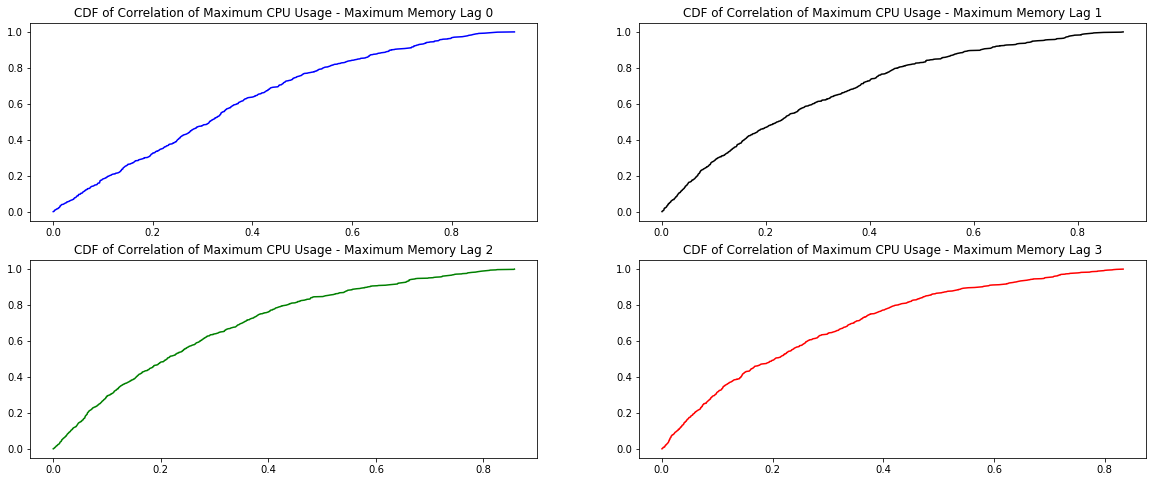

------------------------------------------------------------------------
average_usage.memory_ts


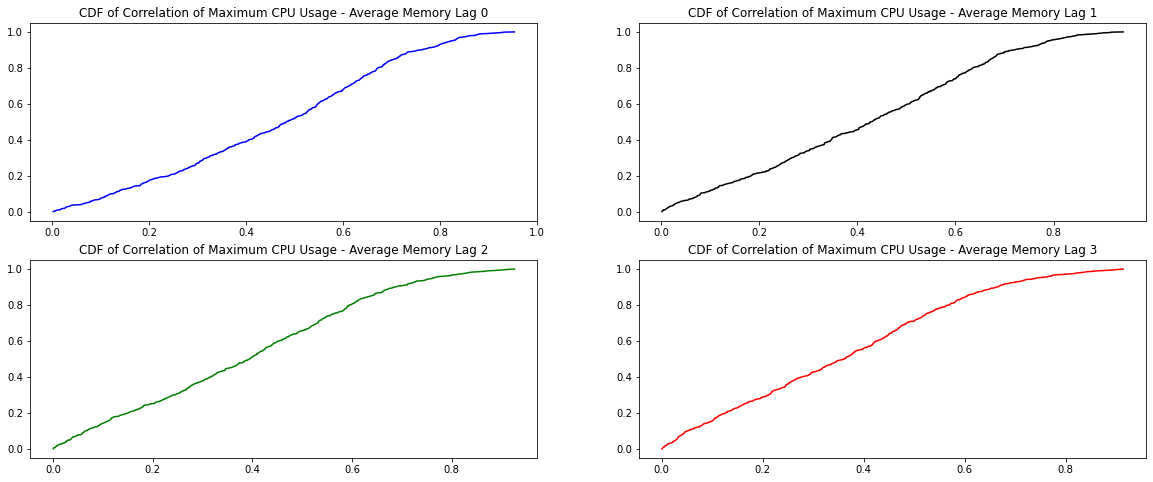

------------------------------------------------------------------------
average_usage.memory_max


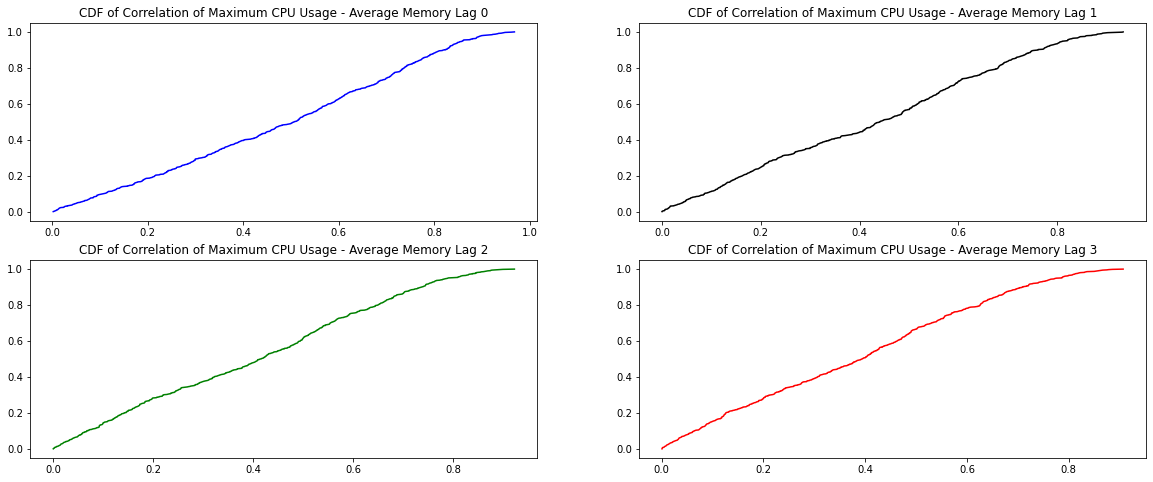

------------------------------------------------------------------------
average_usage.memory_std


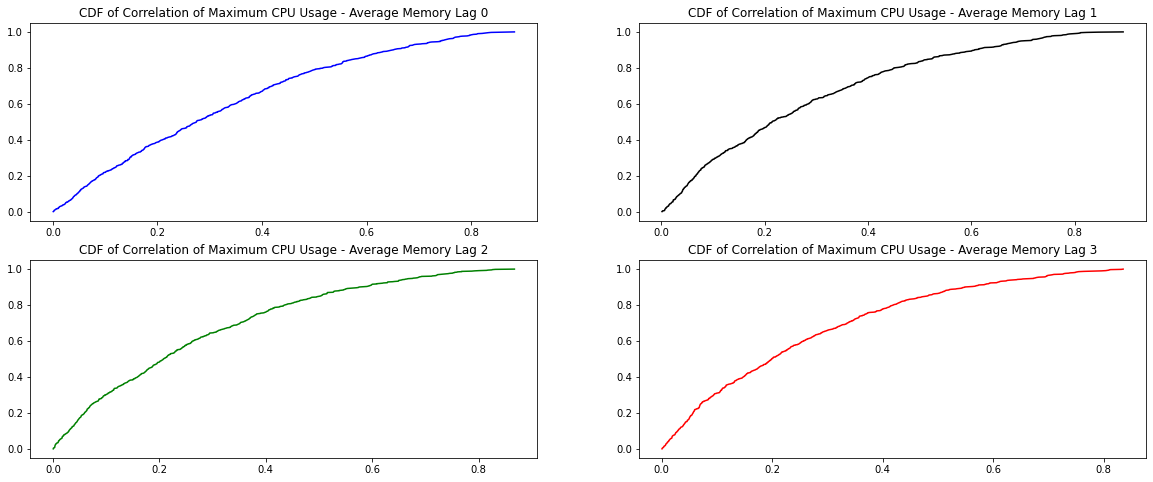

------------------------------------------------------------------------
average_usage.memory_median


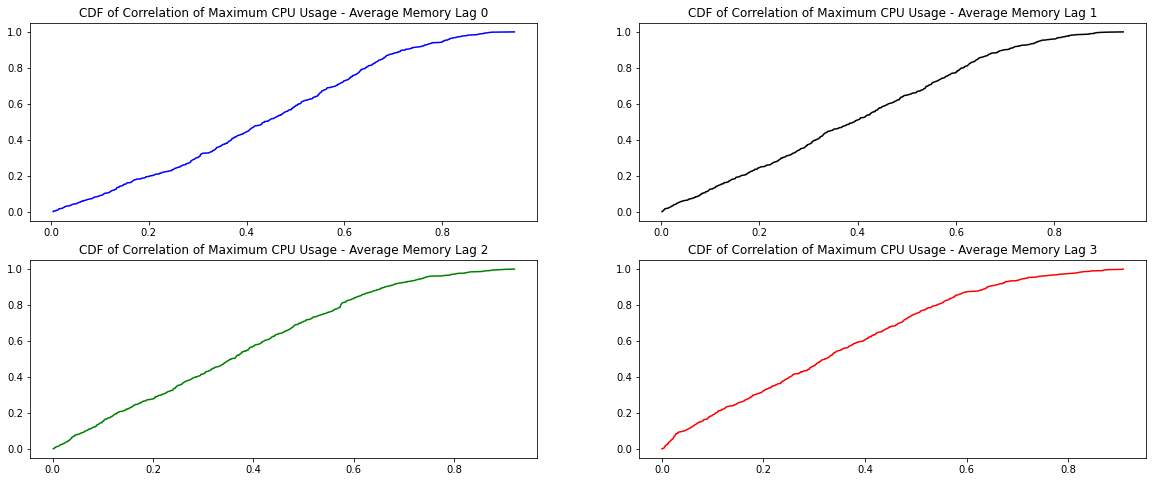

------------------------------------------------------------------------
average_usage.memory_range


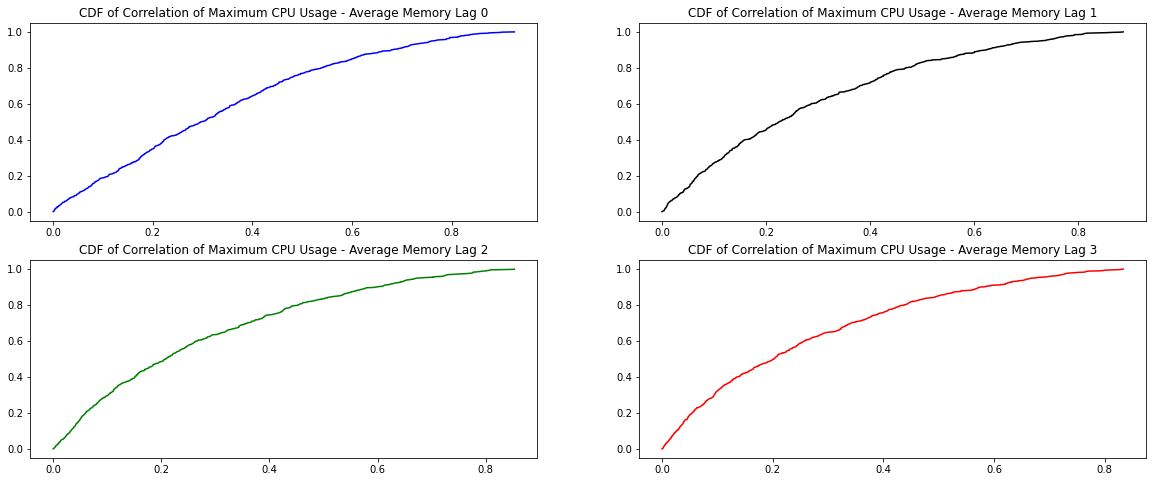

------------------------------------------------------------------------
maximum_usage.cpus_ts


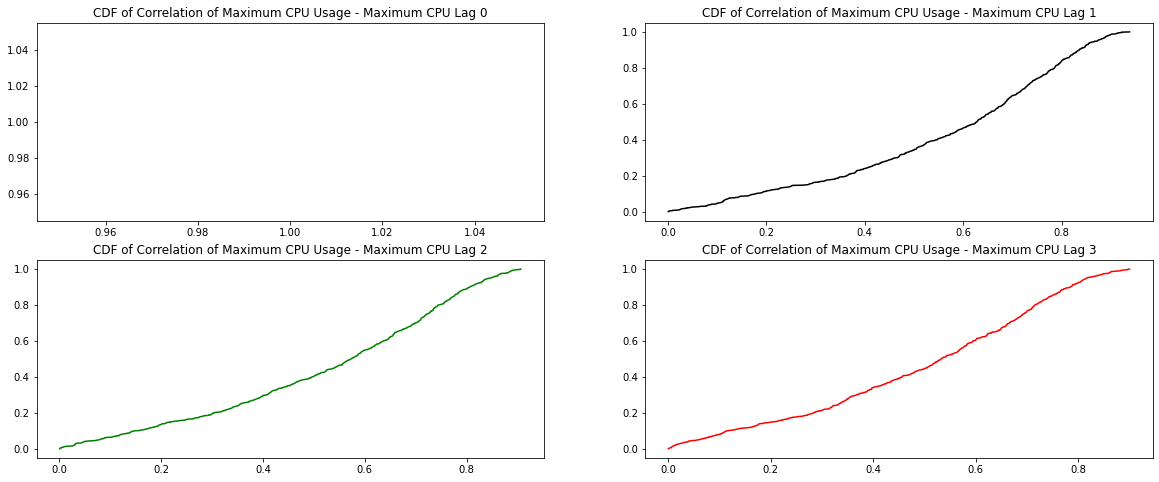

------------------------------------------------------------------------
maximum_usage.cpus_avg


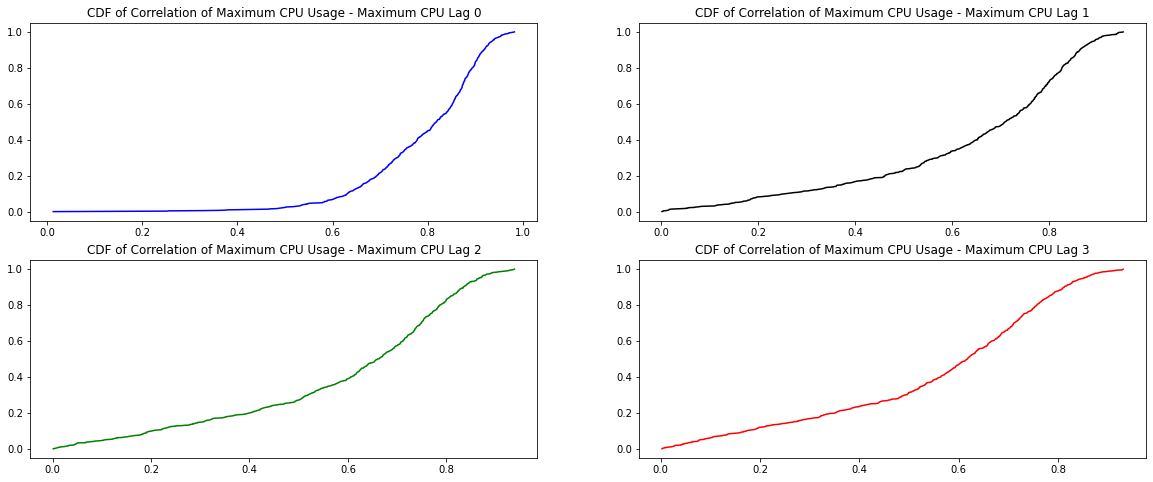

------------------------------------------------------------------------
maximum_usage.cpus_std


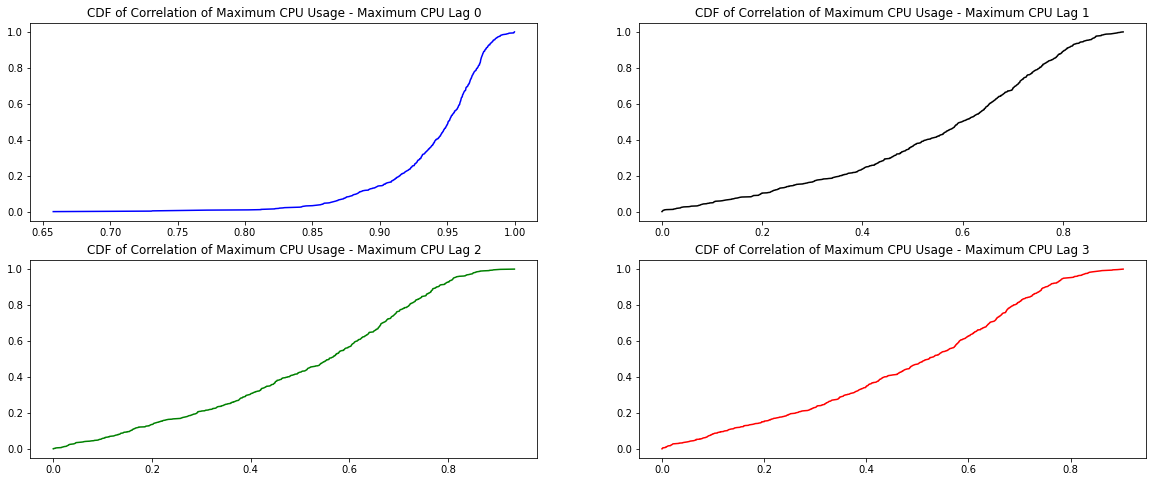

------------------------------------------------------------------------
maximum_usage.cpus_median


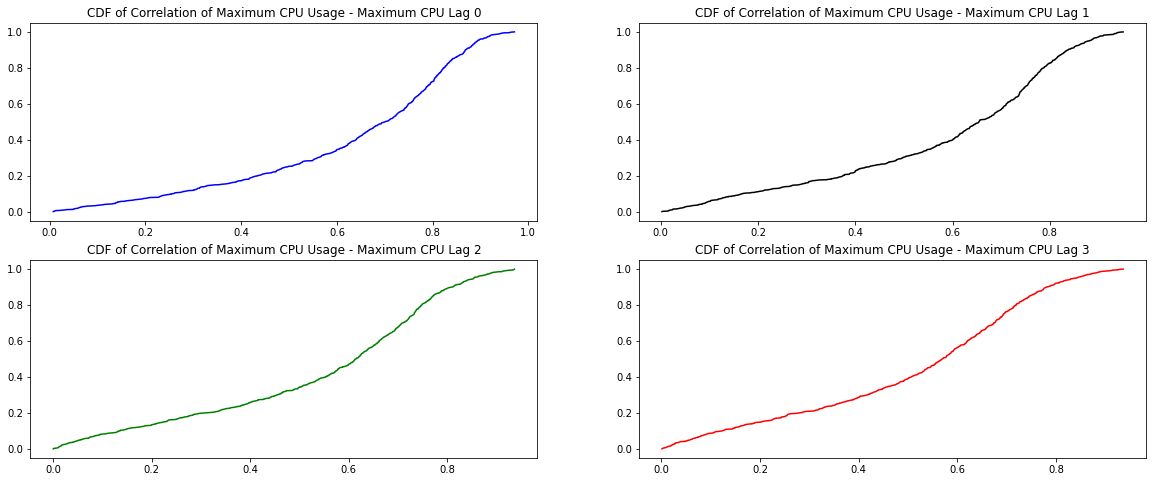

------------------------------------------------------------------------
maximum_usage.cpus_range


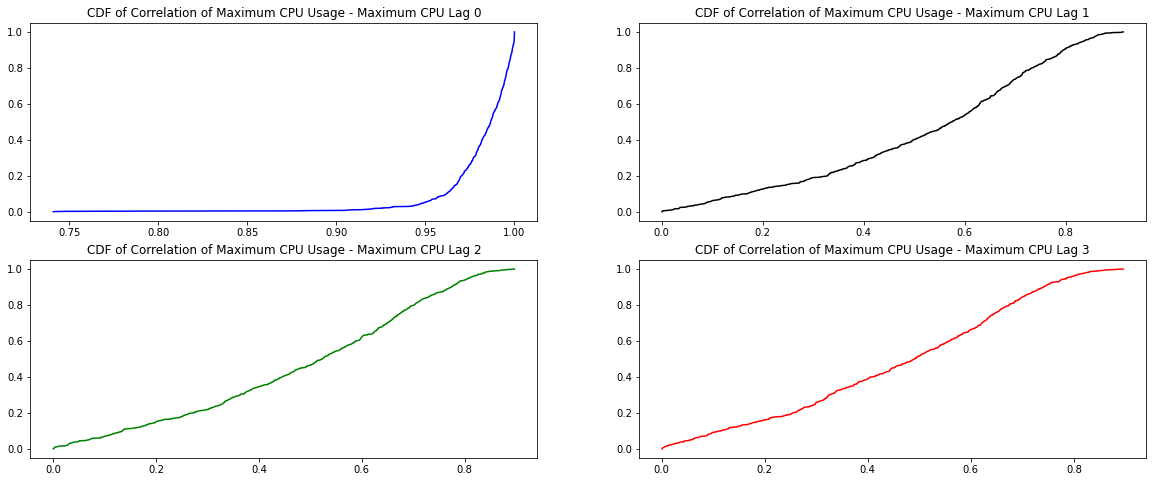

------------------------------------------------------------------------
average_usage.cpus_ts


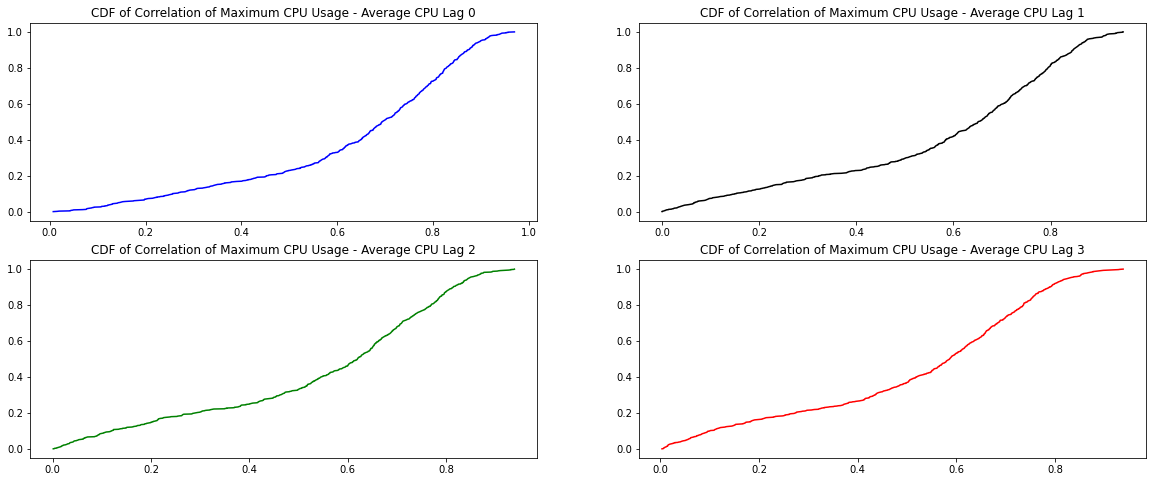

------------------------------------------------------------------------
average_usage.cpus_max


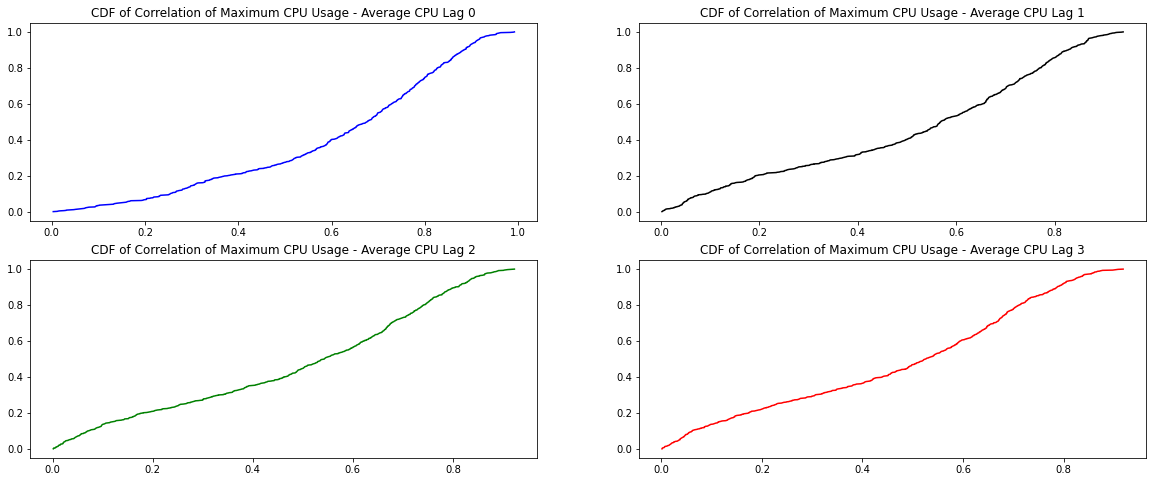

------------------------------------------------------------------------
average_usage.cpus_std


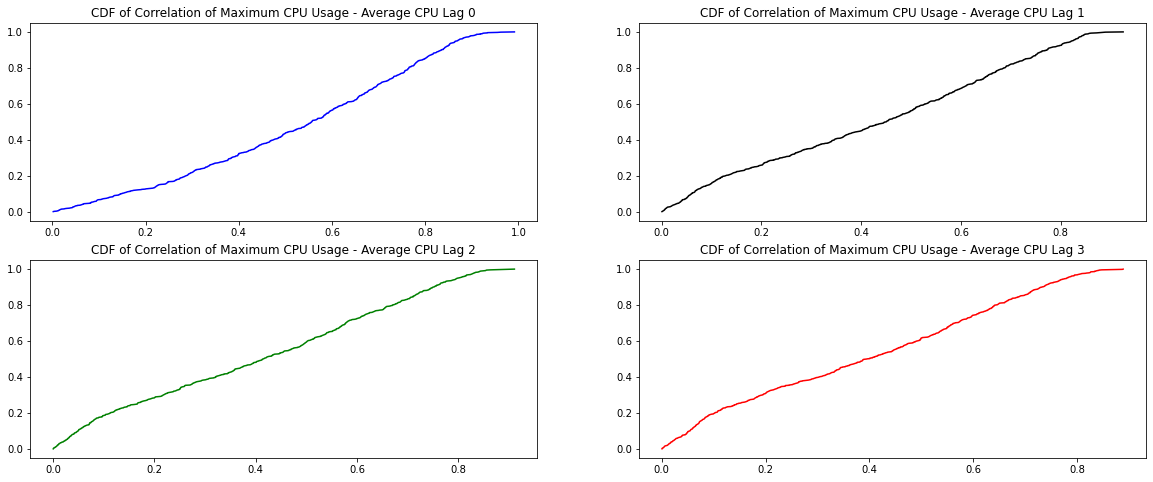

------------------------------------------------------------------------
average_usage.cpus_median


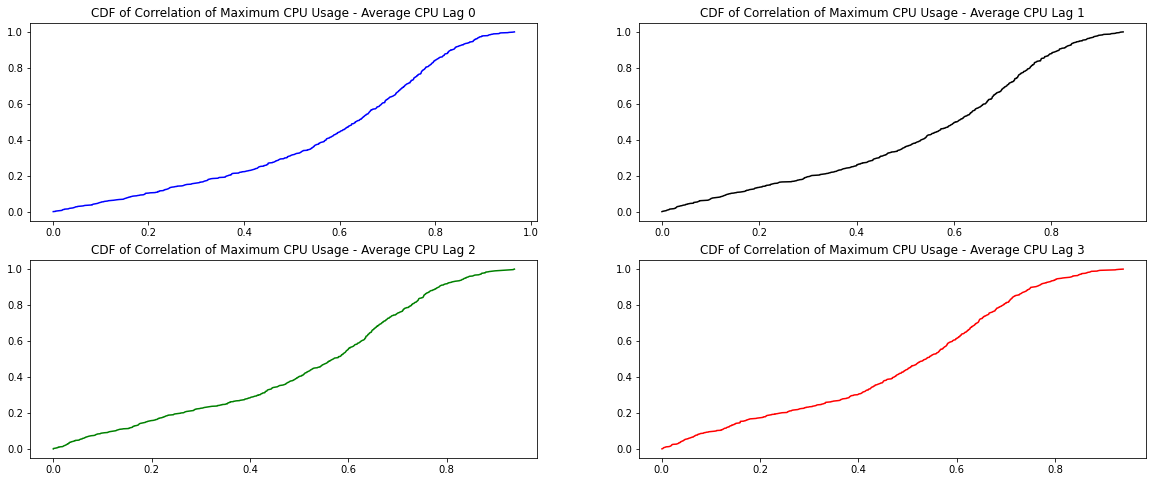

------------------------------------------------------------------------
average_usage.cpus_range


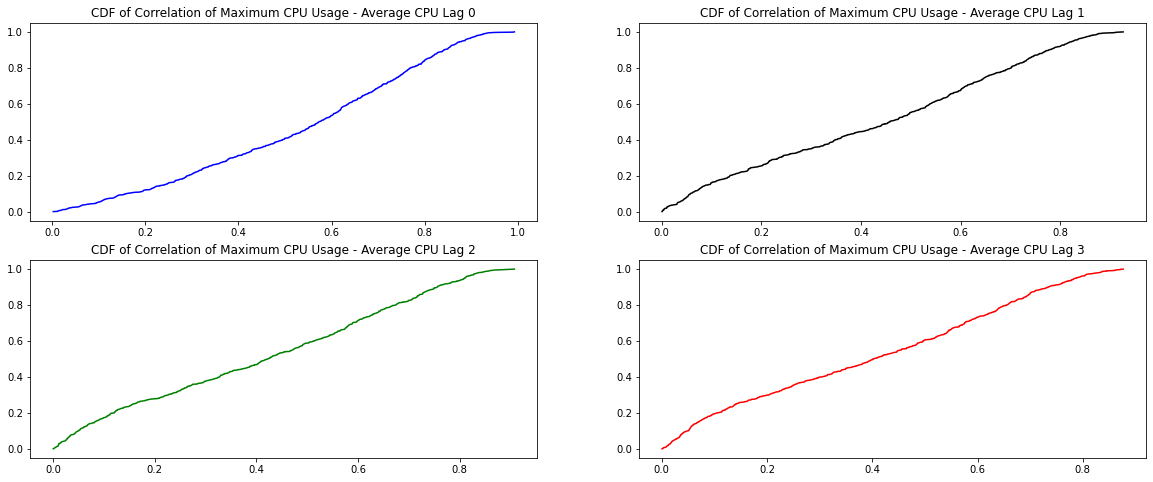

------------------------------------------------------------------------

maximum_usage.memory


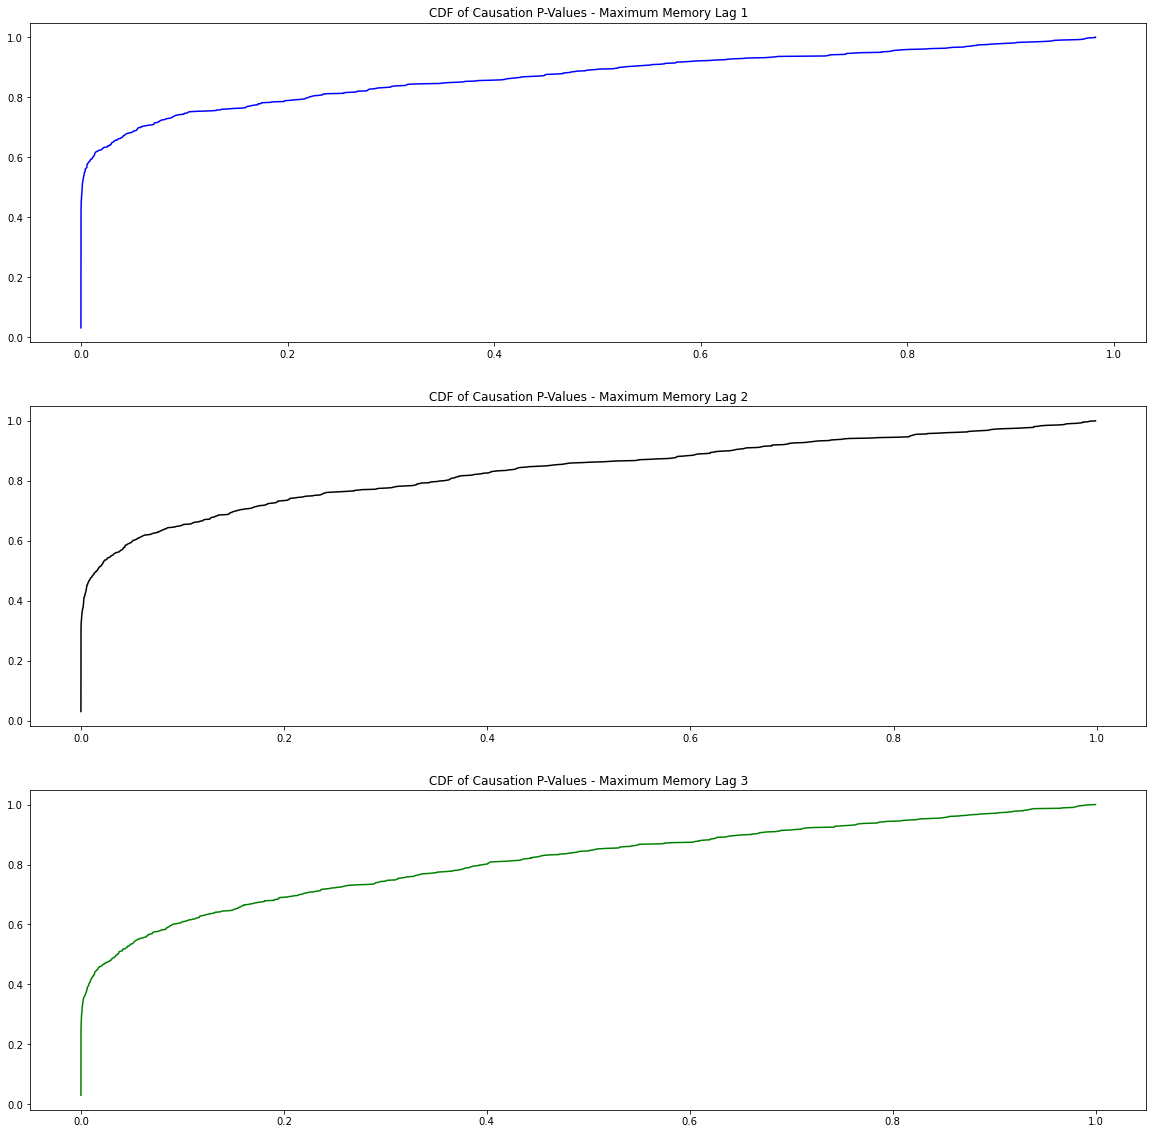

average_usage.memory


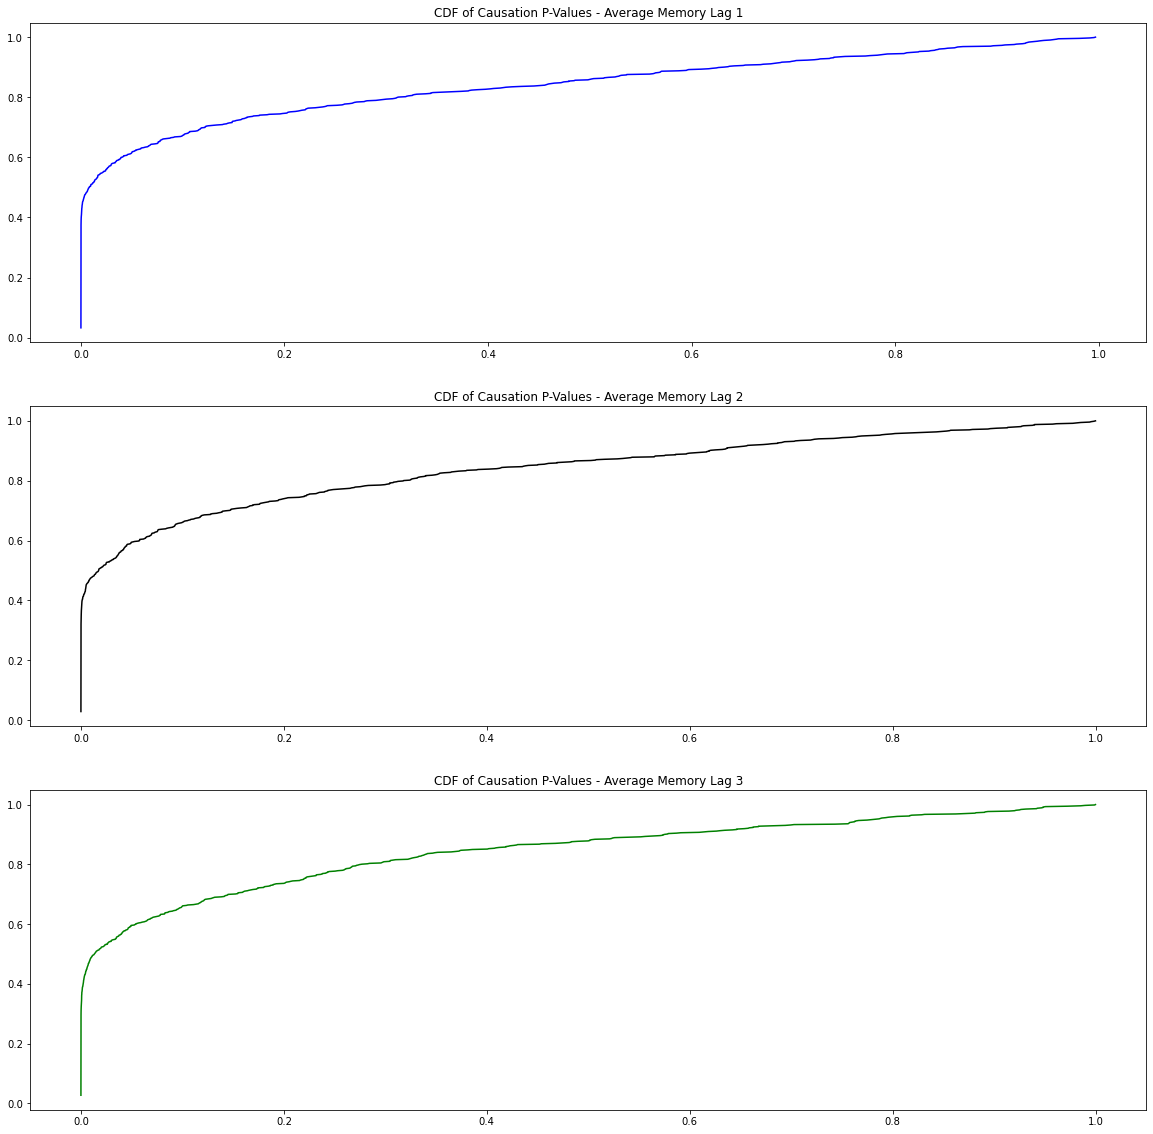

average_usage.cpus


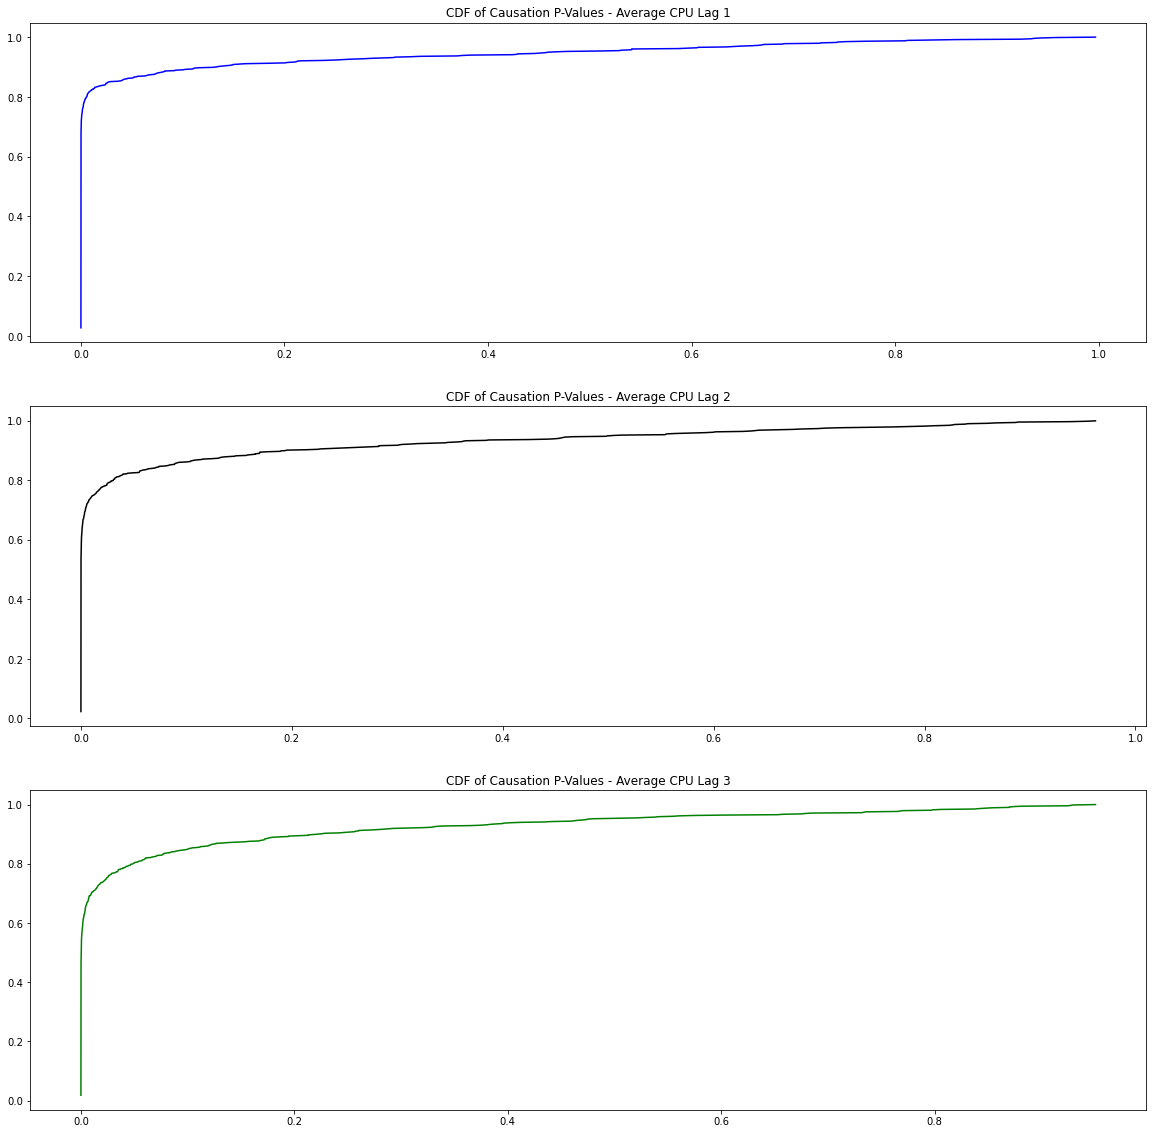

In [18]:
max_cpu_24_dir = "/Users/mattb/Desktop/Courses/MemoryAutoScaling/output_data/max_cpu_24"
stats_dfs['max_cpu_agg_24'] = summarize_statistical_results(max_cpu_24_dir, specs.MAX_CPU_COL, "ssr_chi2test", "Maximum CPU")

In [19]:
analysis.get_stationary_results_df(stats_dfs)

Stationary Stationary Diff 1 Stationary Diff 2 Non-Stationary
Max Mem Agg 3      35.81%            62.44%             0.77%          0.98%
Max Cpu Agg 3      38.93%             59.1%             0.91%          1.05%
Max Mem Agg 24     30.19%            66.94%             1.09%          1.78%
Max Cpu Agg 24     40.44%            57.24%             1.78%          0.55%

In [20]:
analysis.get_total_utilization_df(stats_dfs).T

Max Mem Agg 3 Max Cpu Agg 3 Max Mem Agg 24 Max Cpu Agg 24
Total Utilization        38.55%         0.34%         37.02%          0.32%

In [25]:
util_df = stats_dfs['max_cpu_agg_3'][['utilization', 'allocated']]
util_df['used'] = util_df['utilization'] * util_df['allocated']
print(np.sum(util_df['used']))
print(np.sum(util_df['allocated']))

1571604.2738504405
460815453.747777


/Users/mattb/opt/miniconda3/envs/autoScaling/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [27]:
util_df[util_df['utilization'] < 0.05]

utilization     allocated           used
24       0.046295  1.380897e+02       6.392823
25       0.000000  0.000000e+00       0.000000
29       0.038590  8.729346e+02      33.686353
41       0.032928  1.514957e+02       4.988425
43       0.029898  9.129248e+01       2.729460
...           ...           ...            ...
1385     0.019224  1.633336e+06   31398.664819
1391     0.017058  1.199063e+04     204.533702
1404     0.044997  2.486098e+03     111.867446
1406     0.003766  9.047173e+07  340722.902481
1414     0.038288  3.060720e+03     117.187895

[214 rows x 3 columns]

In [29]:
np.percentile(np.array([1.0, 2.0, 3.0]), 99)

2.98